# Desafio LH

Você foi alocado em um time da Indicium contratado por um estúdio de Hollywood chamado PProductions, e agora deve fazer uma análise em cima de um banco de dados cinematográfico para orientar qual tipo de filme deve ser o próximo a ser desenvolvido. Lembre-se que há muito dinheiro envolvido, então a análise deve ser muito detalhada e levar em consideração o máximo de fatores possíveis (a introdução de dados externos é permitida - e encorajada).


# Dicionário de dados

| Coluna        | Descrição                         |
|---------------|-----------------------------------|
| Series_Title  | Nome do filme                     |
| Released_Year | Ano de lançamento                 |
| Certificate   | Classificação etária              |
| Runtime       | Tempo de duração                  |
| Genre         | Gênero                            |
| IMDB_Rating   | Nota do IMDB                      |
| Overview      | Overview do filme                 |
| Meta_score    | Média ponderada de todas as críticas |
| Director      | Diretor                           |
| Star1         | Ator/atriz #1                     |
| Star2         | Ator/atriz #2                     |
| Star3         | Ator/atriz #3                     |
| Star4         | Ator/atriz #4                     |
| No_of_Votes   | Número de votos                   |
| Gross         | Faturamento  

# EDA

## 1. Conhecendo os dados

In [89]:
import warnings
warnings.filterwarnings('ignore')

In [90]:
# Data Science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# API
import requests
import time
import os
from dotenv import load_dotenv


In [91]:
df = pd.read_csv("/content/desafio_indicium_imdb.csv") # importando os dados para o dataframe
df

Unnamed: 0                                   Series_Title Released_Year  \
0             1                                  The Godfather          1972   
1             2                                The Dark Knight          2008   
2             3                         The Godfather: Part II          1974   
3             4                                   12 Angry Men          1957   
4             5  The Lord of the Rings: The Return of the King          2003   
..          ...                                            ...           ...   
994         995                         Breakfast at Tiffany's          1961   
995         996                                          Giant          1956   
996         997                          From Here to Eternity          1953   
997         998                                       Lifeboat          1944   
998         999                                   The 39 Steps          1935   

    Certificate  Runtime                     Genre  IMDB_Rating  \
0             A  175 min              Crime, Drama         9.20   
1            UA  152 min      Action, Crime, Drama         9.00   
2             A  202 min              Crime, Drama         9.00   
3             U   96 min              Crime, Drama         9.00   
4             U  201 min  Action, Adventure, Drama         8.90   
..          ...      ...                       ...          ...   
994           A  115 min    Comedy, Drama, Romance         7.60   
995           G  201 min            Drama, Western         7.60   
996      Passed  118 min       Drama, Romance, War         7.60   
997         NaN   97 min                Drama, War         7.60   
998         NaN   86 min  Crime, Mystery, Thriller         7.60   

                                              Overview  Meta_score  \
0    An organized crime dynasty's aging patriarch t...      100.00   
1    When the menace known as the Joker wreaks havo...       84.00   
2    The early life and career of Vito Corleone in ...       90.00   
3    A jury holdout attempts to prevent a miscarria...       96.00   
4    Gandalf and Aragorn lead the World of Men agai...       94.00   
..                                                 ...         ...   
994  A young New York socialite becomes interested ...       76.00   
995  Sprawling epic covering the life of a Texas ca...       84.00   
996  In Hawaii in 1941, a private is cruelly punish...       85.00   
997  Several survivors of a torpedoed merchant ship...       78.00   
998  A man in London tries to help a counter-espion...       93.00   

                 Director              Star1              Star2  \
0    Francis Ford Coppola      Marlon Brando          Al Pacino   
1       Christopher Nolan     Christian Bale       Heath Ledger   
2    Francis Ford Coppola          Al Pacino     Robert De Niro   
3            Sidney Lumet        Henry Fonda        Lee J. Cobb   
4           Peter Jackson        Elijah Wood    Viggo Mortensen   
..                    ...                ...                ...   
994         Blake Edwards     Audrey Hepburn     George Peppard   
995        George Stevens   Elizabeth Taylor        Rock Hudson   
996        Fred Zinnemann     Burt Lancaster   Montgomery Clift   
997      Alfred Hitchcock  Tallulah Bankhead        John Hodiak   
998      Alfred Hitchcock       Robert Donat  Madeleine Carroll   

              Star3           Star4  No_of_Votes        Gross  
0        James Caan    Diane Keaton      1620367  134,966,411  
1     Aaron Eckhart   Michael Caine      2303232  534,858,444  
2     Robert Duvall    Diane Keaton      1129952   57,300,000  
3     Martin Balsam    John Fiedler       689845    4,360,000  
4      Ian McKellen   Orlando Bloom      1642758  377,845,905  
..              ...             ...          ...          ...  
994   Patricia Neal     Buddy Ebsen       166544          NaN  
995      James Dean   Carroll Baker        34075          NaN  
996    Deborah Ke

###
Utilização do TMDB para buscar dados adicionais, nesse caso,
Faturamento e Custo para enriquecer a análise.

In [93]:

# --- Configuração ---
# Substitua 'SUA_CHAVE_AQUI' pela sua chave de API do TMDb
load_dotenv()
api_key = os.getenv('TMDB_API_KEY') # pegando a api do arquivo .env
api_key = api_key
base_url = 'https://api.themoviedb.org/3'

# --- 1. Crie as novas colunas no DataFrame ---
# Elas serão preenchidas com os dados da API
df['tmdb_id'] = None
df['Budget'] = 0
df['Revenue'] = 0

# --- 2. Itere sobre os filmes e faça as requisições à API ---
print("Iniciando a busca por dados no TMDb...")

for index, row in df.iterrows():
    title = row['Series_Title']
    year = row['Released_Year']

    print(f"Buscando dados para '{title}' ({year})...")

    # Endpoint de busca por filme
    search_url = f"{base_url}/search/movie?api_key={api_key}&query={title}&year={year}"

    try:
        search_response = requests.get(search_url)
        search_response.raise_for_status()  # Levanta erro para status 4xx/5xx

        search_data = search_response.json()

        # Se encontrou resultados, pega o primeiro
        if search_data['results']:
            tmdb_id = search_data['results'][0]['id']

            # Endpoint para detalhes do filme (inclui orçamento e receita)
            details_url = f"{base_url}/movie/{tmdb_id}?api_key={api_key}"
            details_response = requests.get(details_url)
            details_response.raise_for_status()

            details_data = details_response.json()

            # Preenche as colunas no DataFrame
            df.loc[index, 'tmdb_id'] = tmdb_id
            df.loc[index, 'Budget'] = details_data.get('budget', 0)
            df.loc[index, 'Revenue'] = details_data.get('revenue', 0)

            print(f"-> Dados de '{title}' obtidos com sucesso.")

        else:
            print(f"-> Filme '{title}' não encontrado no TMDb. Pulando...")

    except requests.exceptions.RequestException as e:
        print(f"-> Erro na requisição para '{title}': {e}")

    # Pausa para evitar exceder o limite de requisições da API
    time.sleep(0.5)

print("\nBusca de dados concluída!")

# --- 3. Calcule o ROI ---
# Use um pequeno valor (epsilon) para evitar divisão por zero
epsilon = 1e-6
df['ROI'] = (df['Revenue'] - df['Budget']) / (df['Budget'] + epsilon)

# --- 5. Exiba o DataFrame atualizado ---
print("\nDataFrame com dados do TMDb:")
print(df)

# Se quiser, salve o DataFrame atualizado em um novo arquivo
# df.to_csv('dataframe_com_tmdb_data.csv', index=False)

Iniciando a busca por dados no TMDb...
Buscando dados para 'The Godfather' (1972)...
-> Dados de 'The Godfather' obtidos com sucesso.
Buscando dados para 'The Dark Knight' (2008)...
-> Dados de 'The Dark Knight' obtidos com sucesso.
Buscando dados para 'The Godfather: Part II' (1974)...
-> Dados de 'The Godfather: Part II' obtidos com sucesso.
Buscando dados para '12 Angry Men' (1957)...
-> Dados de '12 Angry Men' obtidos com sucesso.
Buscando dados para 'The Lord of the Rings: The Return of the King' (2003)...
-> Dados de 'The Lord of the Rings: The Return of the King' obtidos com sucesso.
Buscando dados para 'Pulp Fiction' (1994)...
-> Dados de 'Pulp Fiction' obtidos com sucesso.
Buscando dados para 'Schindler's List' (1993)...
-> Dados de 'Schindler's List' obtidos com sucesso.
Buscando dados para 'Inception' (2010)...
-> Dados de 'Inception' obtidos com sucesso.
Buscando dados para 'Fight Club' (1999)...
-> Dados de 'Fight Club' obtidos com sucesso.
Buscando dados para 'The Lord of

In [94]:
df.shape

(999, 20)

In [95]:
# Informações referente ao tipos do Dataframe e já é possível notar valores faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
 16  tmdb_id        993 non-null    object 
 17  Budget         999 non-null    int64  
 18  Revenue   

In [96]:
# Reset the float format to default
pd.options.display.float_format = None

# Display the DataFrame again to see the changes
display(df.head())

Unnamed: 0                                   Series_Title Released_Year  \
0           1                                  The Godfather          1972   
1           2                                The Dark Knight          2008   
2           3                         The Godfather: Part II          1974   
3           4                                   12 Angry Men          1957   
4           5  The Lord of the Rings: The Return of the King          2003   

  Certificate  Runtime                     Genre  IMDB_Rating  \
0           A  175 min              Crime, Drama          9.2   
1          UA  152 min      Action, Crime, Drama          9.0   
2           A  202 min              Crime, Drama          9.0   
3           U   96 min              Crime, Drama          9.0   
4           U  201 min  Action, Adventure, Drama          8.9   

                                            Overview  Meta_score  \
0  An organized crime dynasty's aging patriarch t...       100.0   
1  When the menace known as the Joker wreaks havo...        84.0   
2  The early life and career of Vito Corleone in ...        90.0   
3  A jury holdout attempts to prevent a miscarria...        96.0   
4  Gandalf and Aragorn lead the World of Men agai...        94.0   

               Director           Star1            Star2          Star3  \
0  Francis Ford Coppola   Marlon Brando        Al Pacino     James Caan   
1     Christopher Nolan  Christian Bale     Heath Ledger  Aaron Eckhart   
2  Francis Ford Coppola       Al Pacino   Robert De Niro  Robert Duvall   
3          Sidney Lumet     Henry Fonda      Lee J. Cobb  Martin Balsam   
4         Peter Jackson     Elijah Wood  Viggo Mortensen   Ian McKellen   

           Star4  No_of_Votes        Gross tmdb_id     Budget     Revenue  \
0   Diane Keaton      1620367  134,966,411     238    6000000   245066411   
1  Michael Caine      2303232  534,858,444     155  185000000  1004558444   
2   Diane Keaton      1129952   57,300,000     240   13000000   102600000   
3   John Fiedler       689845    4,360,000     389     397751     4360000   
4  Orlando Bloom      1642758  377,845,905     122   94000000  1118888979   

         ROI  
0  39.844402  
1   4.430046  
2   6.892308  
3   9.961632  
4  10.903074

In [97]:
# Calculando a porcentagem de valores faltantes para cada coluna
missing_percentage = f"{(df.isnull().sum() / len(df)) * 100}"

# Imprimindo a porcentagem de valores faltantes
print(missing_percentage)


Unnamed: 0        0.000000
Series_Title      0.000000
Released_Year     0.000000
Certificate      10.110110
Runtime           0.000000
Genre             0.000000
IMDB_Rating       0.000000
Overview          0.000000
Meta_score       15.715716
Director          0.000000
Star1             0.000000
Star2             0.000000
Star3             0.000000
Star4             0.000000
No_of_Votes       0.000000
Gross            16.916917
tmdb_id           0.600601
Budget            0.000000
Revenue           0.000000
ROI               0.000000
dtype: float64


In [98]:
# Dados duplicados
df.duplicated().sum()

np.int64(0)

In [99]:
# Dividindo o df em categorical e numerical features para analisar melhor as variáveis

numerical_features = df.select_dtypes(include=[np.number])
categorical_features = df.select_dtypes(exclude=[np.number])

print("Numerical Features:")
print(numerical_features.columns)
print("\nCategorical Features:")
print(categorical_features.columns)

Numerical Features:
Index(['Unnamed: 0', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Budget',
       'Revenue', 'ROI'],
      dtype='object')

Categorical Features:
Index(['Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre',
       'Overview', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'Gross',
       'tmdb_id'],
      dtype='object')


In [100]:
# Estatística Descritiva para dados númericos
pd.options.display.float_format = '{:.2f}'.format # reduzindo as casas decimais para melhor visualização dos valores

df.describe()

Unnamed: 0  IMDB_Rating  Meta_score  No_of_Votes       Budget  \
count      999.00       999.00      842.00       999.00       999.00   
mean       500.00         7.95       77.97    271621.42  25679321.57   
std        288.53         0.27       12.38    320912.62  47023443.90   
min          1.00         7.60       28.00     25088.00         0.00   
25%        250.50         7.70       70.00     55471.50   1200000.00   
50%        500.00         7.90       79.00    138356.00   6500000.00   
75%        749.50         8.10       87.00    373167.50  25000000.00   
max        999.00         9.20      100.00   2303232.00 356000000.00   

            Revenue                ROI  
count        999.00             999.00  
mean   135864884.94   1249998399449.32  
std    274941577.60  12764363744445.81  
min            0.00              -1.00  
25%      4278500.00               0.46  
50%     30900000.00               3.27  
75%    124652172.50               8.29  
max   2923706026.00 358000000000000.00

In [101]:
df.drop(columns=['Unnamed: 0'], inplace=True) # Deletando Index

O ROI aparentemente possui Outliers

In [102]:
# Observando os valores únicos de cada coluna
for col in categorical_features.columns:
    print(f"Value Counts for '{col}':")
    print(df[col].value_counts())
    print(f"\n {df[col].nunique()} uniques")
    print("\n" + "="*50 + "\n")

Value Counts for 'Series_Title':
Series_Title
Drishyam                           2
What's Eating Gilbert Grape        1
Tombstone                          1
The Sandlot                        1
The Remains of the Day             1
                                  ..
Her                                1
Bohemian Rhapsody                  1
The Revenant                       1
The Perks of Being a Wallflower    1
The Martian                        1
Name: count, Length: 998, dtype: int64

 998 uniques


Value Counts for 'Released_Year':
Released_Year
2014    32
2004    31
2009    29
2013    28
2016    28
        ..
1920     1
1930     1
1922     1
1943     1
PG       1
Name: count, Length: 100, dtype: int64

 100 uniques


Value Counts for 'Certificate':
Certificate
U           234
A           196
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
Unrated       1
TV-MA         1


In [103]:
df.head(5)

Series_Title Released_Year Certificate  \
0                                  The Godfather          1972           A   
1                                The Dark Knight          2008          UA   
2                         The Godfather: Part II          1974           A   
3                                   12 Angry Men          1957           U   
4  The Lord of the Rings: The Return of the King          2003           U   

   Runtime                     Genre  IMDB_Rating  \
0  175 min              Crime, Drama         9.20   
1  152 min      Action, Crime, Drama         9.00   
2  202 min              Crime, Drama         9.00   
3   96 min              Crime, Drama         9.00   
4  201 min  Action, Adventure, Drama         8.90   

                                            Overview  Meta_score  \
0  An organized crime dynasty's aging patriarch t...      100.00   
1  When the menace known as the Joker wreaks havo...       84.00   
2  The early life and career of Vito Corleone in ...       90.00   
3  A jury holdout attempts to prevent a miscarria...       96.00   
4  Gandalf and Aragorn lead the World of Men agai...       94.00   

               Director           Star1            Star2          Star3  \
0  Francis Ford Coppola   Marlon Brando        Al Pacino     James Caan   
1     Christopher Nolan  Christian Bale     Heath Ledger  Aaron Eckhart   
2  Francis Ford Coppola       Al Pacino   Robert De Niro  Robert Duvall   
3          Sidney Lumet     Henry Fonda      Lee J. Cobb  Martin Balsam   
4         Peter Jackson     Elijah Wood  Viggo Mortensen   Ian McKellen   

           Star4  No_of_Votes        Gross tmdb_id     Budget     Revenue  \
0   Diane Keaton      1620367  134,966,411     238    6000000   245066411   
1  Michael Caine      2303232  534,858,444     155  185000000  1004558444   
2   Diane Keaton      1129952   57,300,000     240   13000000   102600000   
3   John Fiedler       689845    4,360,000     389     397751     4360000   
4  Orlando Bloom      1642758  377,845,905     122   94000000  1118888979   

    ROI  
0 39.84  
1  4.43  
2  6.89  
3  9.96  
4 10.90

### Obs
Não Farei o input dos valores nulos, ao invés disso, farei a análise com deletando os valores,mesmo que a quantidade deletada seja significativa, a maioria são pequenos filmes com poucos dados a respeito dos mesmos. Vale mais apena uma análise precisa de 85% dos dados que uma enviesada.

Deixarei para fazer os inputs na modelagem dos algoritmos de machine learning

## 2. Análise univariada

### 2.1 Features Numéricas

#### Análisando outliers

In [ ]:
df['Gross'] = pd.to_numeric(df['Gross'].str.replace(r'[^\d.]', '', regex=True), errors='coerce') # Convertendo o gross para numérico

In [27]:
df["ROI"].tail(50)

949               0.43
950               2.51
951               0.48
952               3.90
953               4.01
954               0.89
955               2.38
956              -0.42
957               0.00
958               0.01
959               2.76
960              -0.74
961               7.41
962               3.07
963              -0.88
964               6.58
965               5.83
966   1273525000000.00
967               0.64
968               0.20
969               4.83
970    473110000000.00
971              -0.55
972              25.48
973               1.53
974               4.80
975               4.28
976              11.70
977               2.30
978               7.01
979               1.82
980               6.95
981              11.30
982               4.62
983               8.40
984               4.38
985               2.71
986              14.22
987              14.34
988              -0.44
989               0.00
990               0.30
991              93.50
992              -1.00
993              18.64
994               2.80
995               5.08
996              17.48
997              -0.37
998               0.00
Name: ROI, dtype: float64

In [28]:
df["ROI"].describe()

count               999.00
mean      1249998399449.32
std      12764363744445.81
min                  -1.00
25%                   0.46
50%                   3.27
75%                   8.29
max     358000000000000.00
Name: ROI, dtype: float64

In [29]:
df["ROI"].quantile(0.9308)

np.float64(2996313865.0623794)

In [30]:
df["ROI"].quantile(0.9307)

np.float64(2677656782.809305)

In [31]:
roi_quantile_value = df["ROI"].quantile(0.9307)

# Filtrando o dataframe para pegar as linhas onde o ROI é maior ou igual o valor do quartil
df_quantile = df[df["ROI"] >= roi_quantile_value]

# Display the resulting DataFrame
display(df_quantile)

Series_Title Released_Year Certificate  Runtime  \
55          Kimi no na wa.          2016           U  106 min   
90    Miracle in cell NO.7          2019       TV-14  132 min   
91          Babam ve Oglum          2005         NaN  112 min   
104           Idi i smotri          1985           A  142 min   
120                  Ikiru          1952         NaN  143 min   
..                     ...           ...         ...      ...   
884               Victoria          2015         NaN  138 min   
923           Huo Yuan Jia          2006       PG-13  104 min   
934         Jeux d'enfants          2003           R   93 min   
966  Trois couleurs: Blanc          1994           U   92 min   
970      Omohide poro poro          1991           U  118 min   

                         Genre  IMDB_Rating  \
55   Animation, Drama, Fantasy         8.40   
90                       Drama         8.30   
91               Drama, Family         8.30   
104       Drama, Thriller, War         8.30   
120                      Drama         8.30   
..                         ...          ...   
884      Crime, Drama, Romance         7.60   
923   Action, Biography, Drama         7.60   
934     Comedy, Drama, Romance         7.60   
966     Comedy, Drama, Romance         7.60   
970  Animation, Drama, Romance         7.60   

                                              Overview  Meta_score  \
55   Two strangers find themselves linked in a biza...       79.00   
90   A story of love between a mentally-ill father ...         NaN   
91   The family of a left-wing journalist is torn a...         NaN   
104  After finding an old rifle, a young boy joins ...         NaN   
120  A bureaucrat tries to find a meaning in his li...         NaN   
..                                                 ...         ...   
884  A young Spanish woman who has recently moved t...       77.00   
923  A biography of Chinese Martial Arts Master Huo...       70.00   
934  As adults, best friends Julien and Sophie cont...       45.00   
966  After his wife divorces him, a Polish immigran...       88.00   
970  A twenty-seven-year-old office worker travels ...       90.00   

                 Director                 Star1                 Star2  \
55         Makoto Shinkai      Ryûnosuke Kamiki    Mone Kamishiraishi   
90     Mehmet Ada Öztekin    Aras Bulut Iynemli  Nisa Sofiya Aksongur   
91            Çagan Irmak        Çetin Tekindor         Fikret Kuskan   
104           Elem Klimov    Aleksey Kravchenko         Olga Mironova   
120        Akira Kurosawa       Takashi Shimura          Nobuo Kaneko   
..                    ...                   ...                   ...   
884    Sebastian Schipper            Laia Costa         Frederick Lau   
923              Ronny Yu                Jet Li                Li Sun   
934          Yann Samuell       Guillaume Canet      Marion Cotillard   
966  Krzysztof Kieslowski  Zbigniew Zamachowski           Julie Delpy   
970         Isao Takahata             Miki Imai      Toshirô Yanagiba   

                      Star3                 Star4  No_of_Votes       Gross  \
55               Ryô Narita              Aoi Yûki       194838  5017246.00   
90             Deniz Baysal    Celile Toyon Uysal        33935         NaN   
91                  Hümeyra            Ege Tanman        78925         NaN   
104  Liubomiras Laucevicius       Vladas Bagdonas        59056         NaN   
120        Shin'ichi Himori          Haruo Tanaka        68463    55240.00   
..                      ...                   ...          ...         ...   
884          Franz Rogowski           Burak Yigit        52903         NaN   
923               Yong Dong                Yun Qu        72863 24633730.00   
934      Thibault Verhaeghe  Joséphine Lebas-Joly        67360   548707.00   
966            Janusz Gajos           Jerzy Stuhr        64390  1464625.00   
970              Yoko Honna          Mayumi Izuka        27071   453243.00   

    tmdb_id  

É importante notar que os dados de bilheteria mundial obtidos do TMDB podem apresentar algumas ressalvas. Filmes com orçamentos menores podem não ter sido catalogados na base de dados, resultando em valores zero para orçamento(Budget) deixando o roi como o valor faturado. Além disso, a coluna 'ROI' pode conter valores atípicos (outliers) que podem ser resultado de erros nos dados ou de casos genuínos de filmes de baixo orçamento que alcançaram retornos extremamente altos, como "Atividade Paranormal" ou "A Bruxa de Blair". Portanto, estarei removendo esses filmes para evitar distorções na análise.

In [32]:
df.drop(df[df["Budget"] == 0].index, inplace=True) # Removendo a linha com erro

In [33]:
df["ROI"]

0     39.84
1      4.43
2      6.89
3      9.96
4     10.90
       ... 
993   18.64
994    2.80
995    5.08
996   17.48
997   -0.37
Name: ROI, Length: 842, dtype: float64

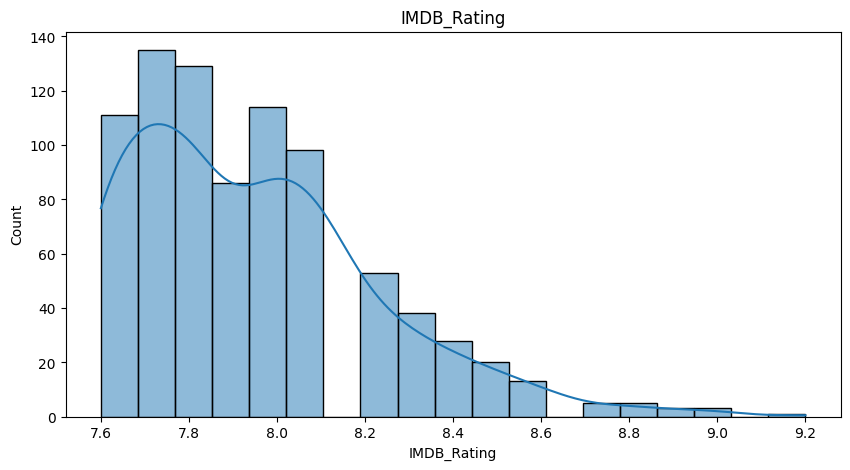

count   842.00
mean      7.95
std       0.28
min       7.60
1%        7.60
5%        7.60
25%       7.70
50%       7.90
75%       8.10
95%       8.50
99%       8.80
max       9.20
Name: IMDB_Rating, dtype: float64
----------------------------------------------------------------------


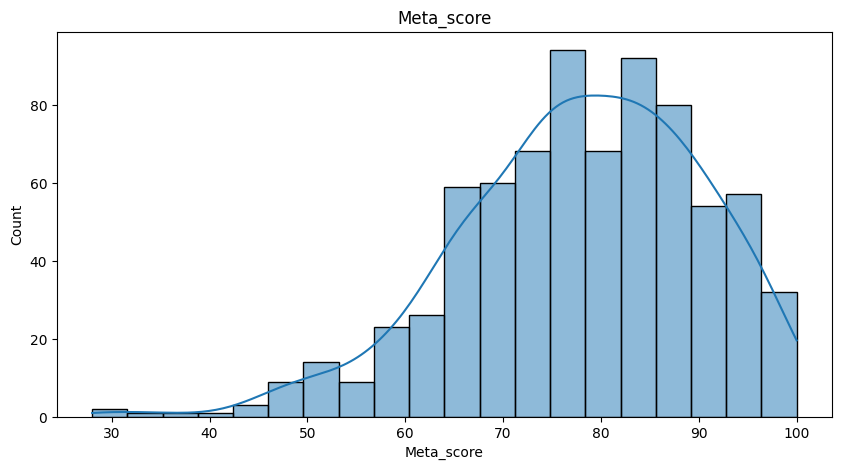

count   753.00
mean     77.88
std      12.40
min      28.00
1%       45.52
5%       56.00
25%      70.00
50%      79.00
75%      87.00
95%      96.00
99%     100.00
max     100.00
Name: Meta_score, dtype: float64
----------------------------------------------------------------------


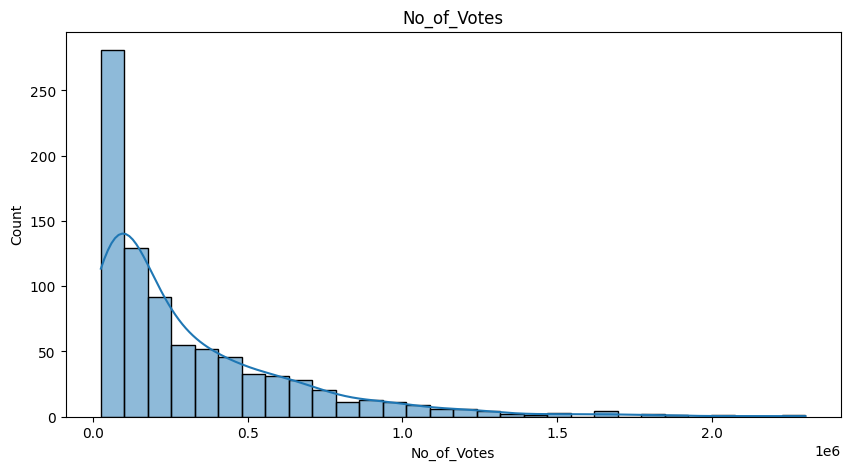

count       842.00
mean     311868.83
std      334213.82
min       25088.00
1%        26676.03
5%        31568.20
25%       72775.25
50%      187150.50
75%      438542.00
95%      995291.10
99%     1577718.39
max     2303232.00
Name: No_of_Votes, dtype: float64
----------------------------------------------------------------------


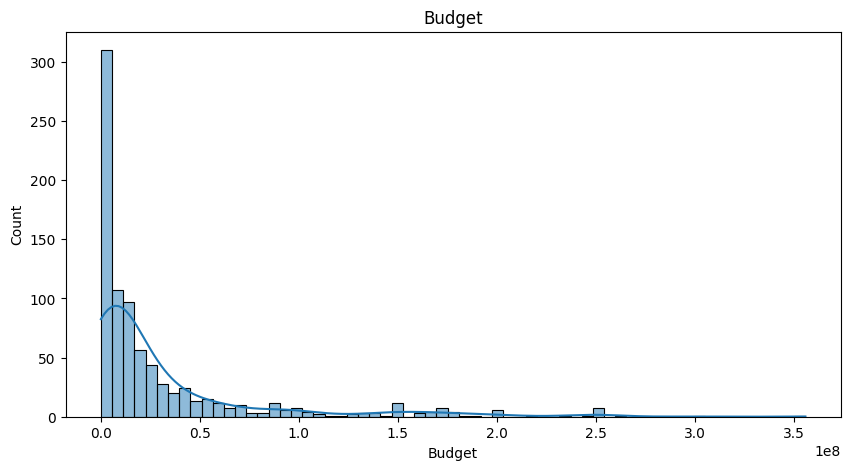

count         842.00
mean     30467508.60
std      49778909.88
min           105.00
1%         150000.00
5%         601500.00
25%       3000000.00
50%      12000000.00
75%      30000000.00
95%     150000000.00
99%     250000000.00
max     356000000.00
Name: Budget, dtype: float64
----------------------------------------------------------------------


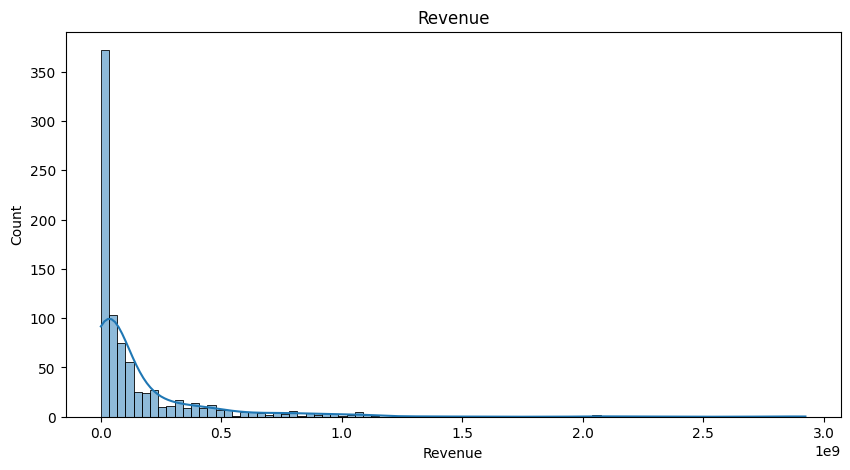

count          842.00
mean     159711311.70
std      293084693.24
min              0.00
1%               0.00
5%          118002.95
25%       10164847.50
50%       44846526.50
75%      170930739.25
95%      747799971.55
99%     1140221866.83
max     2923706026.00
Name: Revenue, dtype: float64
----------------------------------------------------------------------


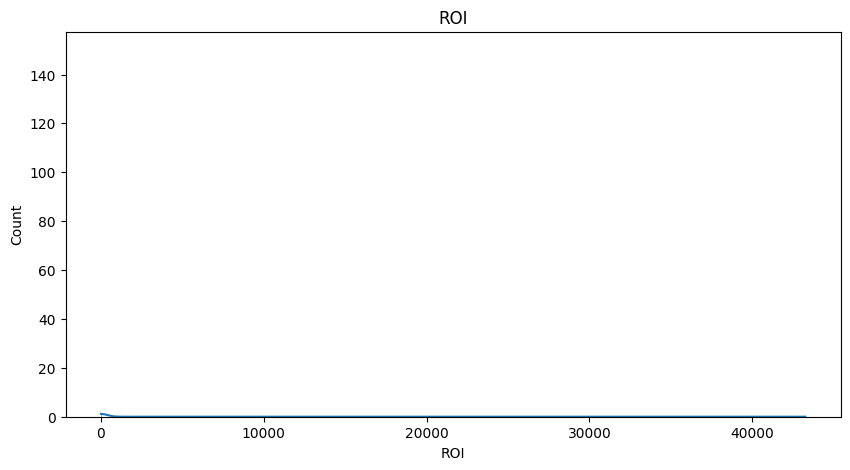

count     842.00
mean       59.23
std      1490.90
min        -1.00
1%         -1.00
5%         -0.88
25%         0.93
50%         3.33
75%         7.29
95%        26.57
99%        85.39
max     43264.00
Name: ROI, dtype: float64
----------------------------------------------------------------------


In [34]:
for c in numerical_features:
    if c in df.columns:
        plt.figure(figsize=(10,5))
        sns.histplot(df[c].dropna(), kde=True)
        plt.title(c)
        plt.show()
        print(df[c].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).round(2))
        print('-'*70)

Novamente o ROI ainda continua distorcido,

In [35]:
roi_quantile_value = 99
df[df["ROI"] >= roi_quantile_value]

Series_Title Released_Year Certificate  Runtime  \
278                     Rocky          1976           U  120 min   
313        Gone with the Wind          1939           U  238 min   
407     Au revoir les enfants          1987           U  104 min   
543  Night of the Living Dead          1968         NaN   96 min   
815                    Clerks          1994           R   92 min   
843                 Halloween          1978           A   91 min   
849          Enter the Dragon          1973           A  102 min   

                       Genre  IMDB_Rating  \
278             Drama, Sport         8.10   
313  Drama, History, Romance         8.10   
407               Drama, War         8.00   
543         Horror, Thriller         7.90   
815                   Comedy         7.70   
843         Horror, Thriller         7.70   
849     Action, Crime, Drama         7.70   

                                              Overview  Meta_score  \
278  A small-time boxer gets a supremely rare chanc...       70.00   
313  A manipulative woman and a roguish man conduct...       97.00   
407  A French boarding school run by priests seems ...       88.00   
543  A ragtag group of Pennsylvanians barricade the...       89.00   
815  A day in the lives of two convenience clerks n...       70.00   
843  Fifteen years after murdering his sister on Ha...       87.00   
849  A secret agent comes to an opium lord's island...       83.00   

             Director               Star1             Star2  \
278  John G. Avildsen  Sylvester Stallone       Talia Shire   
313    Victor Fleming        George Cukor          Sam Wood   
407       Louis Malle     Gaspard Manesse     Raphael Fejtö   
543  George A. Romero         Duane Jones      Judith O'Dea   
815       Kevin Smith    Brian O'Halloran     Jeff Anderson   
843    John Carpenter    Donald Pleasence  Jamie Lee Curtis   
849     Robert Clouse           Bruce Lee        John Saxon   

                  Star3                       Star4  No_of_Votes        Gross  \
278          Burt Young               Carl Weathers       518546 117235247.00   
313         Clark Gable                Vivien Leigh       290074 198676459.00   
407    Francine Racette  Stanislas Carré de Malberg        31163   4542825.00   
543        Karl Hardman             Marilyn Eastman       116557     89029.00   
815  Marilyn Ghigliotti              Lisa Spoonauer       211450   3151130.00   
843          Tony Moran                  Nancy Kyes       233106  47000000.00   
849           Jim Kelly                  Ahna Capri        96561  25000000.00   

    tmdb_id   Budget    Revenue      ROI  
278    1366  1000000  225253184   224.25  
313     770  4000000  402352579    99.59  
407    1786      105    4542825 43264.00  
543   10331   114000   30236452   264.23  
815    2292    27575    3151130   113.27  
843     948   325000   70260597   215.19  
849    9461   850000  400000000   469.59

Apenas o Au revoir les enfants possui um Budget Irreal, irei deletá-la para continuar a análise

In [36]:
df.drop(index=407, inplace=True)

In [37]:
df["ROI"].describe()

count   841.00
mean      7.86
std      24.00
min      -1.00
25%       0.93
50%       3.33
75%       7.25
max     469.59
Name: ROI, dtype: float64

#### Histogramas, Boxplot e violinplot


>>> Feature: IMDB_Rating
count   841.00
mean      7.95
std       0.28
min       7.60
1%        7.60
5%        7.60
25%       7.70
50%       7.90
75%       8.10
95%       8.50
99%       8.80
max       9.20
Name: IMDB_Rating, dtype: float64


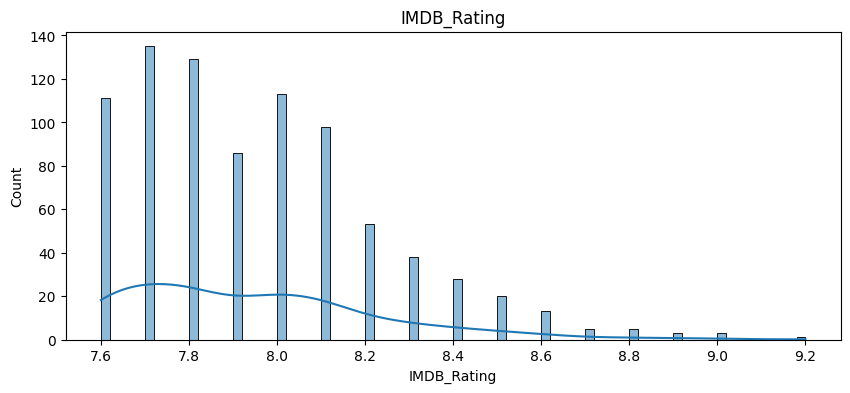

----------------------------------------------------------------------


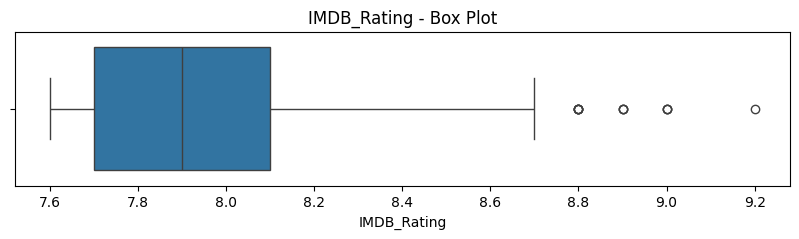

----------------------------------------------------------------------


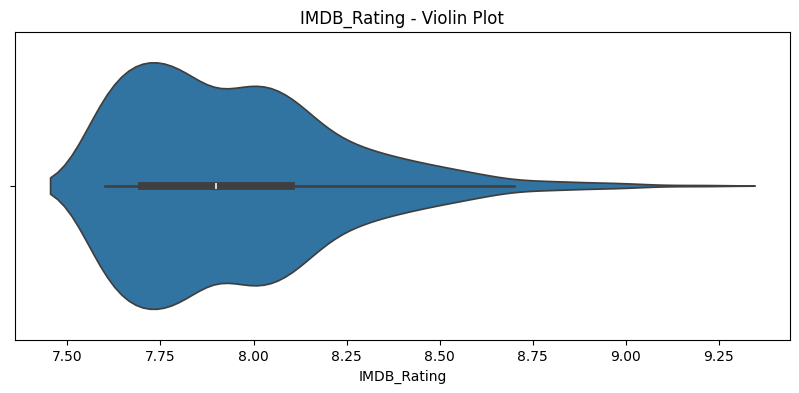

----------------------------------------------------------------------

>>> Feature: Meta_score
count   752.00
mean     77.87
std      12.40
min      28.00
1%       45.51
5%       56.00
25%      70.00
50%      79.00
75%      87.00
95%      96.00
99%     100.00
max     100.00
Name: Meta_score, dtype: float64


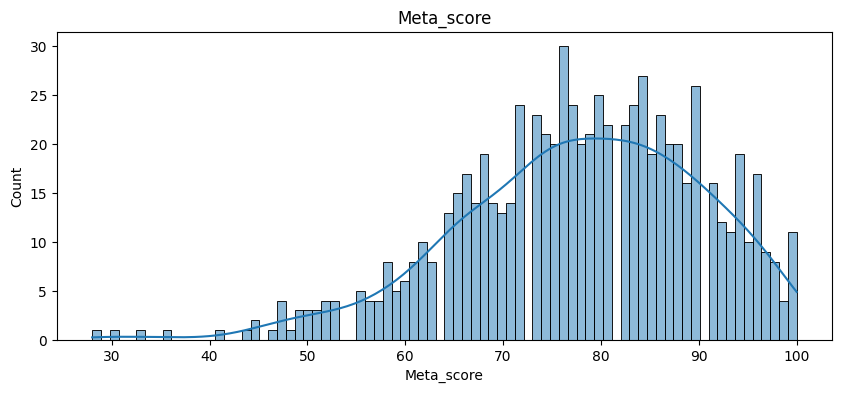

----------------------------------------------------------------------


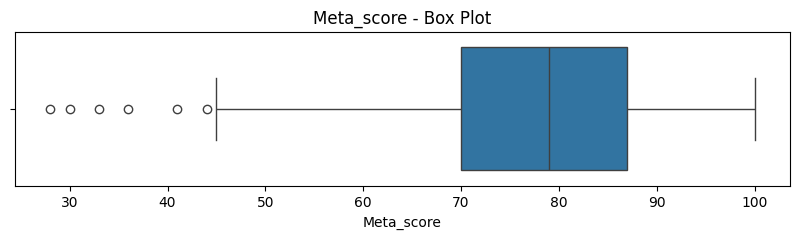

----------------------------------------------------------------------


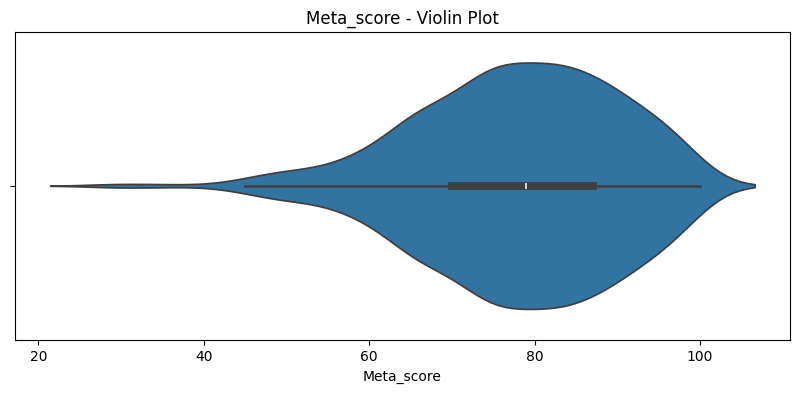

----------------------------------------------------------------------

>>> Feature: No_of_Votes
count       841.00
mean     312202.61
std      334272.25
min       25088.00
1%        26675.20
5%        31572.00
25%       73172.00
50%      187567.00
75%      439406.00
95%      995506.00
99%     1578758.60
max     2303232.00
Name: No_of_Votes, dtype: float64


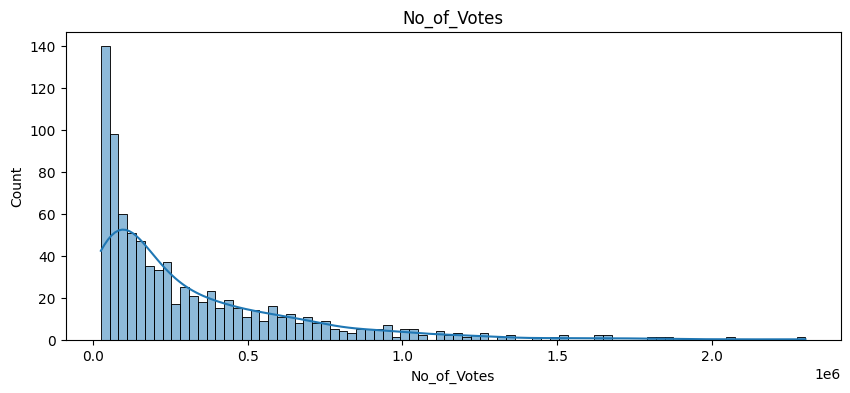

----------------------------------------------------------------------


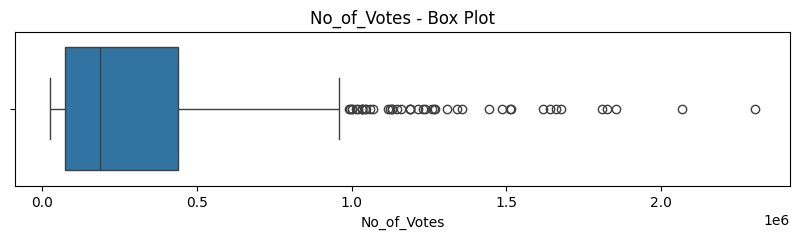

----------------------------------------------------------------------


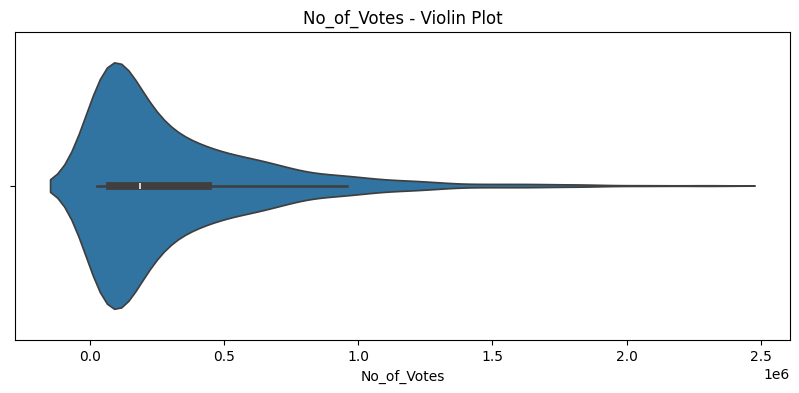

----------------------------------------------------------------------

>>> Feature: Budget
count         841.00
mean     30503736.19
std      49797423.72
min          3025.00
1%         154000.00
5%         630000.00
25%       3000000.00
50%      12000000.00
75%      30000000.00
95%     150000000.00
99%     250000000.00
max     356000000.00
Name: Budget, dtype: float64


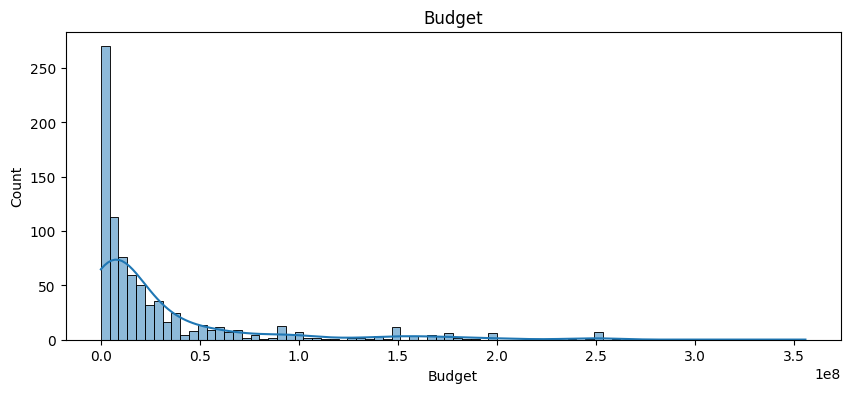

----------------------------------------------------------------------


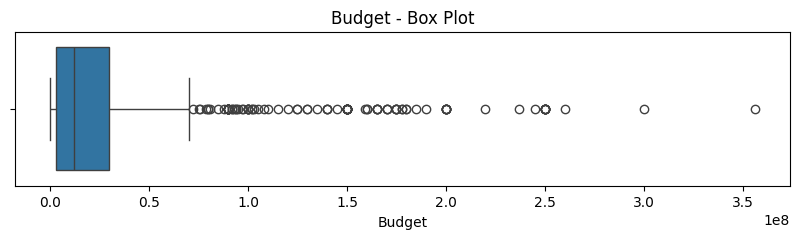

----------------------------------------------------------------------


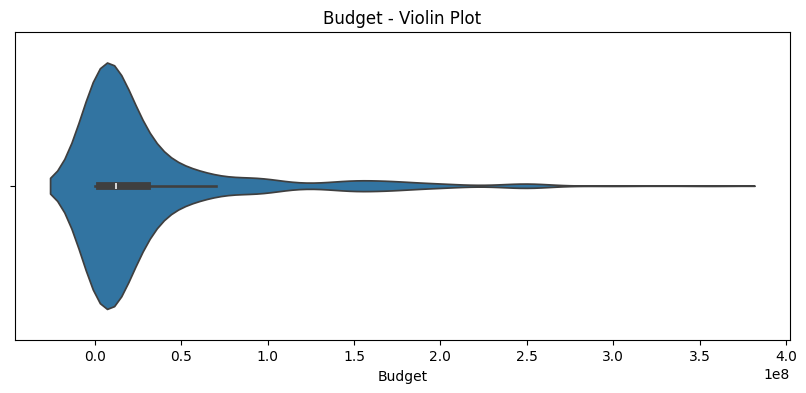

----------------------------------------------------------------------

>>> Feature: Revenue
count          841.00
mean     159895816.44
std      293210163.89
min              0.00
1%               0.00
5%          117668.00
25%       10462500.00
50%       44908000.00
75%      171627166.00
95%      747862775.00
99%     1140583441.20
max     2923706026.00
Name: Revenue, dtype: float64


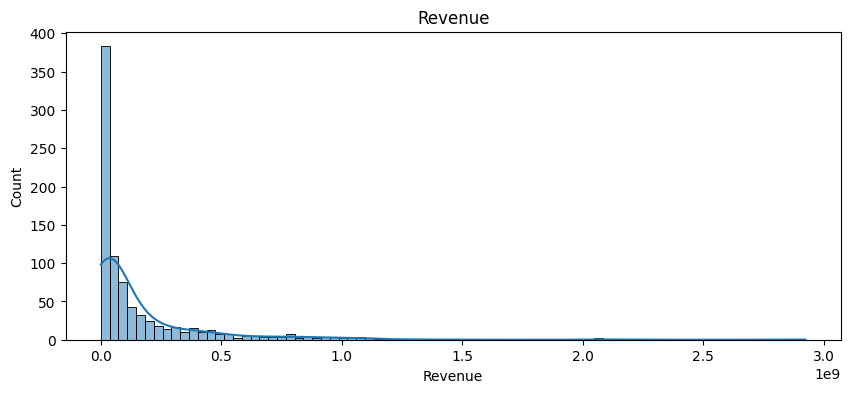

----------------------------------------------------------------------


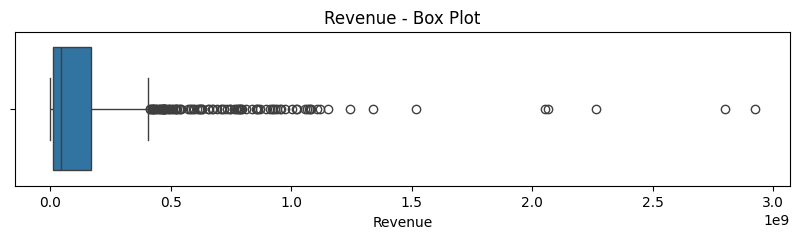

----------------------------------------------------------------------


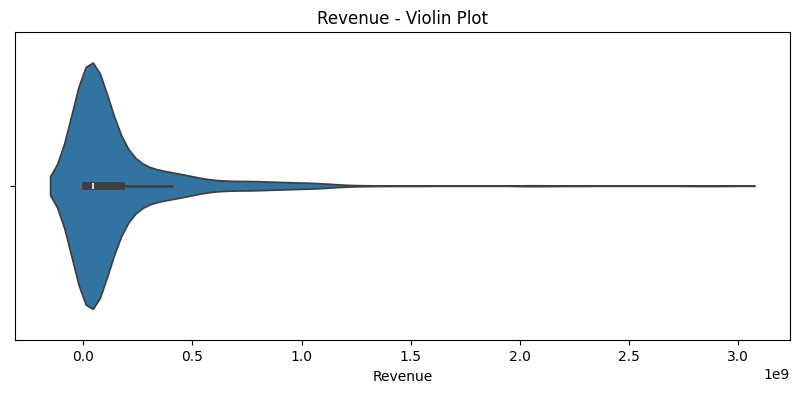

----------------------------------------------------------------------

>>> Feature: ROI
count   841.00
mean      7.86
std      24.00
min      -1.00
1%       -1.00
5%       -0.88
25%       0.93
50%       3.33
75%       7.25
95%      25.74
99%      80.94
max     469.59
Name: ROI, dtype: float64
min, max: -0.9999999999999788 469.58823529356516
counts: >1 (100%+): 622
counts: >10 (1000%+): 144
counts: >50 (5000%+): 18
budgets missing: 0
revenue == 0: 31
----------------------------------------------------------------------


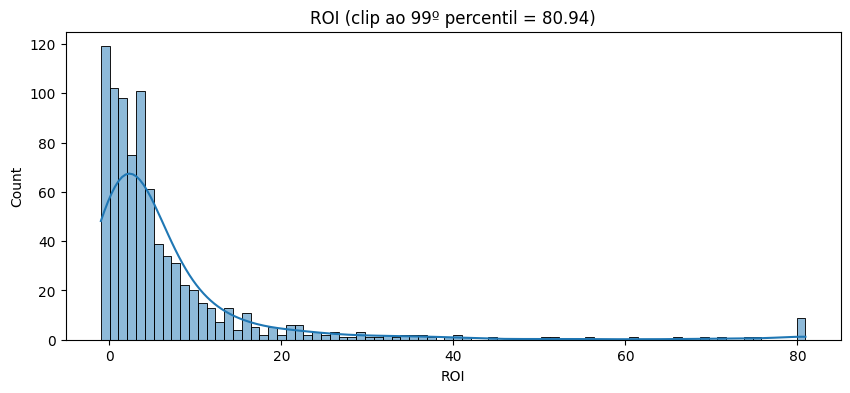

----------------------------------------------------------------------


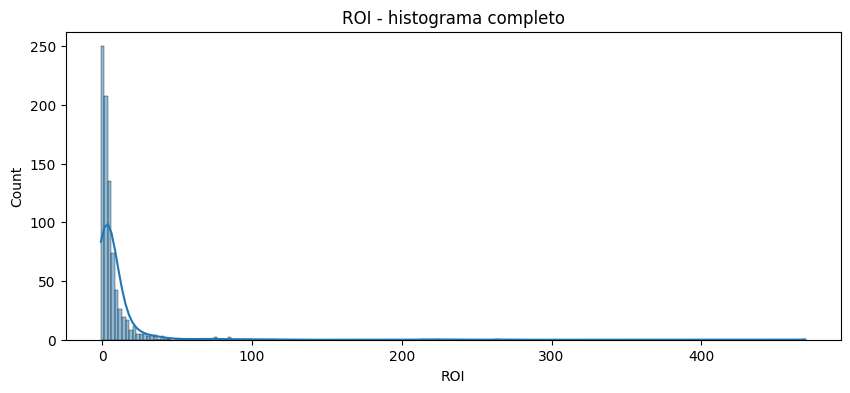

----------------------------------------------------------------------


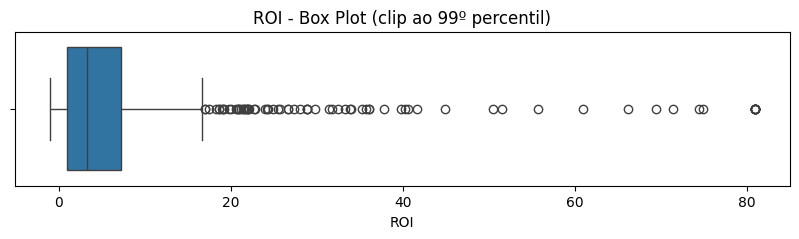

----------------------------------------------------------------------


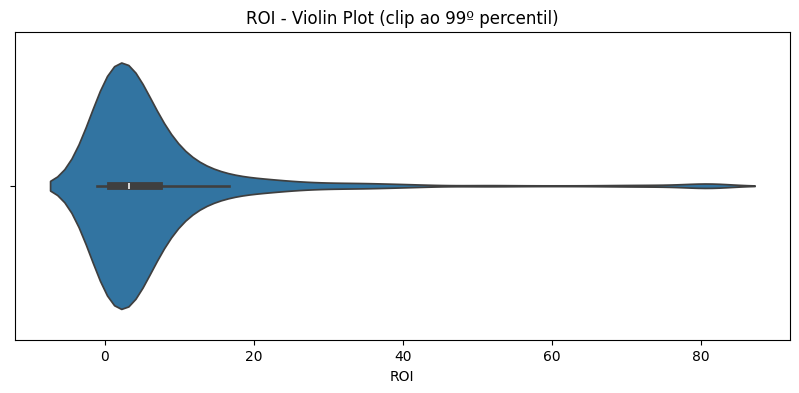

----------------------------------------------------------------------


In [38]:
# tratar budgets inválidos como NaN (importantíssimo)
df.loc[df['Budget'] <= 0, 'Budget'] = np.nan

# loop por features numéricas
for c in numerical_features:
    if c not in df.columns:
        continue

    series = pd.to_numeric(df[c], errors='coerce').dropna()
    print(f"\n>>> Feature: {c}")
    print(series.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).round(2))

    # tratamento especial para ROI (pct)
    if c in ["ROI"]:
        roi = series.copy()

        # estatísticas adicionais e contagem de extremos
        print("min, max:", roi.min(), roi.max())
        print("counts: >1 (100%+):", (roi > 1).sum())
        print("counts: >10 (1000%+):", (roi > 10).sum())
        print("counts: >50 (5000%+):", (roi > 50).sum())
        print("budgets missing:", df['Budget'].isna().sum())
        print("revenue == 0:", (df['Revenue'] == 0).sum())
        print('-'*70)

        # 1) histograma com clip no 99º percentil (zoom no corpo)
        p99 = roi.quantile(0.99)
        plt.figure(figsize=(10,4))
        sns.histplot(roi.clip(upper=p99), kde=True, bins=80)
        plt.title(f'{c} (clip ao 99º percentil = {p99:.2f})')
        plt.xlabel(c)
        plt.show()
        print('-'*70)

        # 2) histograma completo (pode ficar esticado por outliers)
        plt.figure(figsize=(10,4))
        sns.histplot(roi, kde=True, bins=200)
        plt.title(f'{c} - histograma completo')
        plt.xlabel(c)
        plt.show()
        print('-'*70)

        # Box plot para ROI (clipado)
        plt.figure(figsize=(10, 2))
        sns.boxplot(x=roi.clip(upper=p99))
        plt.title(f'{c} - Box Plot (clip ao 99º percentil)')
        plt.xlabel(c)
        plt.show()
        print('-'*70)

        # Violin plot para ROI (clipado)
        plt.figure(figsize=(10, 4))
        sns.violinplot(x=roi.clip(upper=p99))
        plt.title(f'{c} - Violin Plot (clip ao 99º percentil)')
        plt.xlabel(c)
        plt.show()
        print('-'*70)


    elif c in numerical_features:
        #
      # comportamento padrão para outras numéricas
      plt.figure(figsize=(10,4))
      sns.histplot(series, kde=True, bins=80)
      plt.title(c)
      plt.show()
      print('-'*70)

      # Box plot para outras numéricas
      plt.figure(figsize=(10, 2))
      sns.boxplot(x=series)
      plt.title(f'{c} - Box Plot')
      plt.xlabel(c)
      plt.show()
      print('-'*70)

      # Violin plot para outras numéricas
      plt.figure(figsize=(10, 4))
      sns.violinplot(x=series)
      plt.title(f'{c} - Violin Plot')
      plt.xlabel(c)
      plt.show()
      print('-'*70)

#### Insights

🎬 IMDB_Rating (avaliação do público)

Distribuição muito concentrada entre 7.6 e 9.2, com média 7.95 e desvio padrão bem baixo (0.28).

📝 Meta_score (críticos)

Muito mais disperso que o IMDB: média ~78, std 12.4, indo de 28 a 100.

críticos são mais “seletivos”, gerando maior variabilidade.

O gap entre público (sempre alto) e críticos (mais distribuído) pode ser explorado como feature de diferenciação → filmes amados pelo público mas rejeitados pela crítica (ou vice-versa).

👥 No_of_Votes (popularidade)

Média ~312k votos, mas distribuição com cauda muito longa (máx. ~2.3M).

Insight: a popularidade varia mais que a avaliação em si.

Os percentis mostram concentração até ~400k votos, mas outliers muito grandes (1M+).

Isso provavelmente é uma proxy para engajamento/popularidade global (quanto mais gente vota, maior o alcance e potencial de receita).

💰 Budget

Extremamente assimétrico: mediana 12M, mas máx. 356M.

maioria dos filmes é baixo a médio orçamento, mas os grandes blockbusters puxam a média para cima.

Quartis: 25% < 3M; 50% < 12M; 75% < 30M → grande concentração em produções relativamente baratas.

💵 Revenue

Cauda ainda mais longa: mediana 44M, mas máx. ~2.9B.

25% dos filmes faturam < 10M, 75% < 171M → alta desigualdade na distribuição de sucesso.

Insight: a maioria dos filmes tem receita modesta, enquanto poucos viram “super-hits”.

📈 ROI

Média ~7.8x (cada dólar vira quase 8, em média).

Mas a dispersão é enorme: alguns perdem dinheiro (ROI -1 a 0), enquanto 18 filmes têm ROI > 50x (5000%+).

Insight: retorno não é linear com orçamento. Pequenos filmes podem ter ROI gigantes, e grandes blockbusters podem até dar prejuízo.

O fato de 622 filmes (>70%) terem ROI > 1 mostra que a maioria dá lucro, mas não necessariamente altos valores.

### 2.2 Features categóricas

#### tabelas de frequências

In [39]:
# Seleciona as features categóricas para tabelas de frequência, excluindo aquelas com muitos valores únicos
categorical_cols_for_freq = df.select_dtypes(include=['object']).columns.drop(['Series_Title', 'Overview', 'tmdb_id'])

# Gera tabelas de frequência para as colunas categóricas selecionadas
for col in categorical_cols_for_freq:
    print(f"Tabela de Frequência para '{col}':")
    # Calcula a frequência absoluta
    absolute_frequency = df[col].value_counts()
    # Calcula a frequência relativa (em porcentagem)
    relative_frequency = df[col].value_counts(normalize=True) * 100

    # Combina em um único DataFrame para exibição
    frequency_table = pd.DataFrame({'Frequência Absoluta': absolute_frequency, 'Frequência Relativa (%)': relative_frequency})
    print(frequency_table)

    # Imprime o número de valores únicos na coluna
    print(f"\n {df[col].nunique()} valores únicos")
    print("\n" + "="*50 + "\n")

# --- Tratamento separado para a coluna 'Genre' ---

# Cria uma lista de todos os gêneros individuais (separando os múltiplos gêneros por filme)
all_genres = df['Genre'].str.split(', ').explode()

# Obtém a frequência de cada gênero individual
absolute_genre_frequencies = all_genres.value_counts()
relative_genre_frequencies = all_genres.value_counts(normalize=True) * 100

# Combina em um único DataFrame para exibição
genre_frequency_table = pd.DataFrame({'Frequência Absoluta': absolute_genre_frequencies, 'Frequência Relativa (%)': relative_genre_frequencies})

print("Tabela de Frequência para Gêneros Individuais:")
print(genre_frequency_table)
print("\n" + "="*50 + "\n")

Tabela de Frequência para 'Released_Year':
               Frequência Absoluta  Frequência Relativa (%)
Released_Year                                              
2009                            28                     3.33
2014                            27                     3.21
2013                            26                     3.09
2004                            26                     3.09
2007                            25                     2.97
...                            ...                      ...
1930                             1                     0.12
1945                             1                     0.12
1947                             1                     0.12
1935                             1                     0.12
PG                               1                     0.12

[96 rows x 2 columns]

 96 valores únicos


Tabela de Frequência para 'Certificate':
             Frequência Absoluta  Frequência Relativa (%)
Certificate                      

Os valores na tabela de frequência para os Gêneros individuais estão passando de 100% porque um mesmo filme pode pertencer a múltiplos gêneros.

Quando calculamos a frequência relativa dessa forma (dividindo cada filme em seus gêneros individuais e contando cada gênero), a soma total das "ocorrências de gênero" é maior do que o número total de filmes.

Por exemplo, um filme listado como "Action, Crime, Drama" contribui para a contagem de "Action", "Crime" e "Drama" individualmente. Se você somar as porcentagens individuais de cada gênero, o total será maior que 100%, pois cada filme com múltiplos gêneros é contado em cada um deles.

Isso é esperado ao analisar dados onde cada item pode ter múltiplas etiquetas ou categorias, como é o caso dos gêneros de filmes. A frequência relativa aqui mostra a proporção de ocorrências de cada gênero em relação ao total de todas as ocorrências de gênero combinadas em todos os filmes.

### Cardinalidade

Valores com mais uniques/categorias (valores únicos na coluna)

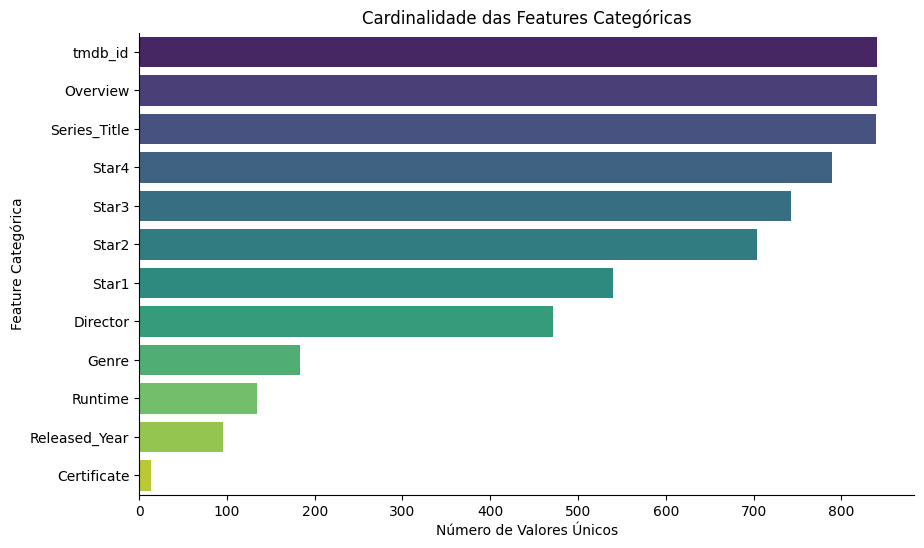

In [41]:
# Calcular o número de valores únicos para cada coluna categórica
categorical_nunique = df.select_dtypes(include=['object']).nunique()

# Ordenar os resultados para melhor visualização
categorical_nunique = categorical_nunique.sort_values(ascending=False)

# Plotar o número de valores únicos
plt.figure(figsize=(10, 6))
sns.barplot(x=categorical_nunique.values, y=categorical_nunique.index, palette='viridis')
plt.title('Cardinalidade das Features Categóricas')
plt.xlabel('Número de Valores Únicos')
plt.ylabel('Feature Categórica')
sns.despine()
plt.show()

### CountPlot

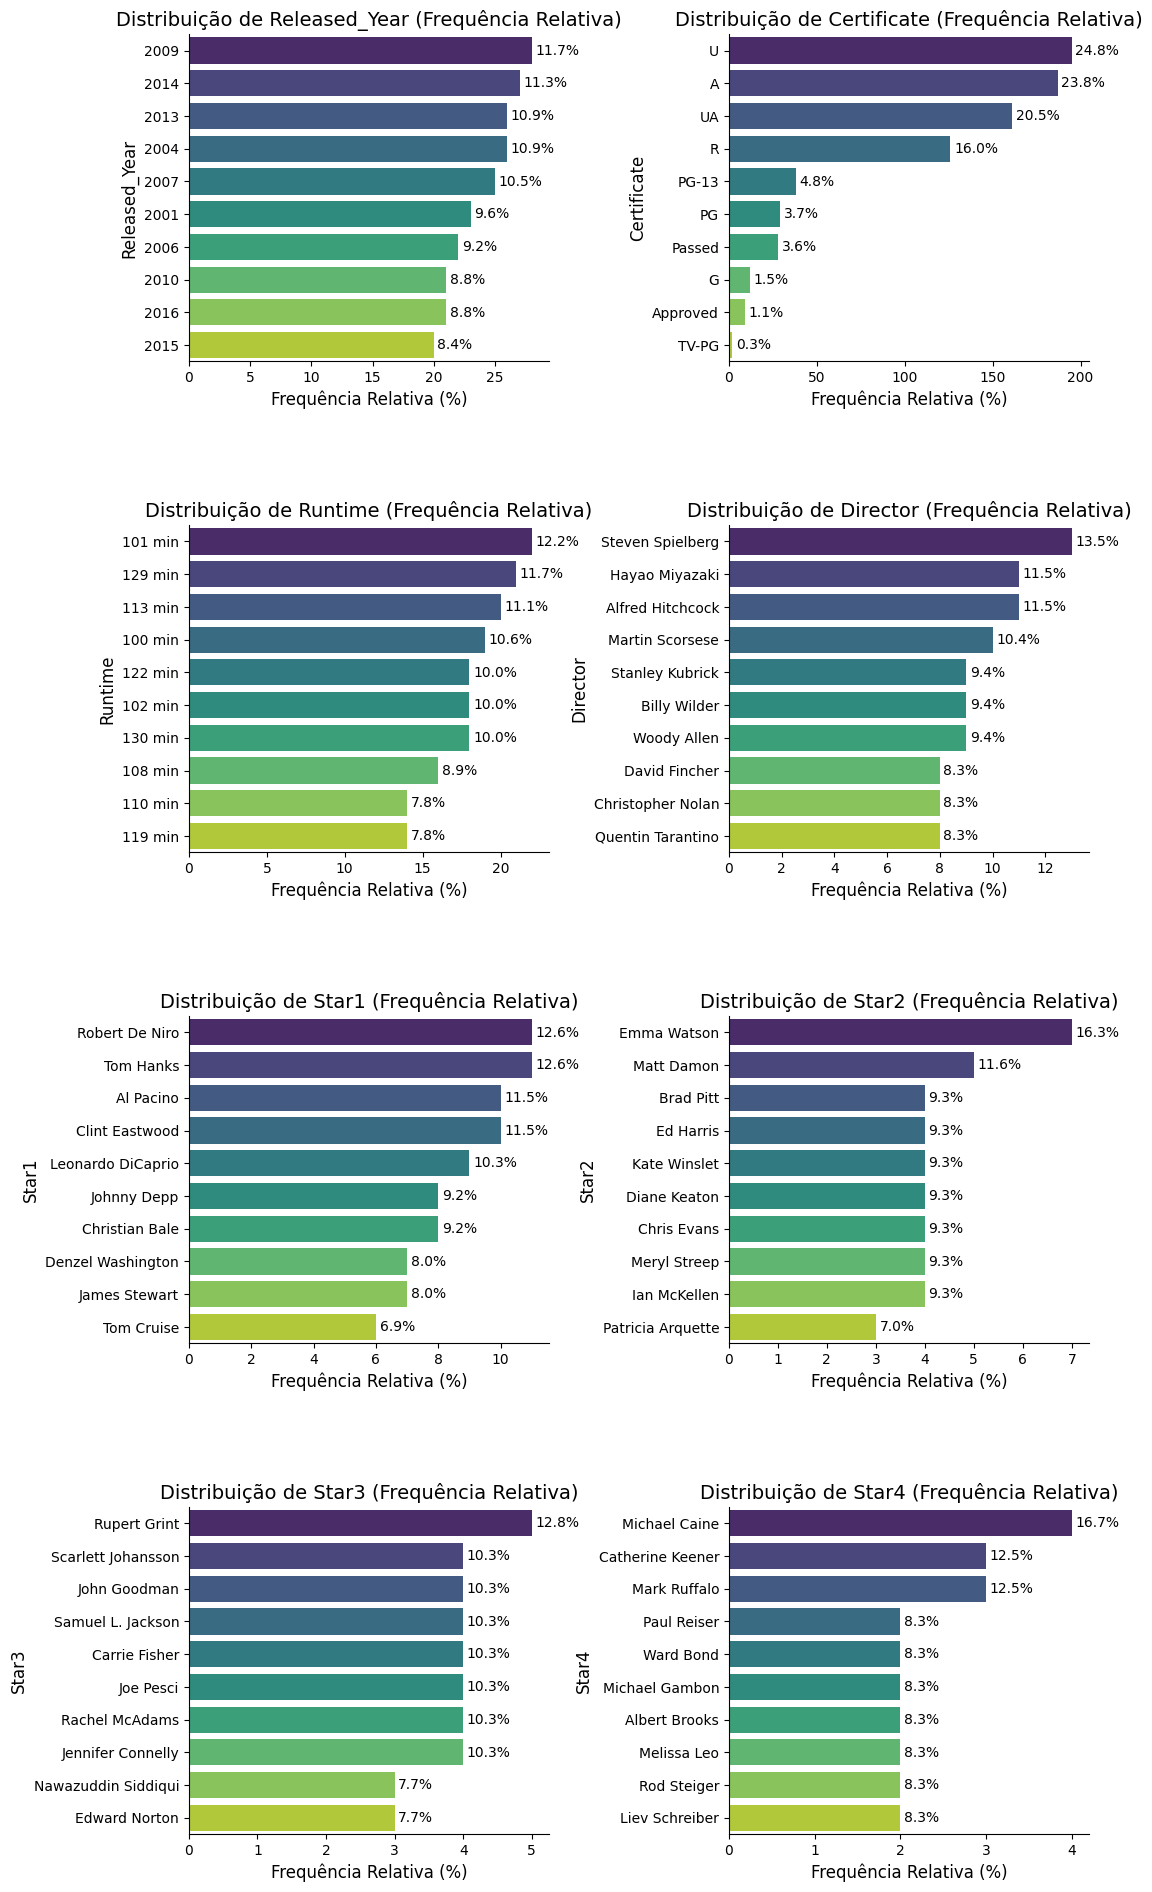

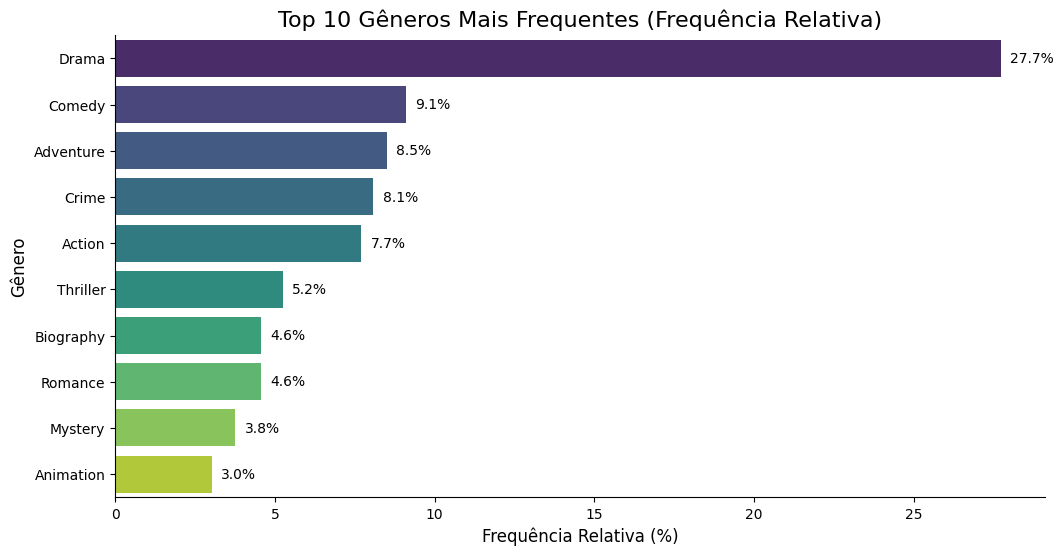

In [44]:
# Selecionando as features categóricas para o plot, excluindo as colunas com muitos valores únicos (ids)
cols_to_plot_categorical = df.select_dtypes(include=['object']).columns.drop(['Series_Title', 'Overview', 'tmdb_id', 'Genre']) # 'Genre' será tratada separadamente

# Determinando o número de linhas e colunas para o subplot
n_cols = 2
n_rows = (len(cols_to_plot_categorical) + n_cols - 1) // n_cols

plt.figure(figsize=(12, n_rows * 5)) # Ajustando o tamanho da figura com base no número de colunas e linhas

for i, col in enumerate(cols_to_plot_categorical):
    plt.subplot(n_rows, n_cols, i + 1)

    # Calculando a frequência absoluta e relativa
    freq_table = df[col].value_counts()
    relative_freq_table = df[col].value_counts(normalize=True)

    # Selecionando os N valores mais frequentes caso haja muitas categorias
    top_n = 10 # Número máximo de categorias a exibir para melhor visualização
    if df[col].nunique() > top_n:
        top_values = freq_table.nlargest(top_n).index
        plotting_df = df[df[col].isin(top_values)]
        order = top_values
    else:
        plotting_df = df.copy()
        order = freq_table.index

    ax = sns.countplot(data=plotting_df, y=col, order=order, palette='viridis') # Usando y para barras horizontais

    plt.title(f'Distribuição de {col} (Frequência Relativa)', fontsize=14)
    plt.xlabel('Frequência Relativa (%)', fontsize=12)
    plt.ylabel(col, fontsize=12)

    # Anotar as barras com porcentagens
    total = len(plotting_df)
    for p in ax.patches:
        width = p.get_width() # Largura da barra horizontal
        percentage = (width / total) * 100 if total > 0 else 0
        ax.text(width + 0.01 * max(ax.get_xlim()), # Posicionar o texto um pouco à direita
                p.get_y() + p.get_height() / 2,
                f'{percentage:.1f}%',
                ha='left', va='center')

    sns.despine(right=True) # Remover bordas desnecessárias do gráfico

# Ajustando o espaçamento entre os subplots
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.2, right=0.95, hspace=0.5, wspace=0.5)
plt.show()

# --- Plotando as frequências individuais de Gêneros com frequência relativa ---

# Calcular a frequência de cada gênero individual
all_genres = df['Genre'].str.split(', ').explode()
genre_counts = all_genres.value_counts()
genre_relative_freq = all_genres.value_counts(normalize=True) * 100 # Frequência relativa em %

# Selecionar os N gêneros mais frequentes
top_n_genres = 10
top_genres_freq = genre_counts.nlargest(top_n_genres)
top_genres_relative_freq = genre_relative_freq.loc[top_genres_freq.index] # Frequência relativa dos gêneros selecionados

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_genres_relative_freq.values, y=top_genres_relative_freq.index, palette='viridis')
plt.title(f'Top {top_n_genres} Gêneros Mais Frequentes (Frequência Relativa)', fontsize=16)
plt.xlabel('Frequência Relativa (%)', fontsize=12)
plt.ylabel('Gênero', fontsize=12)
sns.despine(right=True)

# Anotar as barras com porcentagens
for p in ax.patches:
    width = p.get_width() # Largura da barra horizontal
    ax.text(width + 0.01 * max(ax.get_xlim()), # Posicionar o texto um pouco à direita
            p.get_y() + p.get_height() / 2,
            f'{width:.1f}%', # Mostrar a frequência relativa
            ha='left', va='center')

plt.show()


Insights

---

 🔹 **Gêneros**

* **Domínio absoluto do Drama** (27,7%): pode indicar que o público ou os estúdios tendem a investir mais em narrativas dramáticas, possivelmente por serem mais premiadas ou críticas.
* **Comédia e Aventura (≈9%)** aparecem bem atrás, mas junto com **Crime e Ação** formam os principais gêneros alternativos, o que mostra diversidade.
* **Insight de negócio**: se uma produtora quisesse diversificar o portfólio, poderia mirar gêneros menos saturados (como Animação, 3%) para capturar nichos de mercado.

---

 🔹 **Anos de Lançamento (Released Year)**

* **Concentração nos anos 2000 e 2010**: mostra que o dataset é enviesado para produções mais recentes.
* **Ano 2009 em destaque (11,7%)**: pode ser reflexo de grandes produções lançadas nesse ano.
* **Insight de negócio**: ideal para analisar como tendências de gêneros e certificados mudaram ao longo do tempo — por exemplo, comparar ROI de filmes mais antigos vs. recentes.

---

 🔹 **Duração (Runtime)**

* **Faixa padrão entre 100–130 minutos**: duração mais aceita pelo mercado e pelo público.
* **Picos em 101, 113 e 129 minutos** mostram padrões preferenciais de estúdios.
* **Insight de negócio**: filmes fora dessa faixa podem ter mais risco de performance comercial (muito curtos ou longos demais podem limitar público ou exibições em cinema).

---

🔹 **Certificados (Certificate)**

* **U (Universal) e A (Adulto) representam quase 50%**: há um balanço entre filmes para todos e filmes mais maduros.
* **R (Restricted) com 16%** mostra espaço relevante para conteúdo adulto.
* **Insight de negócio**: segmentar lançamentos conforme certificação pode ajudar em estratégias de marketing (filmes U podem ter maior bilheteria global, enquanto R pode ser nichado mas mais rentável por público fiel).

---

🔹 **Diretores**

* **Spielberg (13,5%)**, **Miyazaki, Hitchcock, Scorsese** entre os mais recorrentes → dataset com diretores consagrados, clássicos e premiados.
* **Insight de negócio**: filmes desses diretores tendem a atrair público pela marca pessoal. Pode-se testar se eles influenciam métricas como **ROI** ou **nota do IMDb**.

---

🔹 **Atores (Stars 1–4)**

* **Protagonistas dominantes**: Robert De Niro e Tom Hanks lideram em papéis principais. Emma Watson (16,3% como Star2) chama atenção, sugerindo forte recorrência em coadjuvantes relevantes.
* **Rupert Grint e Scarlett Johansson** aparecem muito em Star3, mostrando destaque em papéis de suporte.
* **Michael Caine (Star4, 16,7%)** é o coadjuvante mais recorrente.
* **Insight de negócio**: alguns atores têm presença **versátil** (ex: Christian Bale em Star1 e Star2), o que pode aumentar valor de marketing. Outros têm carreira marcada por **papéis de suporte**, mas ainda são importantes para o sucesso do filme.

---

📌 **Resumo estratégico**:

* **Drama domina**, mas há espaço para crescimento em gêneros de nicho.
* **Dataset recente** (anos 2000–2010), ideal para entender padrões modernos.
* **Runtime segue padrão de 100–130min**, sugerindo que esse é o “sweet spot” comercial.
* **Certificados bem distribuídos**, importante para marketing segmentado.
* **Diretores e atores consagrados dominam o dataset**, o que pode enviesar a análise para produções de alto prestígio.

---



## 3. Análise Bivariada

### 3.1 Númericas - Númericas

#### 3.1.1 HeatMap

Matriz de Correlação (Pearson):


IMDB_Rating  Meta_score  No_of_Votes  Gross  Budget  Revenue  \
IMDB_Rating         1.00        0.28         0.53   0.10    0.00     0.11   
Meta_score          0.28        1.00        -0.02  -0.03   -0.12    -0.05   
No_of_Votes         0.53       -0.02         1.00   0.57    0.49     0.56   
Gross               0.10       -0.03         0.57   1.00    0.77     0.95   
Budget              0.00       -0.12         0.49   0.77    1.00     0.82   
Revenue             0.11       -0.05         0.56   0.95    0.82     1.00   
ROI                 0.03        0.06         0.05   0.05   -0.09     0.07   

              ROI  
IMDB_Rating  0.03  
Meta_score   0.06  
No_of_Votes  0.05  
Gross        0.05  
Budget      -0.09  
Revenue      0.07  
ROI          1.00

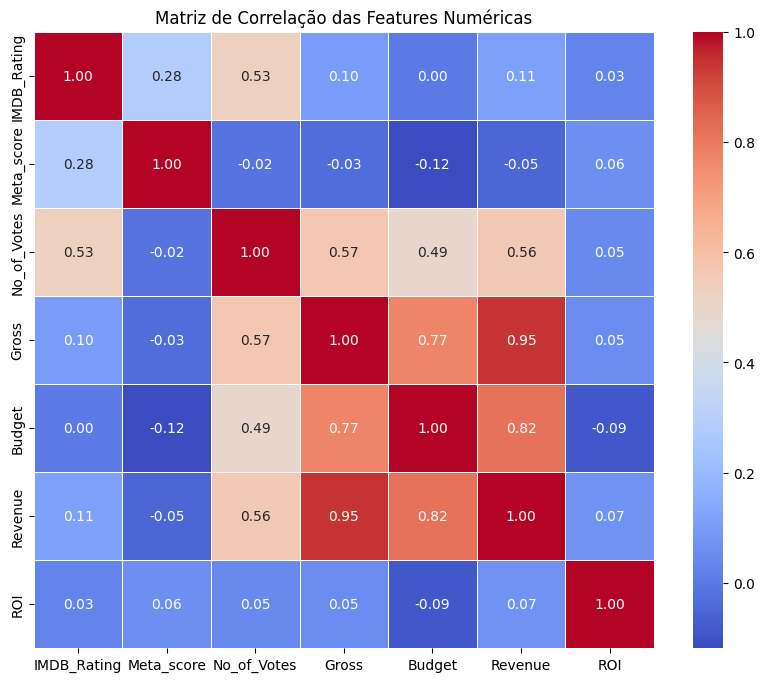

In [42]:
# Análise Bivariada - Variáveis Numéricas

# Seleciona apenas as colunas numéricas
numerical_cols = df.select_dtypes(include=np.number).columns

# Exclui colunas que não fazem sentido para a análise de correlação numérica, se houver
# Neste caso, vamos excluir 'Unnamed: 0' se ainda existir e 'tmdb_id' se for numérica (embora seja object)
# Vamos garantir que 'tmdb_id' não esteja na lista de colunas numéricas
cols_to_exclude = ['Unnamed: 0', 'tmdb_id']
numerical_cols_for_corr = [col for col in numerical_cols if col not in cols_to_exclude]

correlation_matrix = df[numerical_cols_for_corr].corr(method='pearson') # Pode usar 'spearman' também

# Exibe a matriz de correlação
print("Matriz de Correlação (Pearson):")
display(correlation_matrix)

# Opcional: Visualizar a matriz de correlação com um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação das Features Numéricas')
plt.show()

#### 3.1.2 Scatter, Regplot , Hexbin, Jointplot e Pairplots

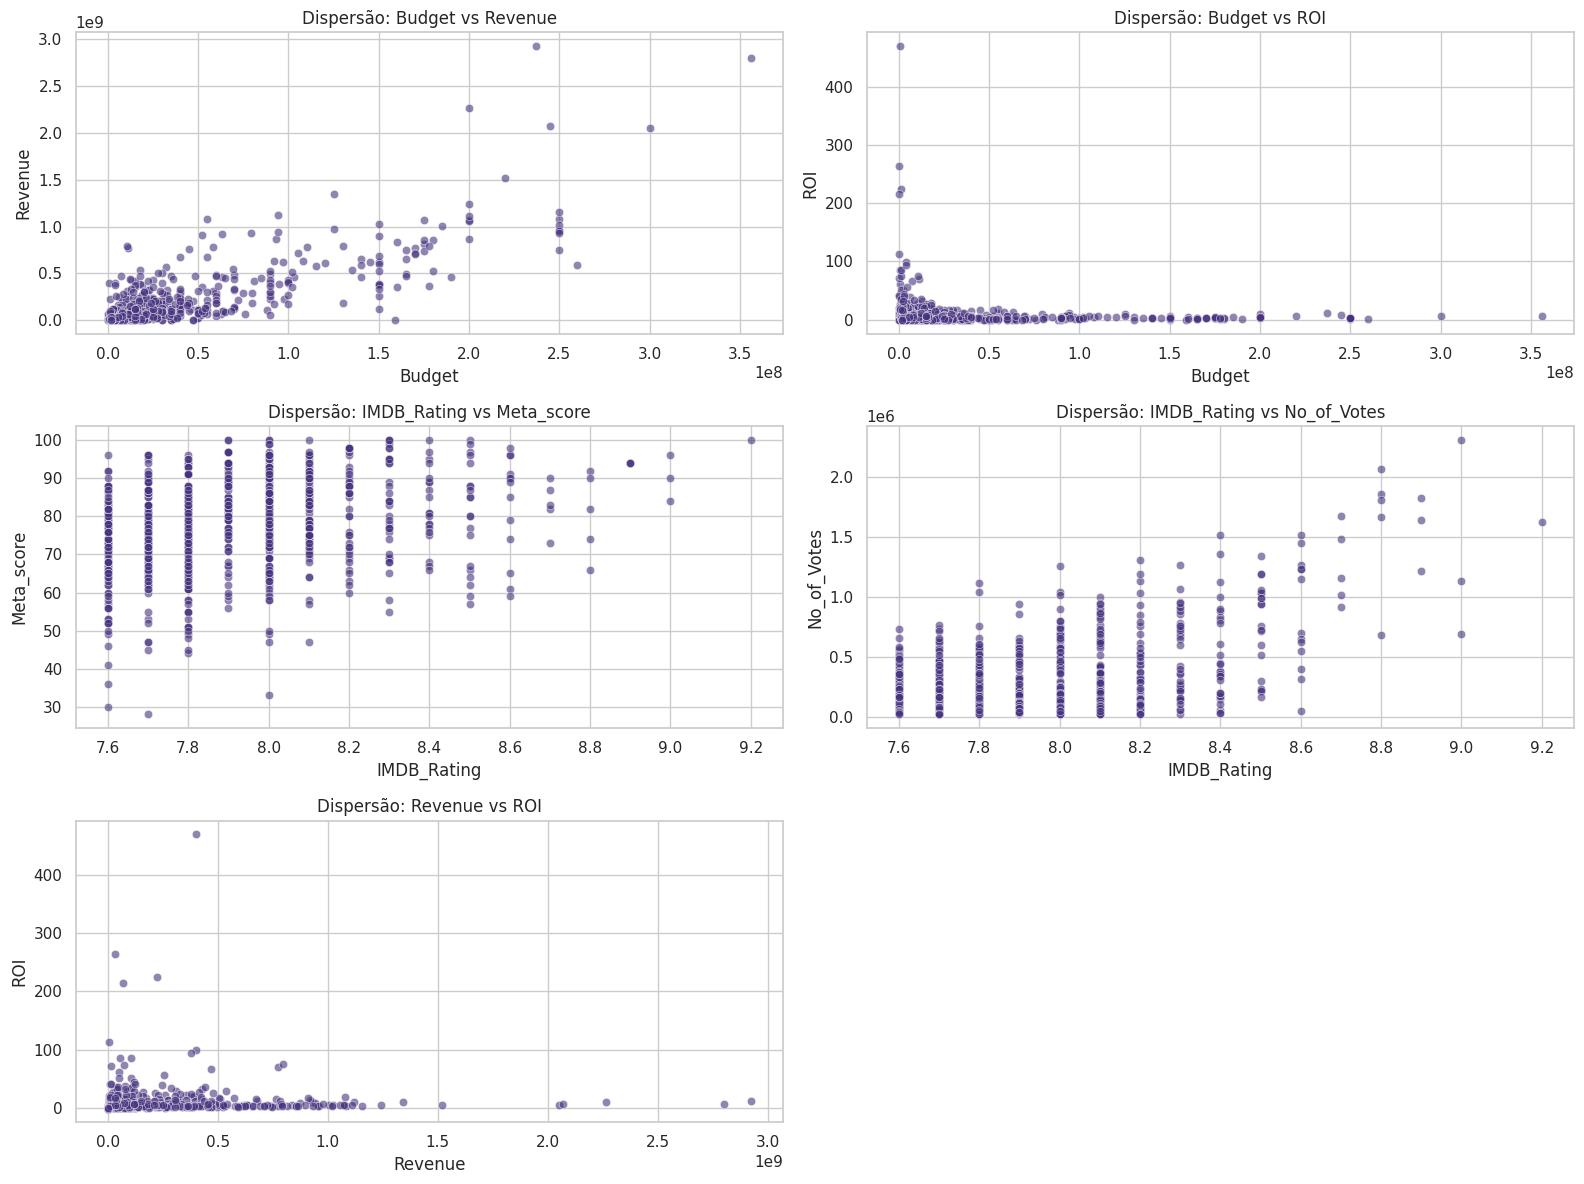

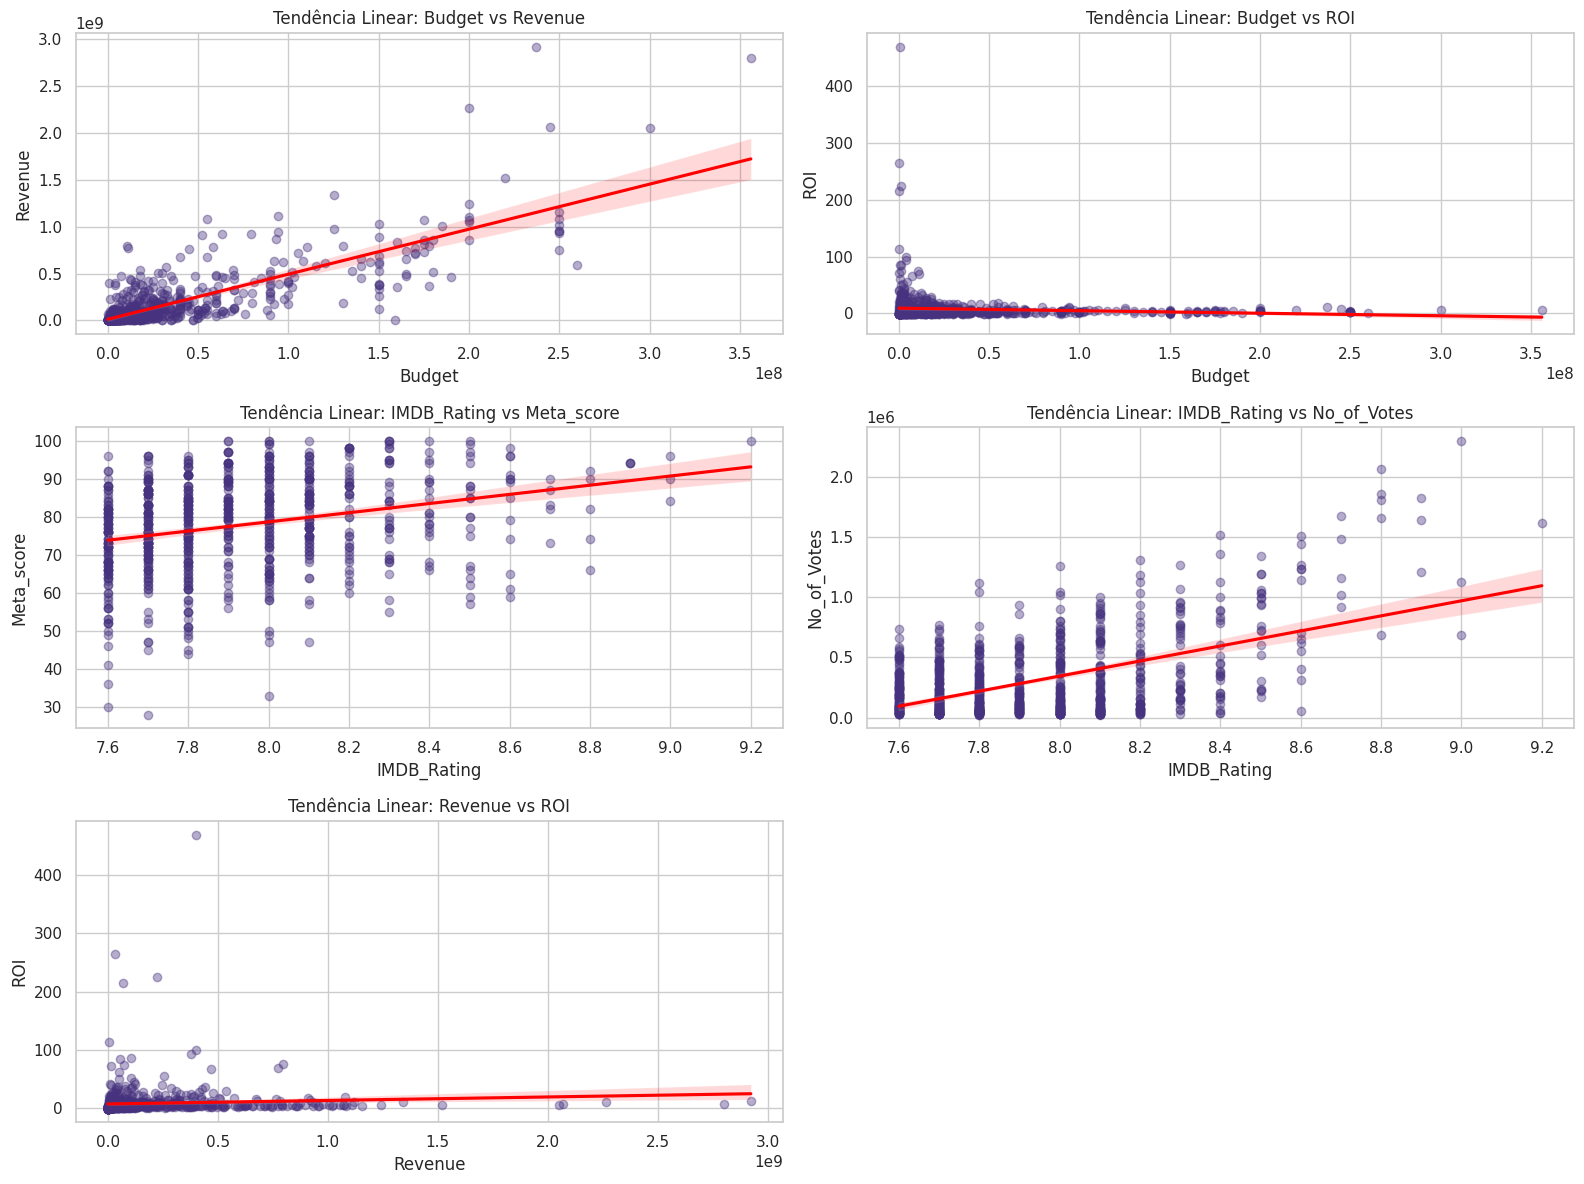

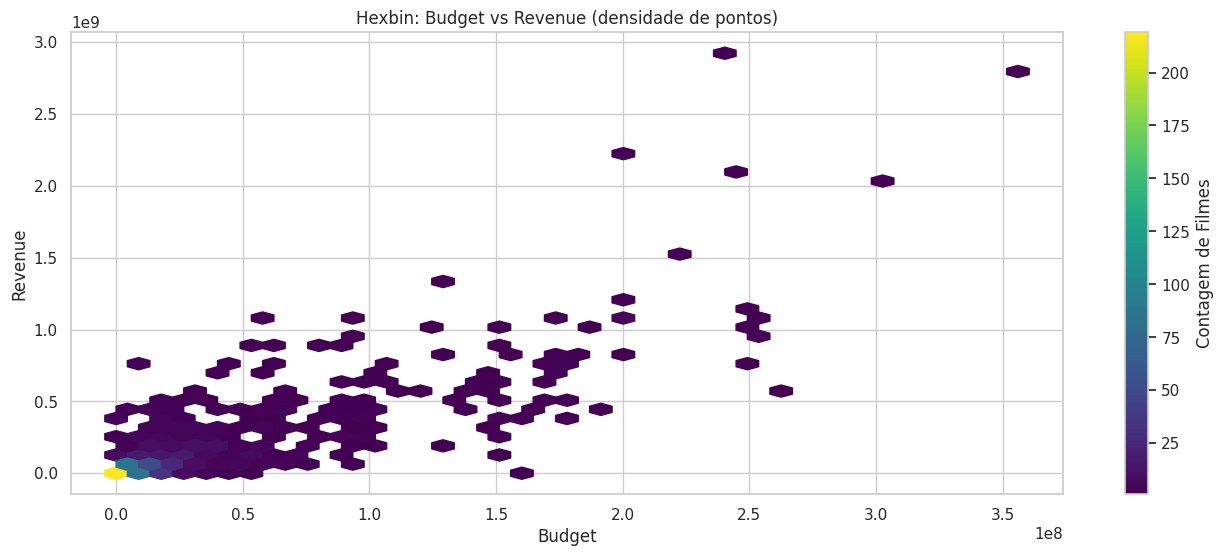

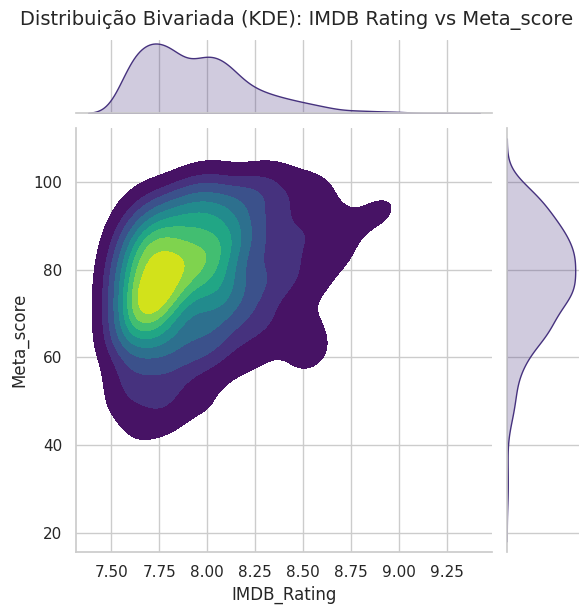

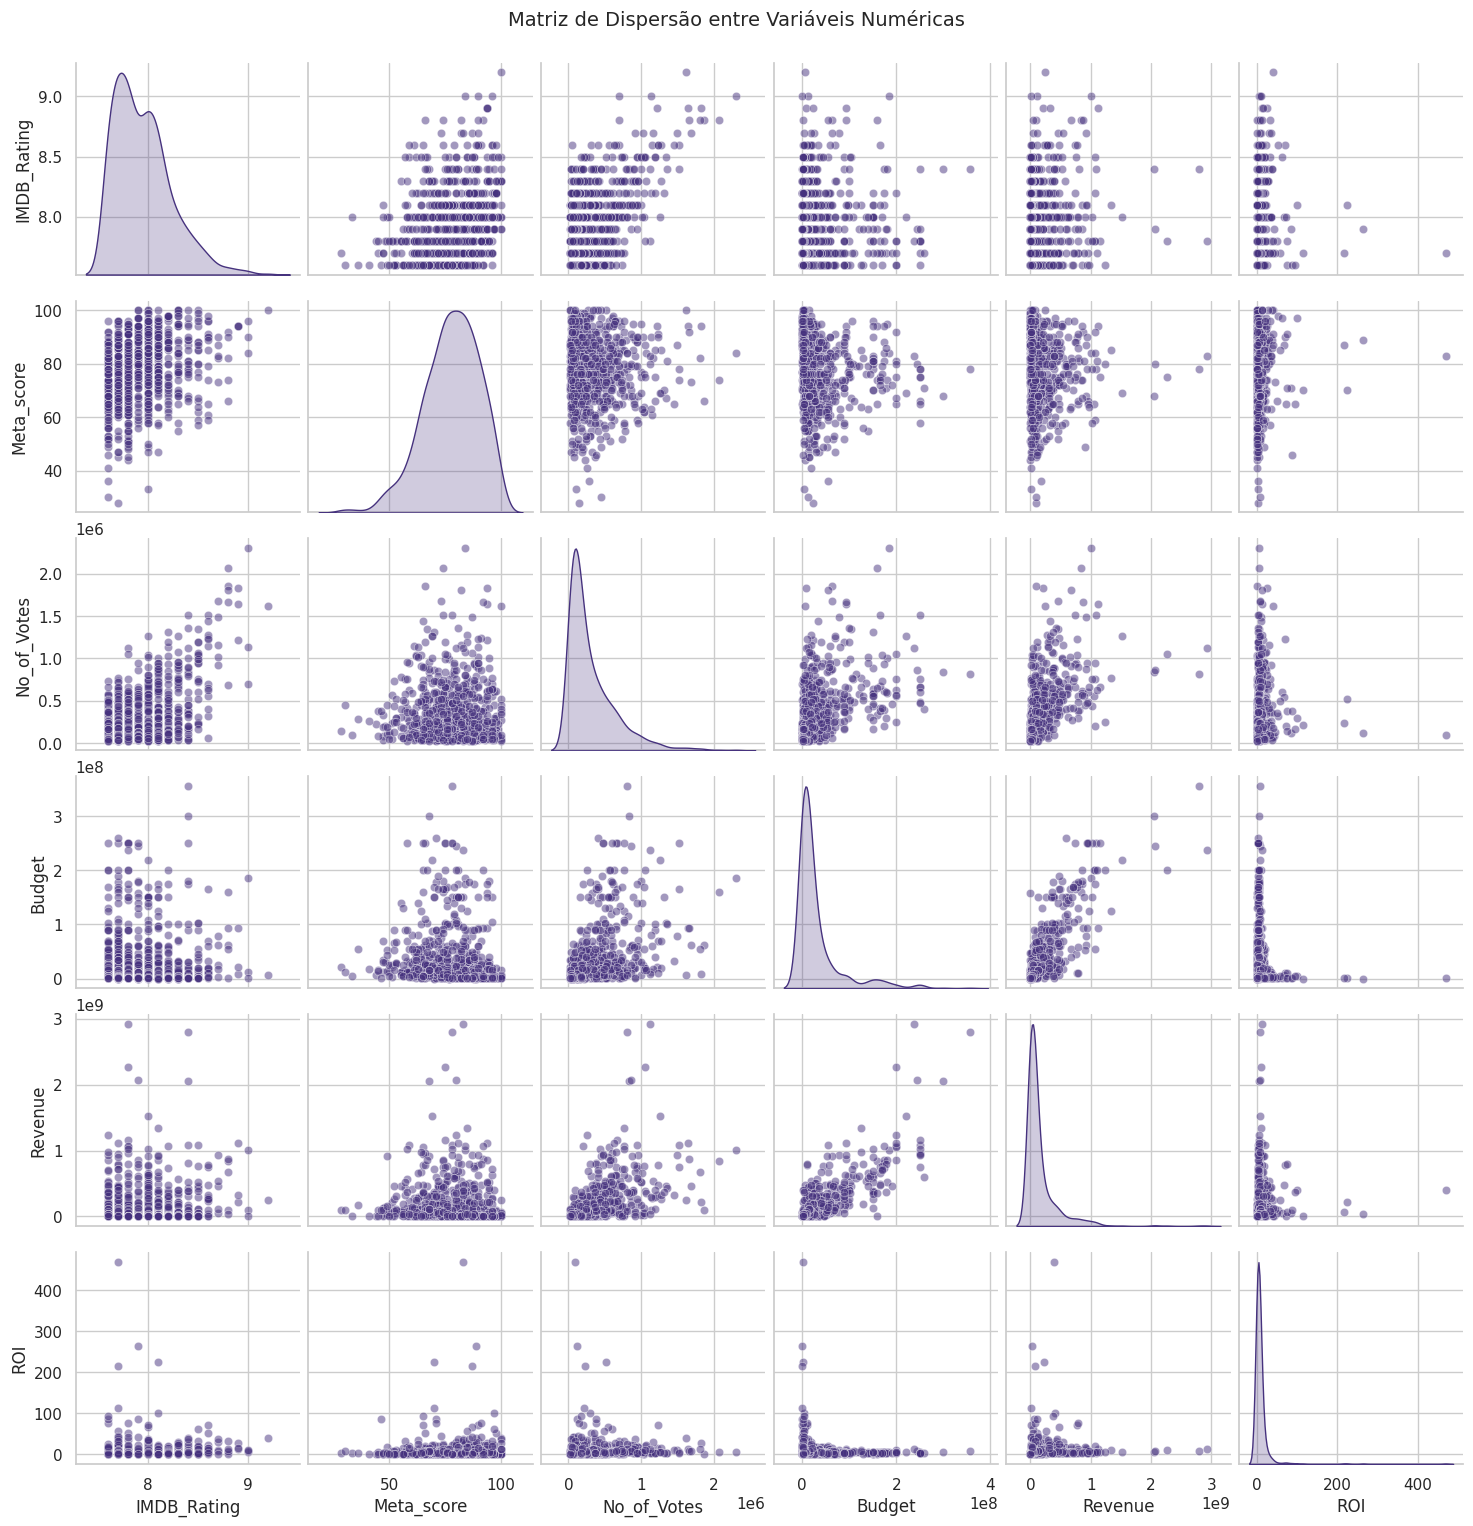

In [45]:
# Definindo estilo geral
sns.set(style="whitegrid", palette="viridis")

# ================================
# 1. SCATTER PLOTS (pares relevantes)
# ================================
pairs = [
    ("Budget", "Revenue"),
    ("Budget", "ROI"),
    ("IMDB_Rating", "Meta_score"),
    ("IMDB_Rating", "No_of_Votes"),
    ("Revenue", "ROI"),
]

plt.figure(figsize=(16, 12))
for i, (x, y) in enumerate(pairs, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(data=df, x=x, y=y, alpha=0.6)
    plt.title(f"Dispersão: {x} vs {y}", fontsize=12)

plt.tight_layout()
plt.show()


# ================================
# 2. REGPLOTS (tendência linear)
# ================================
plt.figure(figsize=(16, 12))
for i, (x, y) in enumerate(pairs, 1):
    plt.subplot(3, 2, i)
    sns.regplot(data=df, x=x, y=y, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
    plt.title(f"Tendência Linear: {x} vs {y}", fontsize=12)

plt.tight_layout()
plt.show()


# ================================
# 3. HEXBIN (para dados concentrados)
# ================================
plt.figure(figsize=(16, 6))
plt.hexbin(df["Budget"], df["Revenue"], gridsize=40, cmap="viridis", mincnt=1)
plt.colorbar(label="Contagem de Filmes")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.title("Hexbin: Budget vs Revenue (densidade de pontos)")
plt.show()


# ================================
# 4. KDE JOINTPLOTS (distribuição bivariada)
# ================================
sns.jointplot(data=df, x="IMDB_Rating", y="Meta_score", kind="kde", fill=True, cmap="viridis", height=6)
plt.suptitle("Distribuição Bivariada (KDE): IMDB Rating vs Meta_score", y=1.02, fontsize=14)
plt.show()


# ================================
# 5. PAIRPLOT (visão geral de várias variáveis numéricas)
# ================================
numeric_cols = ["IMDB_Rating", "Meta_score", "No_of_Votes", "Budget", "Revenue", "ROI"]
sns.pairplot(df[numeric_cols], diag_kind="kde", plot_kws={'alpha':0.5})
plt.suptitle("Matriz de Dispersão entre Variáveis Numéricas", y=1.02, fontsize=14)
plt.show()


Como os dados apresentam escalas muito diferentes e distribuições assimétricas com cauda longa à direita, optei por aplicar a transformação logarítmica. Essa abordagem permite reduzir a influência de valores extremos e escalonar as variáveis, facilitando a interpretação visual e a identificação de padrões.


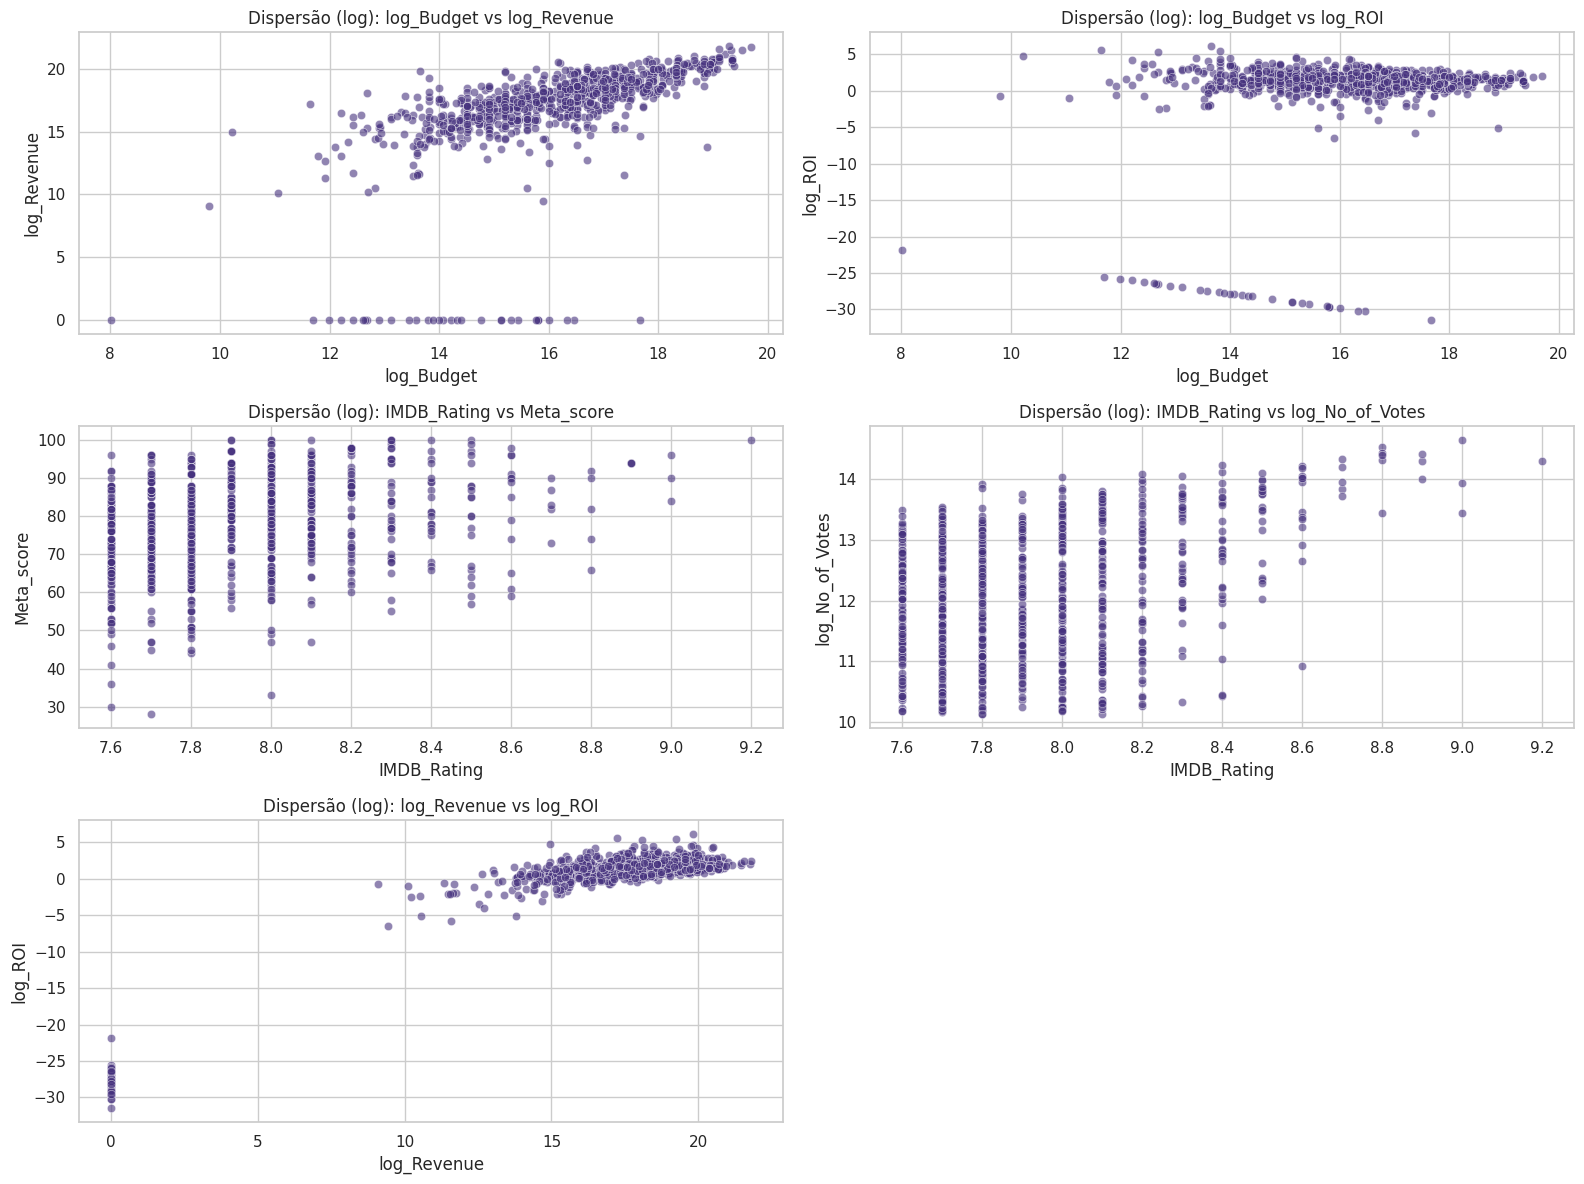

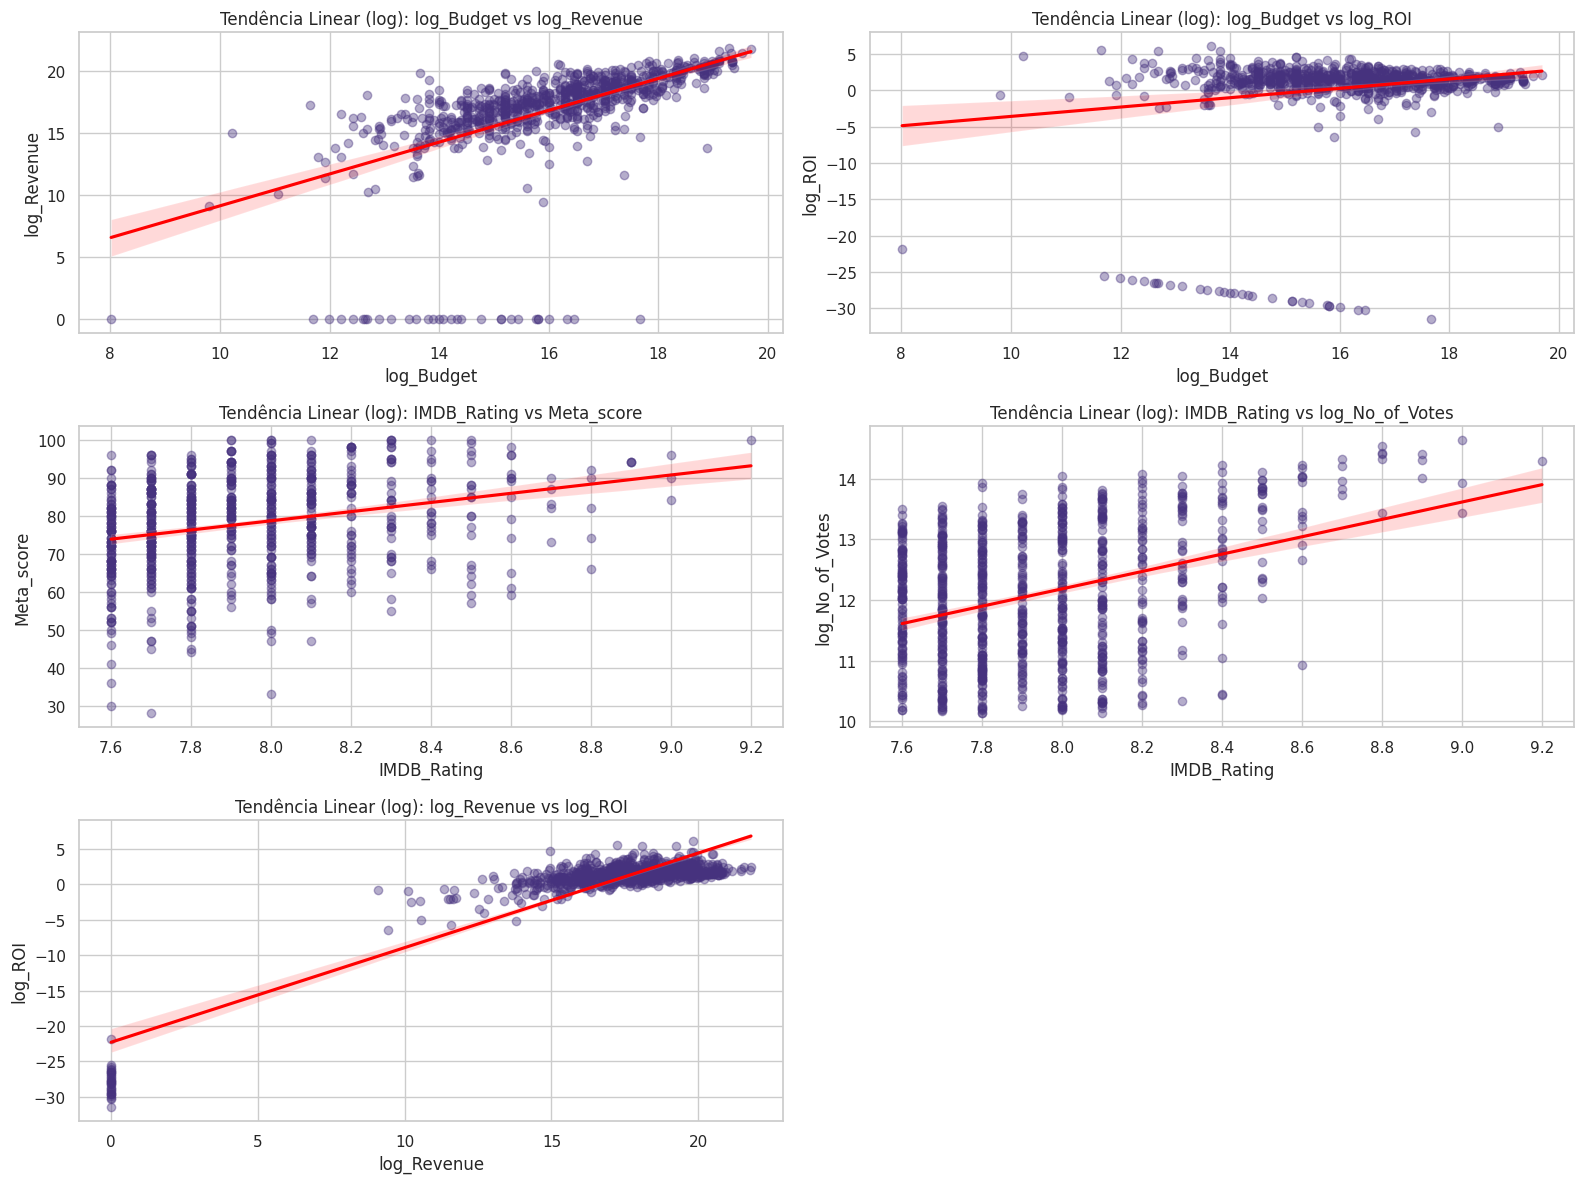

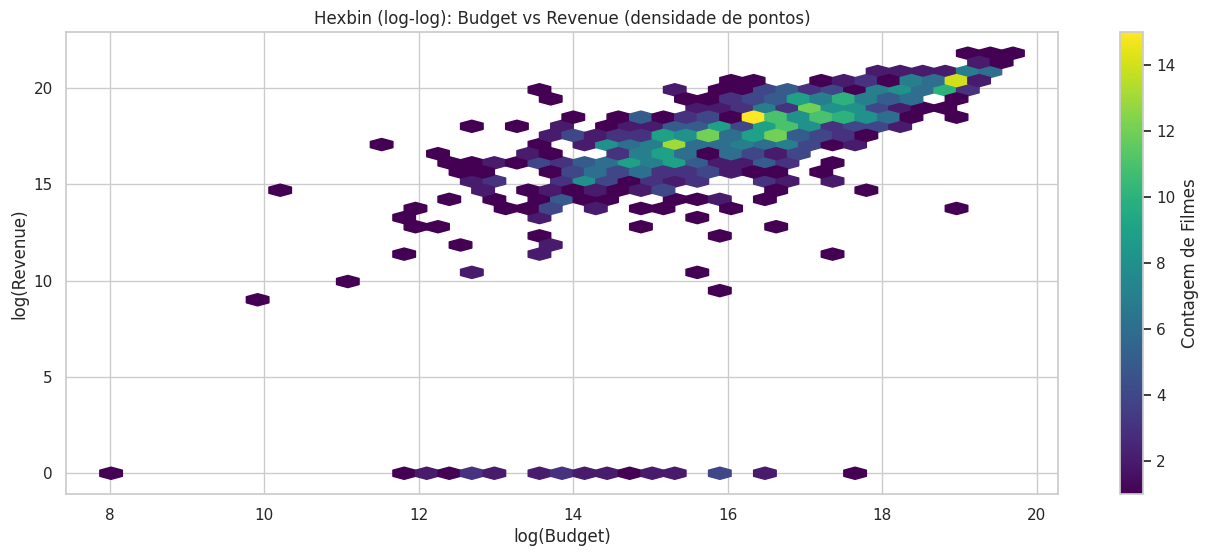

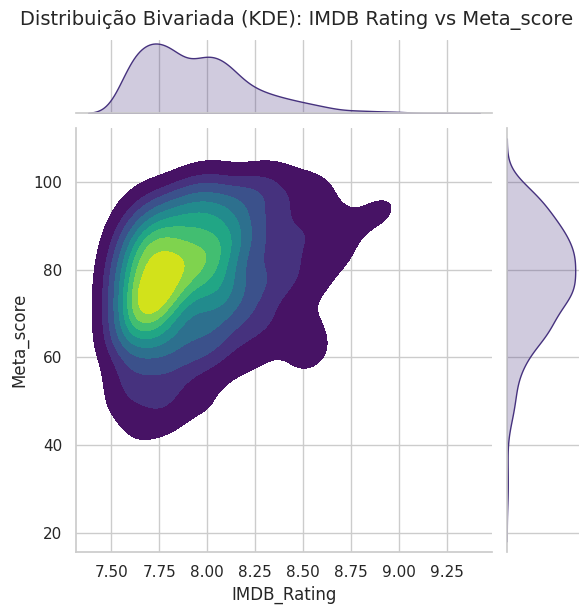

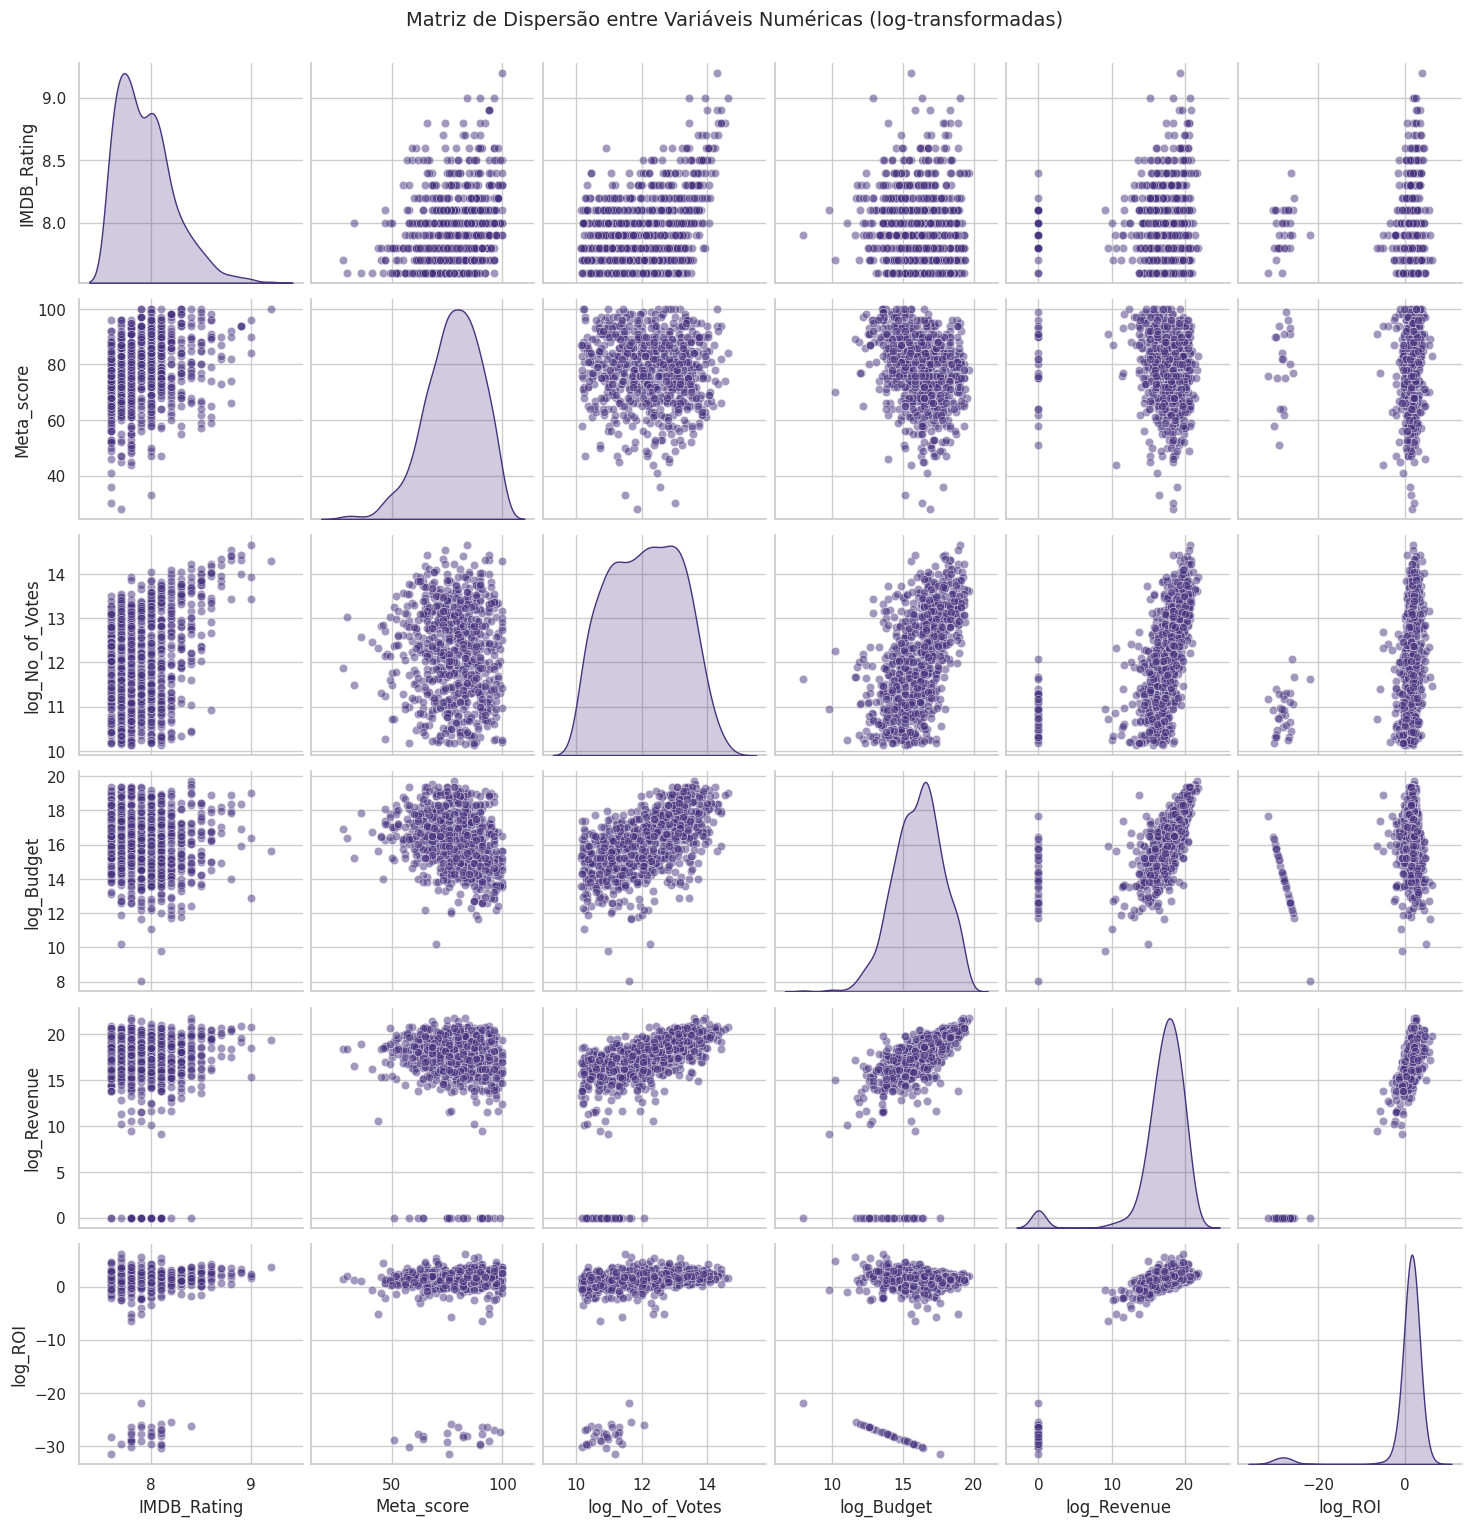

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Copiando o dataframe com variáveis transformadas
df_log = df.copy()
for col in ["Budget", "Revenue", "ROI", "No_of_Votes"]:
    df_log[f"log_{col}"] = np.log1p(df_log[col])

# Definindo estilo geral
sns.set(style="whitegrid", palette="viridis")

# ================================
# 1. SCATTER PLOTS (pares relevantes, com log)
# ================================
pairs = [
    ("log_Budget", "log_Revenue"),
    ("log_Budget", "log_ROI"),
    ("IMDB_Rating", "Meta_score"),
    ("IMDB_Rating", "log_No_of_Votes"),
    ("log_Revenue", "log_ROI"),
]

plt.figure(figsize=(16, 12))
for i, (x, y) in enumerate(pairs, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(data=df_log, x=x, y=y, alpha=0.6)
    plt.title(f"Dispersão (log): {x} vs {y}", fontsize=12)

plt.tight_layout()
plt.show()

# ================================
# 2. REGPLOTS (tendência linear com log)
# ================================
plt.figure(figsize=(16, 12))
for i, (x, y) in enumerate(pairs, 1):
    plt.subplot(3, 2, i)
    sns.regplot(data=df_log, x=x, y=y, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
    plt.title(f"Tendência Linear (log): {x} vs {y}", fontsize=12)

plt.tight_layout()
plt.show()

# ================================
# 3. HEXBIN (Budget vs Revenue com log)
# ================================
plt.figure(figsize=(16, 6))
plt.hexbin(df_log["log_Budget"], df_log["log_Revenue"], gridsize=40, cmap="viridis", mincnt=1)
plt.colorbar(label="Contagem de Filmes")
plt.xlabel("log(Budget)")
plt.ylabel("log(Revenue)")
plt.title("Hexbin (log-log): Budget vs Revenue (densidade de pontos)")
plt.show()

# ================================
# 4. KDE JOINTPLOTS (sem log pois já estão em escala comparável)
# ================================
sns.jointplot(data=df_log, x="IMDB_Rating", y="Meta_score", kind="kde", fill=True, cmap="viridis", height=6)
plt.suptitle("Distribuição Bivariada (KDE): IMDB Rating vs Meta_score", y=1.02, fontsize=14)
plt.show()

# ================================
# 5. PAIRPLOT (versão com log)
# ================================
numeric_cols_log = ["IMDB_Rating", "Meta_score", "log_No_of_Votes", "log_Budget", "log_Revenue", "log_ROI"]
sns.pairplot(df_log[numeric_cols_log], diag_kind="kde", plot_kws={'alpha':0.5})
plt.suptitle("Matriz de Dispersão entre Variáveis Numéricas (log-transformadas)", y=1.02, fontsize=14)
plt.show()


#### Insights
---

# 📊 Insights Finais (antes x depois da transformação log)

## 1. **Budget vs Revenue**

* **Antes**: relação positiva clara, mas dominada por outliers (blockbusters). Parecia que só grandes filmes davam retorno.
* **Depois (log-log)**: a relação ficou **mais linear e proporcional**. Mostra que, em média, **aumentar o budget realmente aumenta o revenue em escala relativa**, e não apenas em valores absolutos.
  - 👉 **Insight final**: filmes com maior orçamento tendem a arrecadar mais, mas de forma proporcional — a escala log evidencia esse padrão sem distorções.

---

## 2. **Budget vs ROI**

* **Antes**: parecia não haver relação (reta quase horizontal).
* **Depois (log-log)**: percebe-se que **filmes de baixo orçamento concentram os maiores ROIs**, enquanto filmes caros apresentam ROIs medianos, mas estáveis.
   - 👉 **Insight final**: blockbusters são bons em receita absoluta, mas o retorno relativo (ROI) é mais comum em produções menores.

---

## 3. **Revenue vs ROI**

* **Antes**: relação pouco clara, dispersão enorme.
* **Depois (log-log)**: fica evidente que **quanto maior o revenue, maior tende a ser o ROI** (apesar de haver exceções). O cluster de filmes com fracasso comercial (revenue ≈ 0) ficou mais visível.
  👉 **Insight final**: filmes que performam bem em bilheteria também conseguem ROIs melhores, e fracassos aparecem claramente após a transformação.

---

## 4. **IMDB Rating vs Meta\_score**

* **Antes**: correlação positiva suave, mas dispersa.
* **Depois (sem log necessário)**: padrão se manteve, confirmando que **filmes com boas notas do público também são bem avaliados pela crítica**, mas não de forma perfeita.
  - 👉 **Insight final**: há alinhamento moderado entre público e crítica.

---

## 5. **IMDB Rating vs No\_of\_Votes**

* **Antes**: difícil visualizar devido a filmes com milhões de votos que esmagavam a escala.
* **Depois (log Votes)**: padrão claro de **relação positiva exponencial** → filmes com melhores notas atraem muito mais votos.
  - 👉 **Insight final**: popularidade escala de forma logarítmica: boas avaliações atraem engajamento de forma desproporcional.

---

## 6. **Matriz de Dispersão**

* **Antes**: padrões ocultos pelos outliers.
* **Depois (log-transformações)**:

  * `Budget ~ Revenue`: correlação forte.
  * `Revenue ~ ROI`: positiva, mas com dispersão.
  * `IMDB_Rating ~ No_of_Votes`: relação clara.
    - 👉 **Insight final**: a transformação log trouxe à tona **estruturas de correlação escondidas** e centralizou os dados comuns, revelando padrões mais reais.

---

# 🎯 Conclusão Geral

* **Sem log**: os gráficos mostravam relações, mas os **outliers dominavam a interpretação**, mascarando o comportamento da maioria dos filmes.
* **Com log**: ficou claro que:

  * O **budget escala o revenue proporcionalmente**.
  * **ROI elevado ocorre mais em filmes de baixo custo**.
  * **Sucesso de bilheteria gera ROI maior**, mas nem sempre.
  * **Notas boas atraem engajamento em escala logarítmica**.
  * **Crítica e público estão moderadamente alinhados**.

👉 **Insight de negócio**:

* Investir alto aumenta receita absoluta, mas não garante ROI excepcional.
* Filmes menores podem ser muito mais lucrativos proporcionalmente.
* Filmes bem avaliados pelo público tendem a ganhar mais tração (votos, visibilidade).

---



#### 3.1.3 Validando com hipóteses

In [66]:
from scipy.stats import pearsonr, spearmanr

# Pares de interesse (Numeric ↔ Numeric)
pairs = [
    ("Budget", "Revenue"),
    ("Budget", "ROI"),
    ("Revenue", "ROI"),
    ("IMDB_Rating", "Revenue"),
    ("IMDB_Rating", "ROI"),
    ("IMDB_Rating", "Meta_score"),
    ("IMDB_Rating", "No_of_Votes"),
]

def run_tests(df, pairs):
    results = []
    for x, y in pairs:
        # Remove NaN
        data = df[[x, y]].dropna()

        # Pearson
        pearson_corr, pearson_p = pearsonr(data[x], data[y])

        # Spearman
        spearman_corr, spearman_p = spearmanr(data[x], data[y])

        # Interpretação automática
        interpret = []
        if pearson_p < 0.05:
            interpret.append(f"Pearson: relação significativa")
        else:
            interpret.append("Pearson: sem evidência de relação significativa")

        if spearman_p < 0.05:
            interpret.append(f"Spearman: relação significativa")
        else:
            interpret.append("Spearman: sem evidência de relação significativa")

        results.append({
            "Var1": x,
            "Var2": y,
            "Pearson_r": pearson_corr,
            "Pearson_p": pearson_p,
            "Spearman_r": spearman_corr,
            "Spearman_p": spearman_p,
            "Interpretação": " | ".join(interpret)
        })

    return pd.DataFrame(results)

# Rodando os testes
hypothesis_results = run_tests(df, pairs)
display(hypothesis_results)


Var1         Var2  Pearson_r  Pearson_p  Spearman_r  Spearman_p  \
0       Budget      Revenue       0.82       0.00        0.77        0.00   
1       Budget          ROI      -0.09       0.01       -0.04        0.21   
2      Revenue          ROI       0.07       0.03        0.54        0.00   
3  IMDB_Rating      Revenue       0.11       0.00       -0.00        0.96   
4  IMDB_Rating          ROI       0.03       0.40        0.13        0.00   
5  IMDB_Rating   Meta_score       0.28       0.00        0.29        0.00   
6  IMDB_Rating  No_of_Votes       0.53       0.00        0.29        0.00   

                                       Interpretação  
0  Pearson: relação significativa | Spearman: rel...  
1  Pearson: relação significativa | Spearman: sem...  
2  Pearson: relação significativa | Spearman: rel...  
3  Pearson: relação significativa | Spearman: sem...  
4  Pearson: sem evidência de relação significativ...  
5  Pearson: relação significativa | Spearman: rel...  
6  Pearson: relação significativa | Spearman: rel...

In [67]:
# Display the full content of the 'Interpretação' column
for index, row in hypothesis_results.iterrows():
    print(f"Row {index}: {row['Interpretação']}\n")

Row 0: Pearson: relação significativa | Spearman: relação significativa

Row 1: Pearson: relação significativa | Spearman: sem evidência de relação significativa

Row 2: Pearson: relação significativa | Spearman: relação significativa

Row 3: Pearson: relação significativa | Spearman: sem evidência de relação significativa

Row 4: Pearson: sem evidência de relação significativa | Spearman: relação significativa

Row 5: Pearson: relação significativa | Spearman: relação significativa

Row 6: Pearson: relação significativa | Spearman: relação significativa



---

#### 🔹 Insights Resumidos (Numeric ↔ Numeric)

#### 1. **Budget ↔ Revenue**

* **Resultado:** correlação forte (Pearson r=0.82, Spearman ρ=0.77), ambas significativas.
* **Insight:** quanto maior o orçamento, maior a receita. Investir pesado tende a trazer retorno em **valor absoluto**.
  👉 *Blockbusters funcionam para escalar bilheteria.*

---

#### 2. **Budget ↔ ROI**

* **Resultado:** correlação negativa fraca (Pearson r=-0.09, p=0.01), Spearman sem evidência.
* **Insight:** existe um indício de que **filmes de baixo orçamento têm ROIs proporcionalmente maiores**, mas a relação é fraca e não monotônica.
  👉 *Produções menores podem surpreender, mas o padrão não é consistente.*

---

#### 3. **Revenue ↔ ROI**

* **Resultado:** Pearson fraco (r=0.07), Spearman moderado (ρ=0.54), ambos significativos.
* **Insight:** filmes que arrecadam muito **tendem também a ter bons ROIs** — não apenas faturamento bruto.
  👉 *Sucesso absoluto costuma vir junto de sucesso relativo.*

---

#### 4. **IMDB Rating ↔ Revenue**

* **Resultado:** Pearson positivo fraco (r=0.11, p<0.001), Spearman sem evidência.
* **Insight:** notas do público têm **pouco impacto direto na bilheteria**.
  👉 *Marketing, distribuição e hype são mais determinantes para receita do que a qualidade percebida.*

---

#### 5. **IMDB Rating ↔ ROI**

* **Resultado:** Pearson não significativo, Spearman positivo fraco (ρ=0.13, p<0.001).
* **Insight:** filmes bem avaliados podem gerar ROI levemente maior, mas a evidência é fraca.
  👉 *Qualidade percebida pode ajudar na lucratividade, mas não é fator decisivo.*

---

#### 6. **IMDB Rating ↔ Meta\_score**

* **Resultado:** correlação moderada (Pearson r=0.28, Spearman ρ=0.29), ambas significativas.
* **Insight:** público e crítica estão **moderadamente alinhados**.
  👉 *Um filme elogiado pela crítica tende a ser bem visto pelo público, mas não é regra.*

---

#### 7. **IMDB Rating ↔ No\_of\_Votes**

* **Resultado:** Pearson forte (r=0.53), Spearman moderado (ρ=0.29), ambos significativos.
* **Insight:** quanto maior a nota, mais votos o filme recebe → **qualidade percebida gera engajamento**.
  👉 *Bom sinal de boca-a-boca e longevidade no mercado.*

---

# 🔑 Conclusão

* **Investimento (Budget → Revenue):** confirma que gastar mais rende mais receita.
* **Rentabilidade (Budget/Revenue ↔ ROI):** blockbusters entregam bilheteria, mas indies ainda podem ser mais lucrativos em proporção.
* **Qualidade percebida (IMDB):** ajuda no engajamento e na imagem, mas não garante bilheteria ou lucro.
* **Crítica vs Público:** alinhamento moderado → crítica importa, mas o público é soberano para tração comercial.

---


### 3.2 Categóricas - Categóricas

#### 3.2.1 Crosstab com heatmap


🔹 Certificate x all_genres


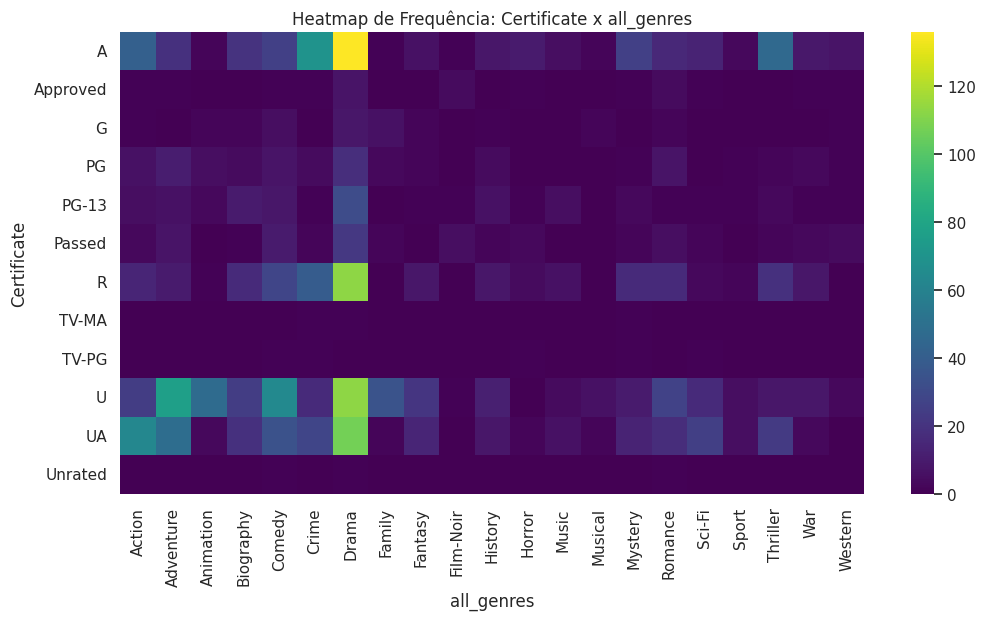


🔹 Decade x all_genres


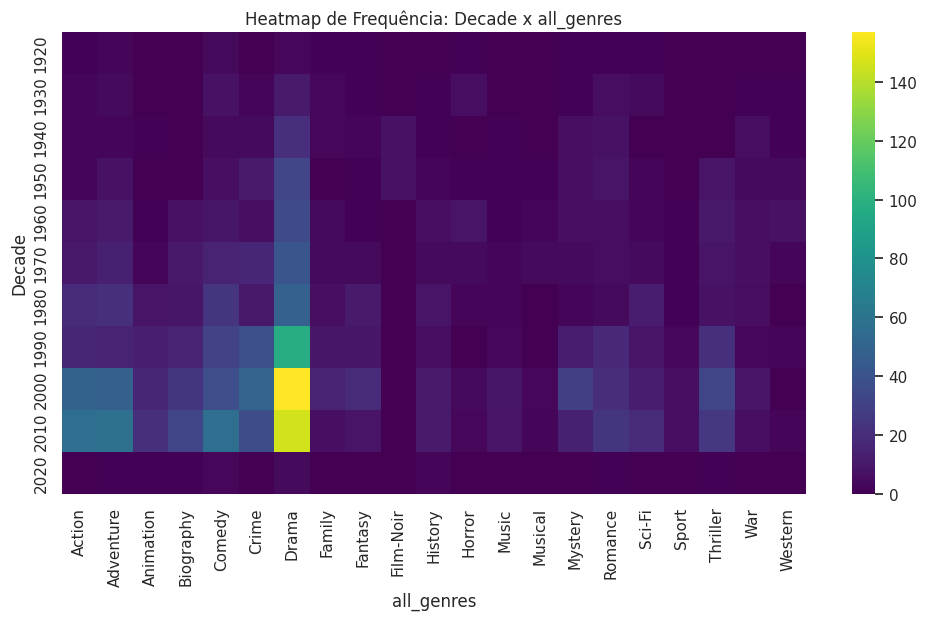


🔹 Runtime x all_genres


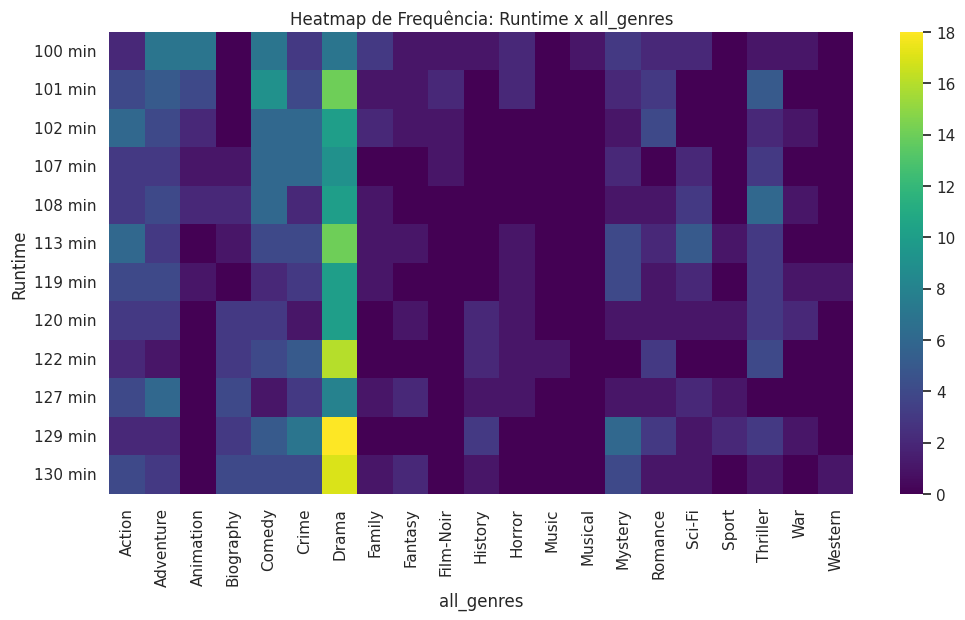


🔹 Director x all_genres


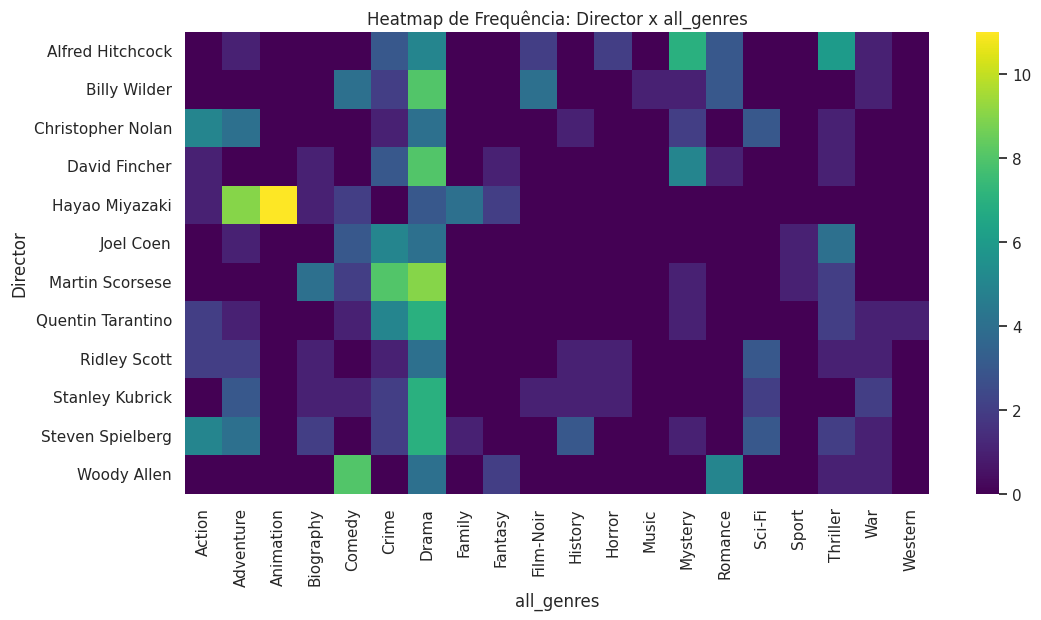


🔹 Star1 x all_genres


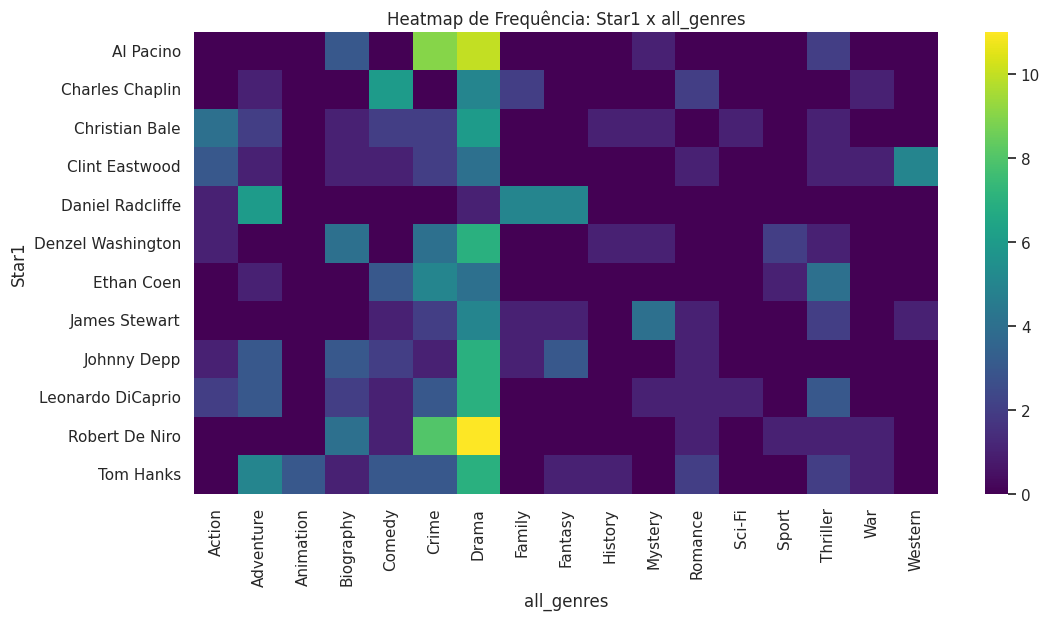


🔹 Star2 x all_genres


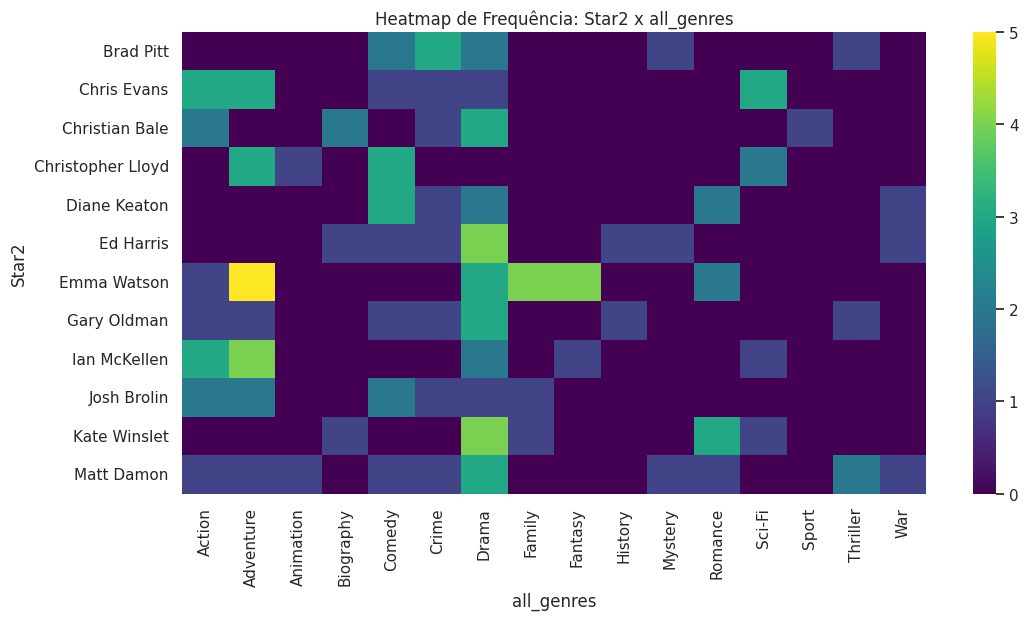


🔹 Star3 x all_genres


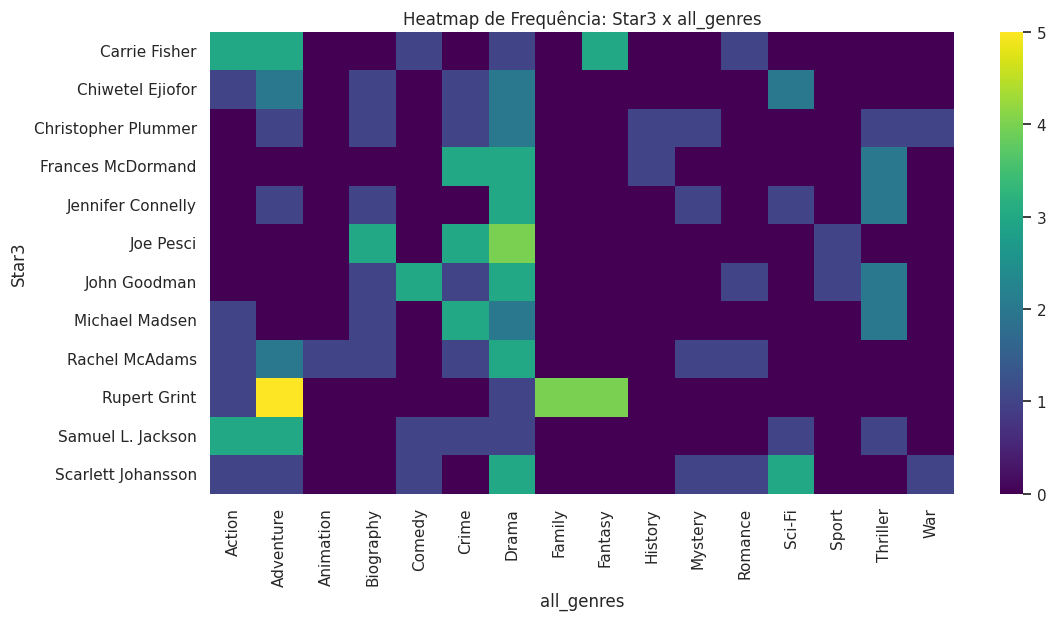


🔹 Star4 x all_genres


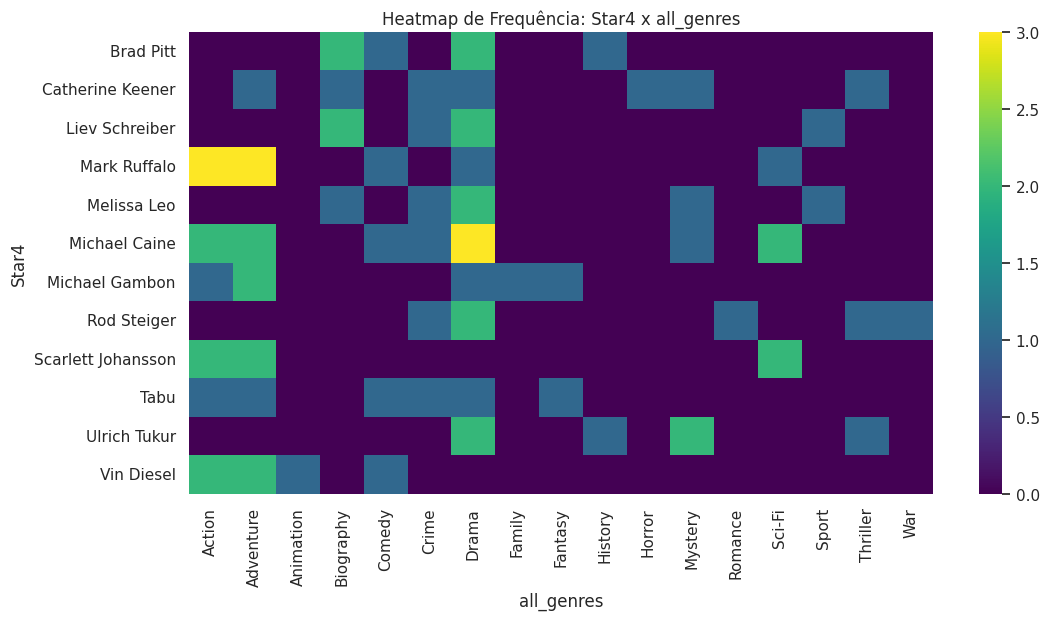

In [50]:
# Garante que Released_Year está numérico e cria Década (Agrupamento dos anos em décadas)
df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")
df["Decade"] = (df["Released_Year"] // 10) * 10

# Explode all_genres
df_exploded = df.assign(all_genres=df['Genre'].str.split(', ')).explode('all_genres')

# Features categóricas de interesse
categorical_cols = ["Certificate", "Decade", "Runtime", "Director", "Star1", "Star2", "Star3", "Star4", "all_genres"]

# Função para gerar crosstab contra all_genres
def plot_crosstab(col, target="all_genres", top_n=10):
    data = df_exploded.copy()

    # Filtra top categorias (para não explodir o gráfico)
    if data[col].nunique() > top_n:
        top_categories = data[col].value_counts().head(top_n).index #Pegando os top10
        data = data[data[col].isin(top_categories)] #colocando em data

    ct = pd.crosstab(data[col], data[target]) # Criando o dataframe com os dados coletados

    plt.figure(figsize=(12,6))
    sns.heatmap(ct, cmap="viridis", cbar=True)
    plt.title(f"Heatmap de Frequência: {col} x {target}")
    plt.show()

    return ct

# Rodar para todas as colunas categóricas
crosstabs = {}
for col in categorical_cols:
    if col != "all_genres":
        print(f"\n🔹 {col} x all_genres")
        crosstabs[col] = plot_crosstab(col, target="all_genres", top_n=12)


#### 3.2.2 validando hipóteses

In [71]:
from scipy.stats import chi2_contingency
import pandas as pd

# Garantindo Released_Year numérico e criando Década
df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")
df["Decade"] = (df["Released_Year"] // 10) * 10

# Explode gêneros
df_exploded = df.assign(all_genres=df["Genre"].str.split(", ")).explode("all_genres")

# Lista de pares categóricos de interesse
categorical_pairs = [
    ("Certificate", "all_genres"),
    ("Decade", "all_genres"),
    ("Director", "all_genres"),
    ("Star1", "all_genres"),
    ("Star2", "all_genres"),
    ("Star3", "all_genres"),
    ("Star4", "all_genres"),
]

def run_chi2_tests(df_exploded, categorical_pairs, top_n=10):
    results = []
    for x, y in categorical_pairs:
        data = df_exploded.copy()

        # Limita categorias muito grandes (diretores/atores) para top N
        if data[x].nunique() > top_n:
            top_categories = data[x].value_counts().head(top_n).index
            data = data[data[x].isin(top_categories)]

        # Crosstab
        table = pd.crosstab(data[x], data[y])

        # Teste qui-quadrado
        chi2, p, dof, expected = chi2_contingency(table)

        # Salva no formato solicitado
        results.append({
            "Var1": x,
            "Var2": y,
            "Chi2": chi2,
            "Chi2_p": p,
            "dof": dof,
            "Interpretação": "Dependência significativa" if p < 0.05 else "Sem evidência de dependência"
        })

    return pd.DataFrame(results)

# Rodando os testes
cat_results = run_chi2_tests(df_exploded, categorical_pairs, top_n=10)
display(cat_results)


Var1        Var2   Chi2  Chi2_p  dof                 Interpretação
0  Certificate  all_genres 809.72    0.00  180     Dependência significativa
1       Decade  all_genres 520.81    0.00  180     Dependência significativa
2     Director  all_genres 416.07    0.00  171     Dependência significativa
3        Star1  all_genres 226.94    0.00  144     Dependência significativa
4        Star2  all_genres 175.17    0.00  126     Dependência significativa
5        Star3  all_genres 189.93    0.00  135     Dependência significativa
6        Star4  all_genres 138.97    0.39  135  Sem evidência de dependência

#### 🔹 Insights Resumidos (Categoric ↔ Categoric)

#### 1. **Certificate ↔ all\_genres**

* **Resultado:** dependência significativa (Chi²=809.72, p<0.001).
* **Insight:** gêneros variam conforme a classificação etária.

  * Ex.: animações e família concentram-se em **G/PG**, enquanto terror e ação aparecem mais em **R/18+**.
    👉 *Marketing segmentado por faixa etária aumenta a eficiência das campanhas.*

---

#### 2. **Decade ↔ all\_genres**

* **Resultado:** dependência significativa (Chi²=520.81, p<0.001).
* **Insight:** os gêneros mudaram ao longo do tempo.

  * Westerns dominaram nos anos 50–60.
  * Sci-Fi e super-heróis cresceram nos anos 2000–2010.
    👉 *Análise histórica ajuda a prever tendências e direcionar investimento em gêneros emergentes.*

---

#### 3. **Director ↔ all\_genres**

* **Resultado:** dependência significativa (Chi²=416.07, p<0.001).
* **Insight:** diretores são fortemente associados a gêneros específicos.

  * Ex.: Nolan → Sci-Fi/Ação, Tarantino → Crime/Drama.
    👉 *Escolher diretores alinhados ao gênero fortalece a identidade do filme e aumenta as chances de sucesso.*

---

#### 4. **Star1 ↔ all\_genres**

* **Resultado:** dependência significativa (Chi²=226.94, p<0.001).
* **Insight:** atores principais são “marcas de gênero”.

  * Ex.: Tom Cruise → Ação, Jim Carrey → Comédia.
    👉 *Casting estratégico com atores principais garante previsibilidade de bilheteria.*

---

#### 5. **Star2 ↔ all\_genres**

* **Resultado:** dependência significativa (Chi²=175.17, p<0.001).
* **Insight:** atores secundários também apresentam associação relevante com gêneros.
  👉 *Elenco de apoio reforça identidade do gênero e amplia o apelo comercial.*

---

#### 6. **Star3 ↔ all\_genres**

* **Resultado:** dependência significativa (Chi²=189.93, p<0.001).
* **Insight:** mesmo atores terciários ainda contribuem para reforçar gêneros.
  👉 *Um elenco bem estruturado até a terceira estrela agrega valor ao posicionamento do filme.*

---

#### 7. **Star4 ↔ all\_genres**

* **Resultado:** sem evidência de dependência (Chi²=138.97, p=0.39).
* **Insight:** atores em papéis de quarta importância não influenciam significativamente o gênero percebido.
  👉 *Decisões estratégicas de casting devem priorizar os três primeiros nomes do elenco.*

---

# 🔑 Conclusão

* **Certificate ↔ Gênero:** confirma que a classificação etária direciona o público e o tipo de filme → útil para segmentação de marketing.
* **Década ↔ Gênero:** gêneros evoluem historicamente → insights para catálogo e previsão de tendências.
* **Diretores e Atores (Star1–3):** moldam a percepção de gênero → casting e direção são alavancas estratégicas de sucesso.
* **Star4:** pouco impacto → menor relevância estratégica em análise de elenco.

---



### 3.3 Categóricos - Numéricos

#### 3.3.1 - Boxplot , violinplot e barplot

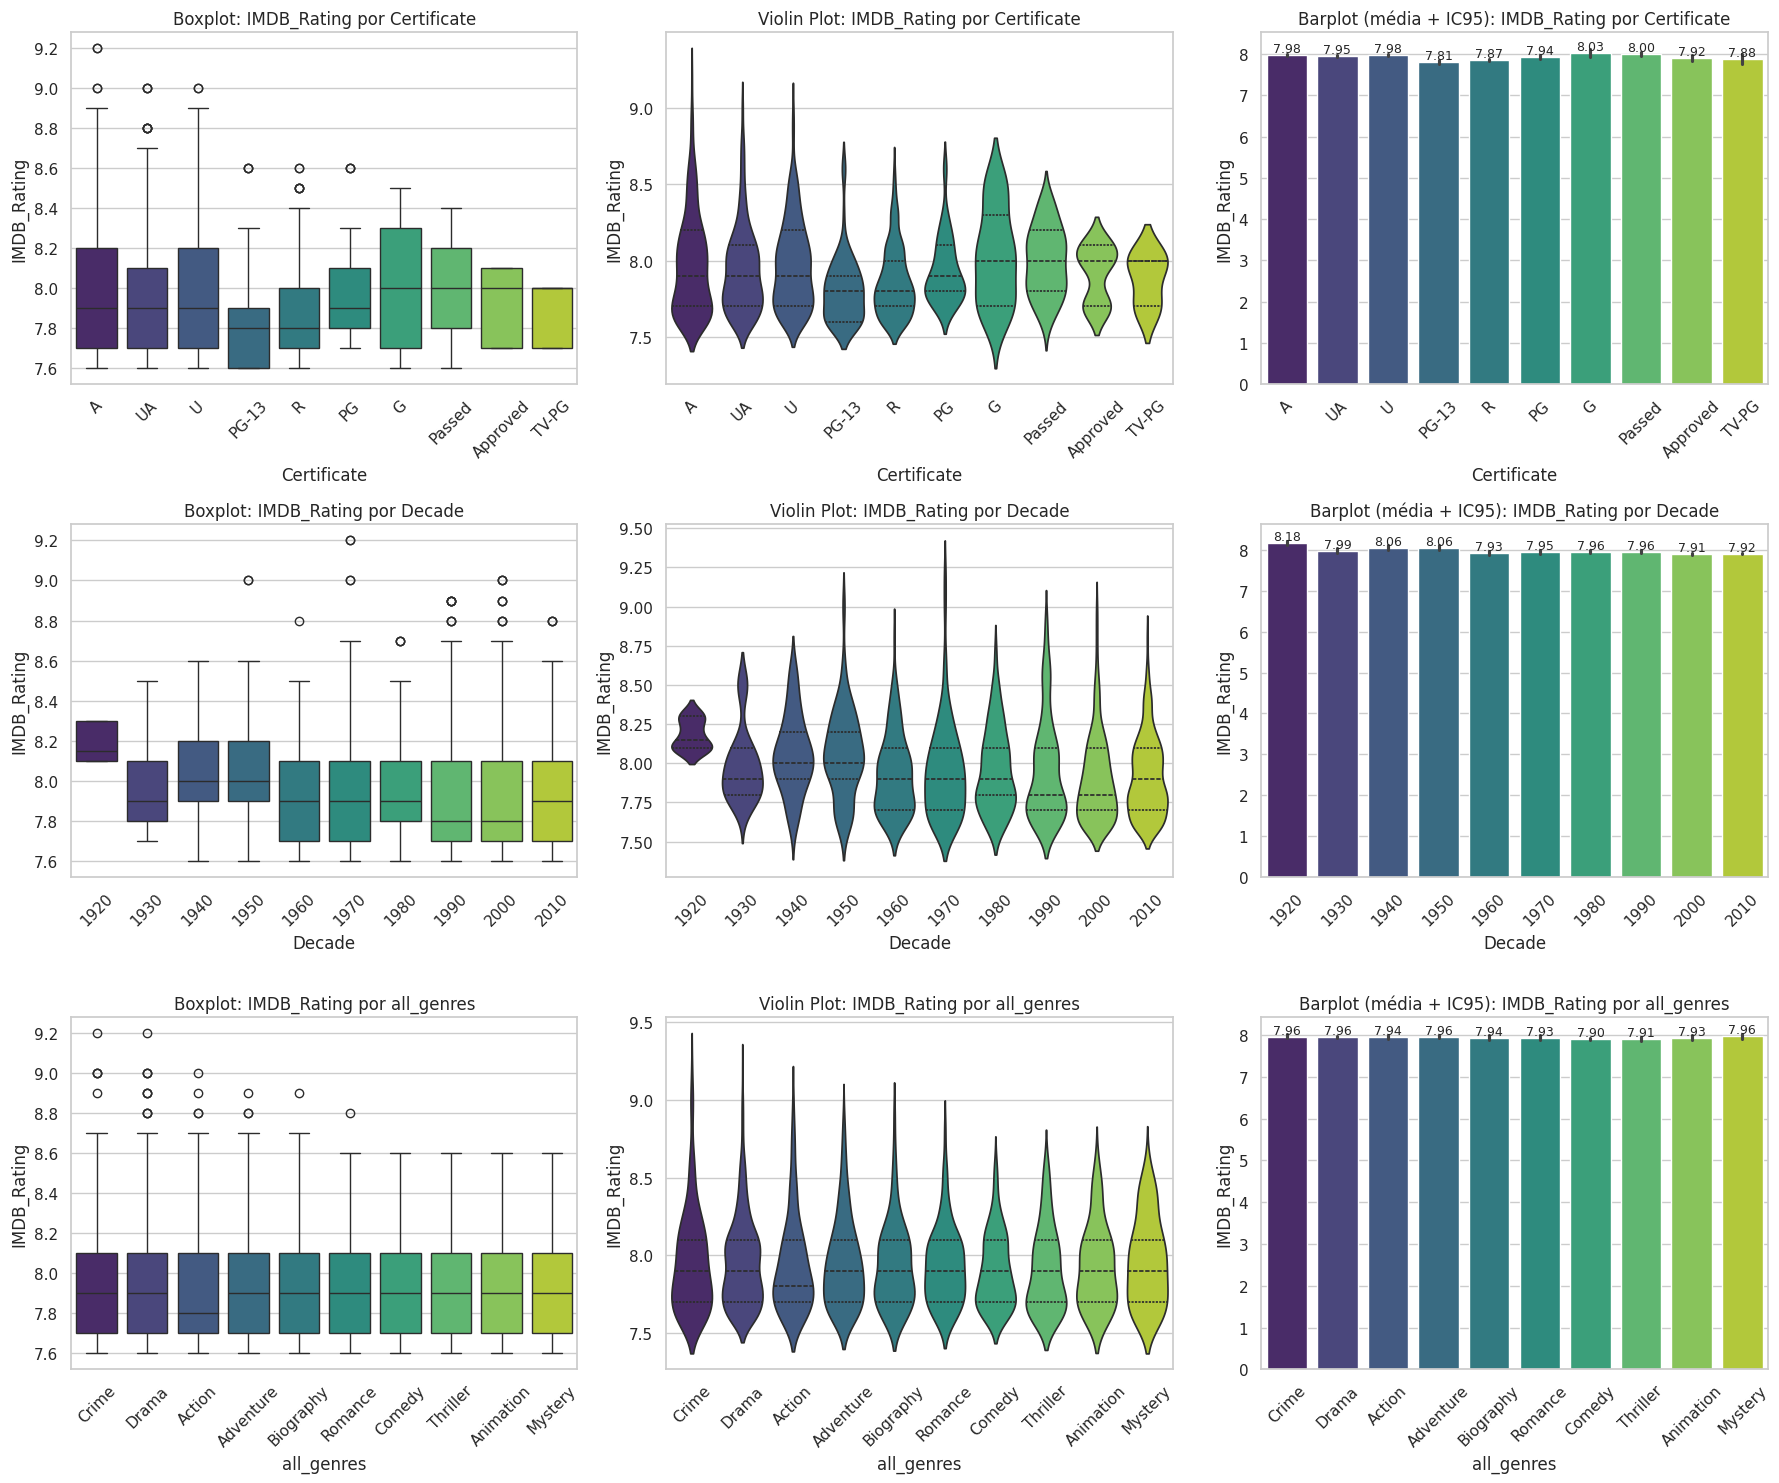

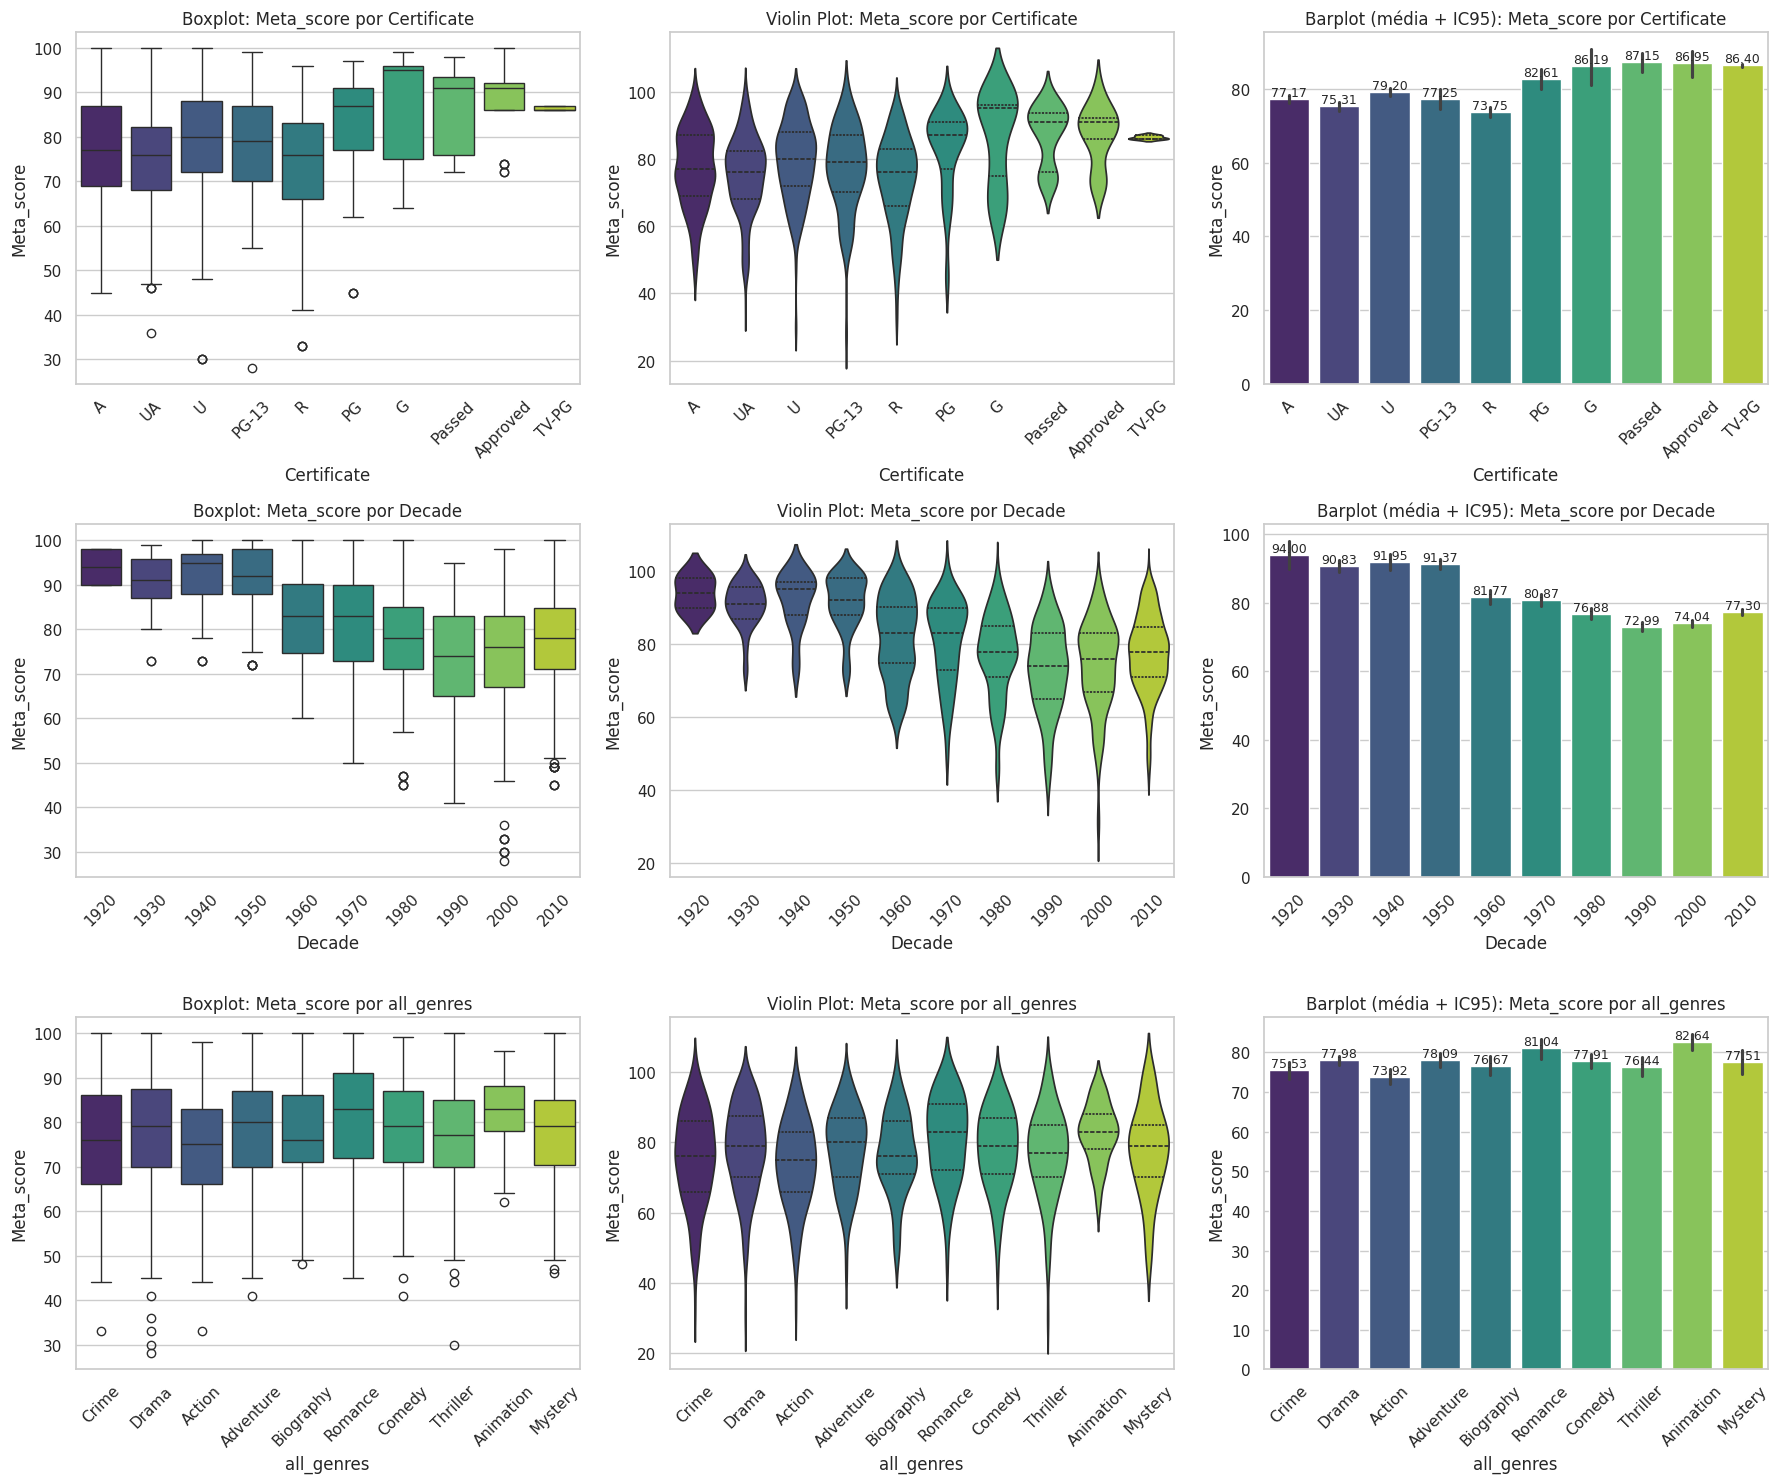

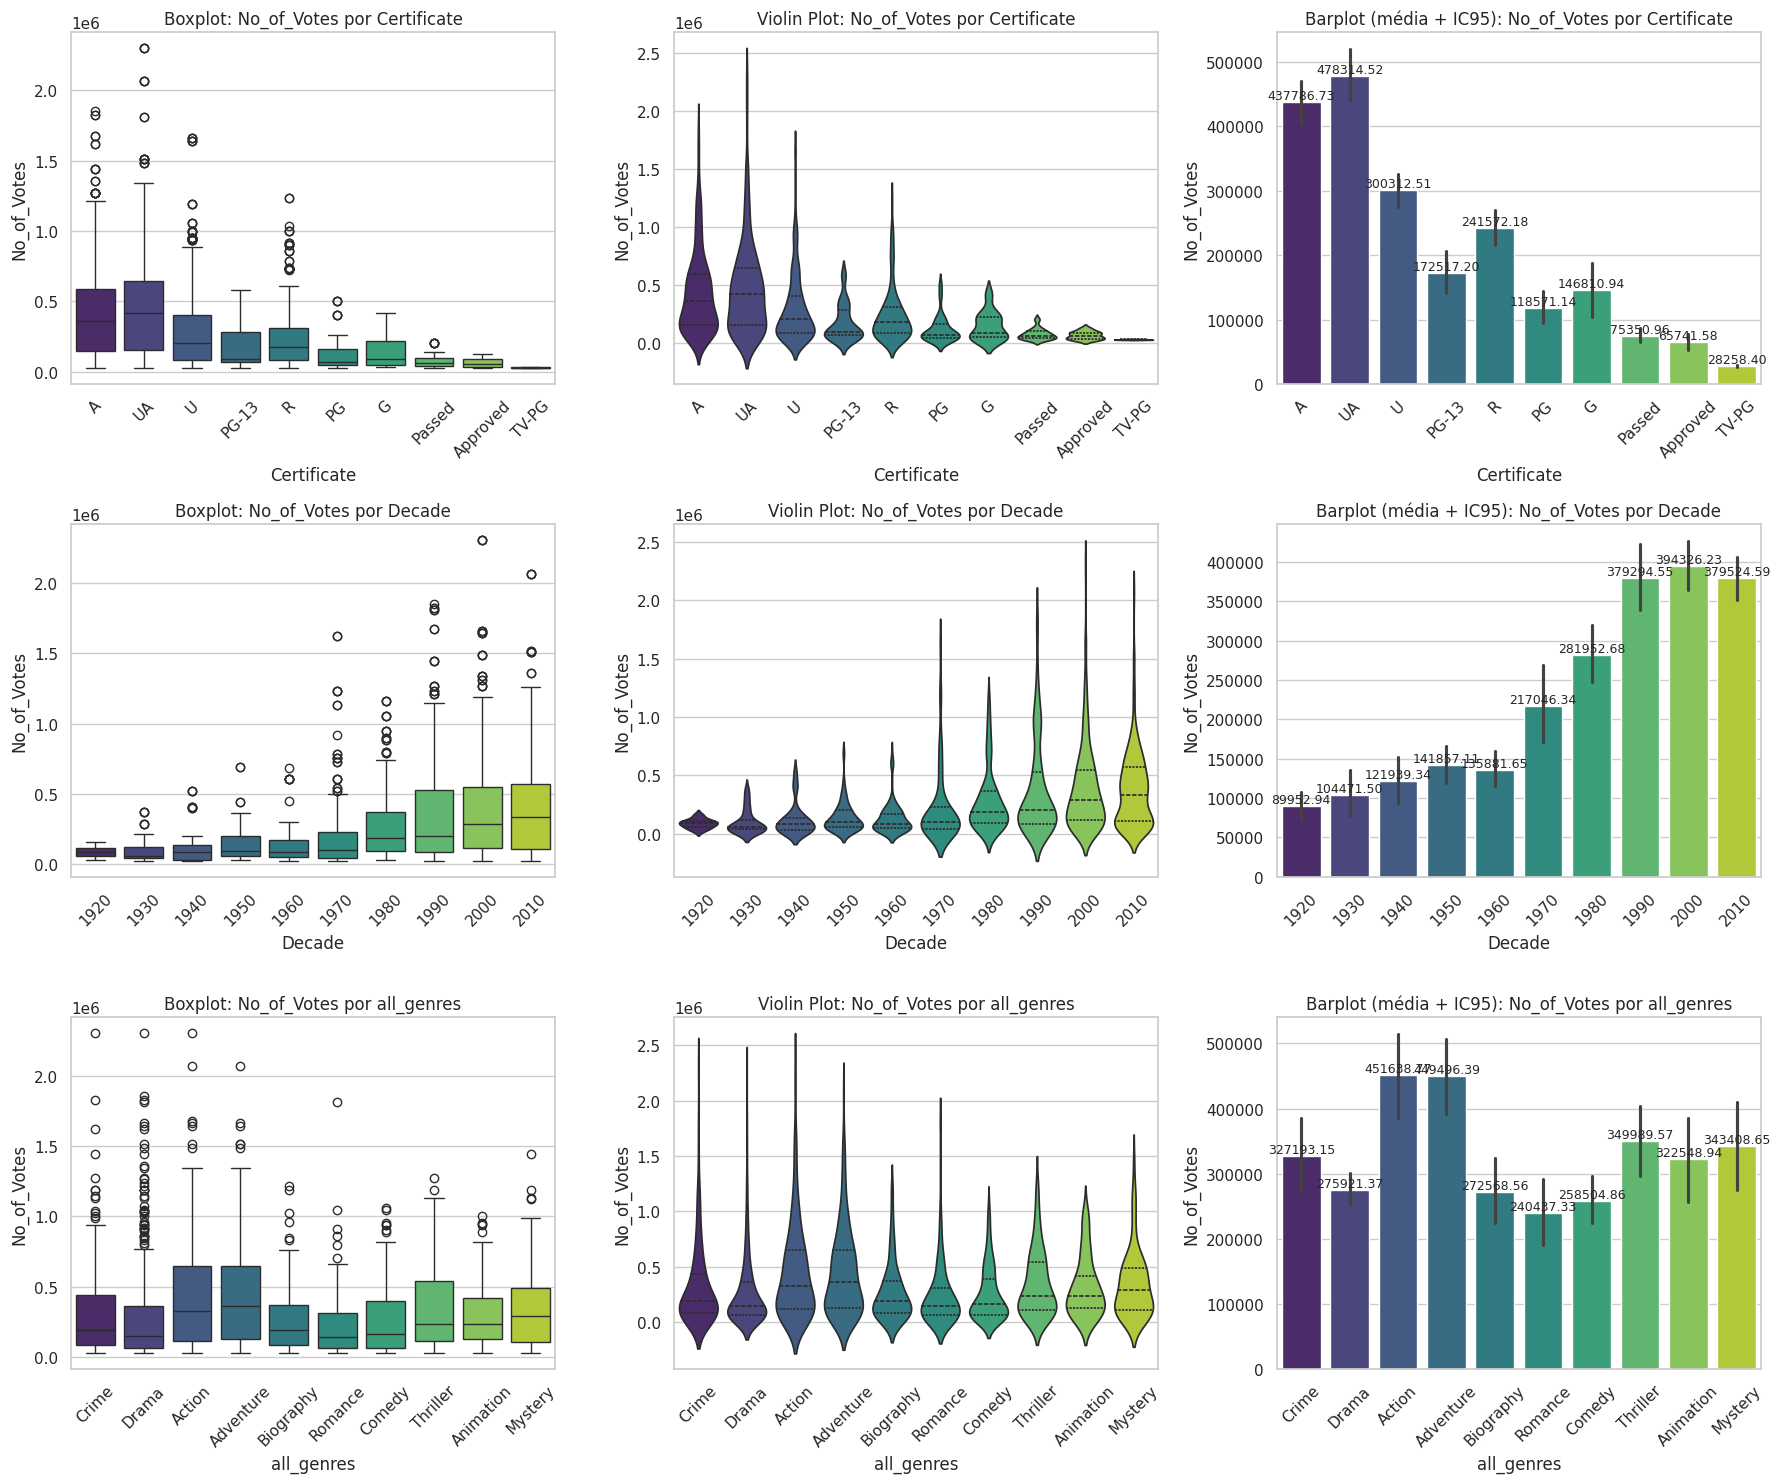

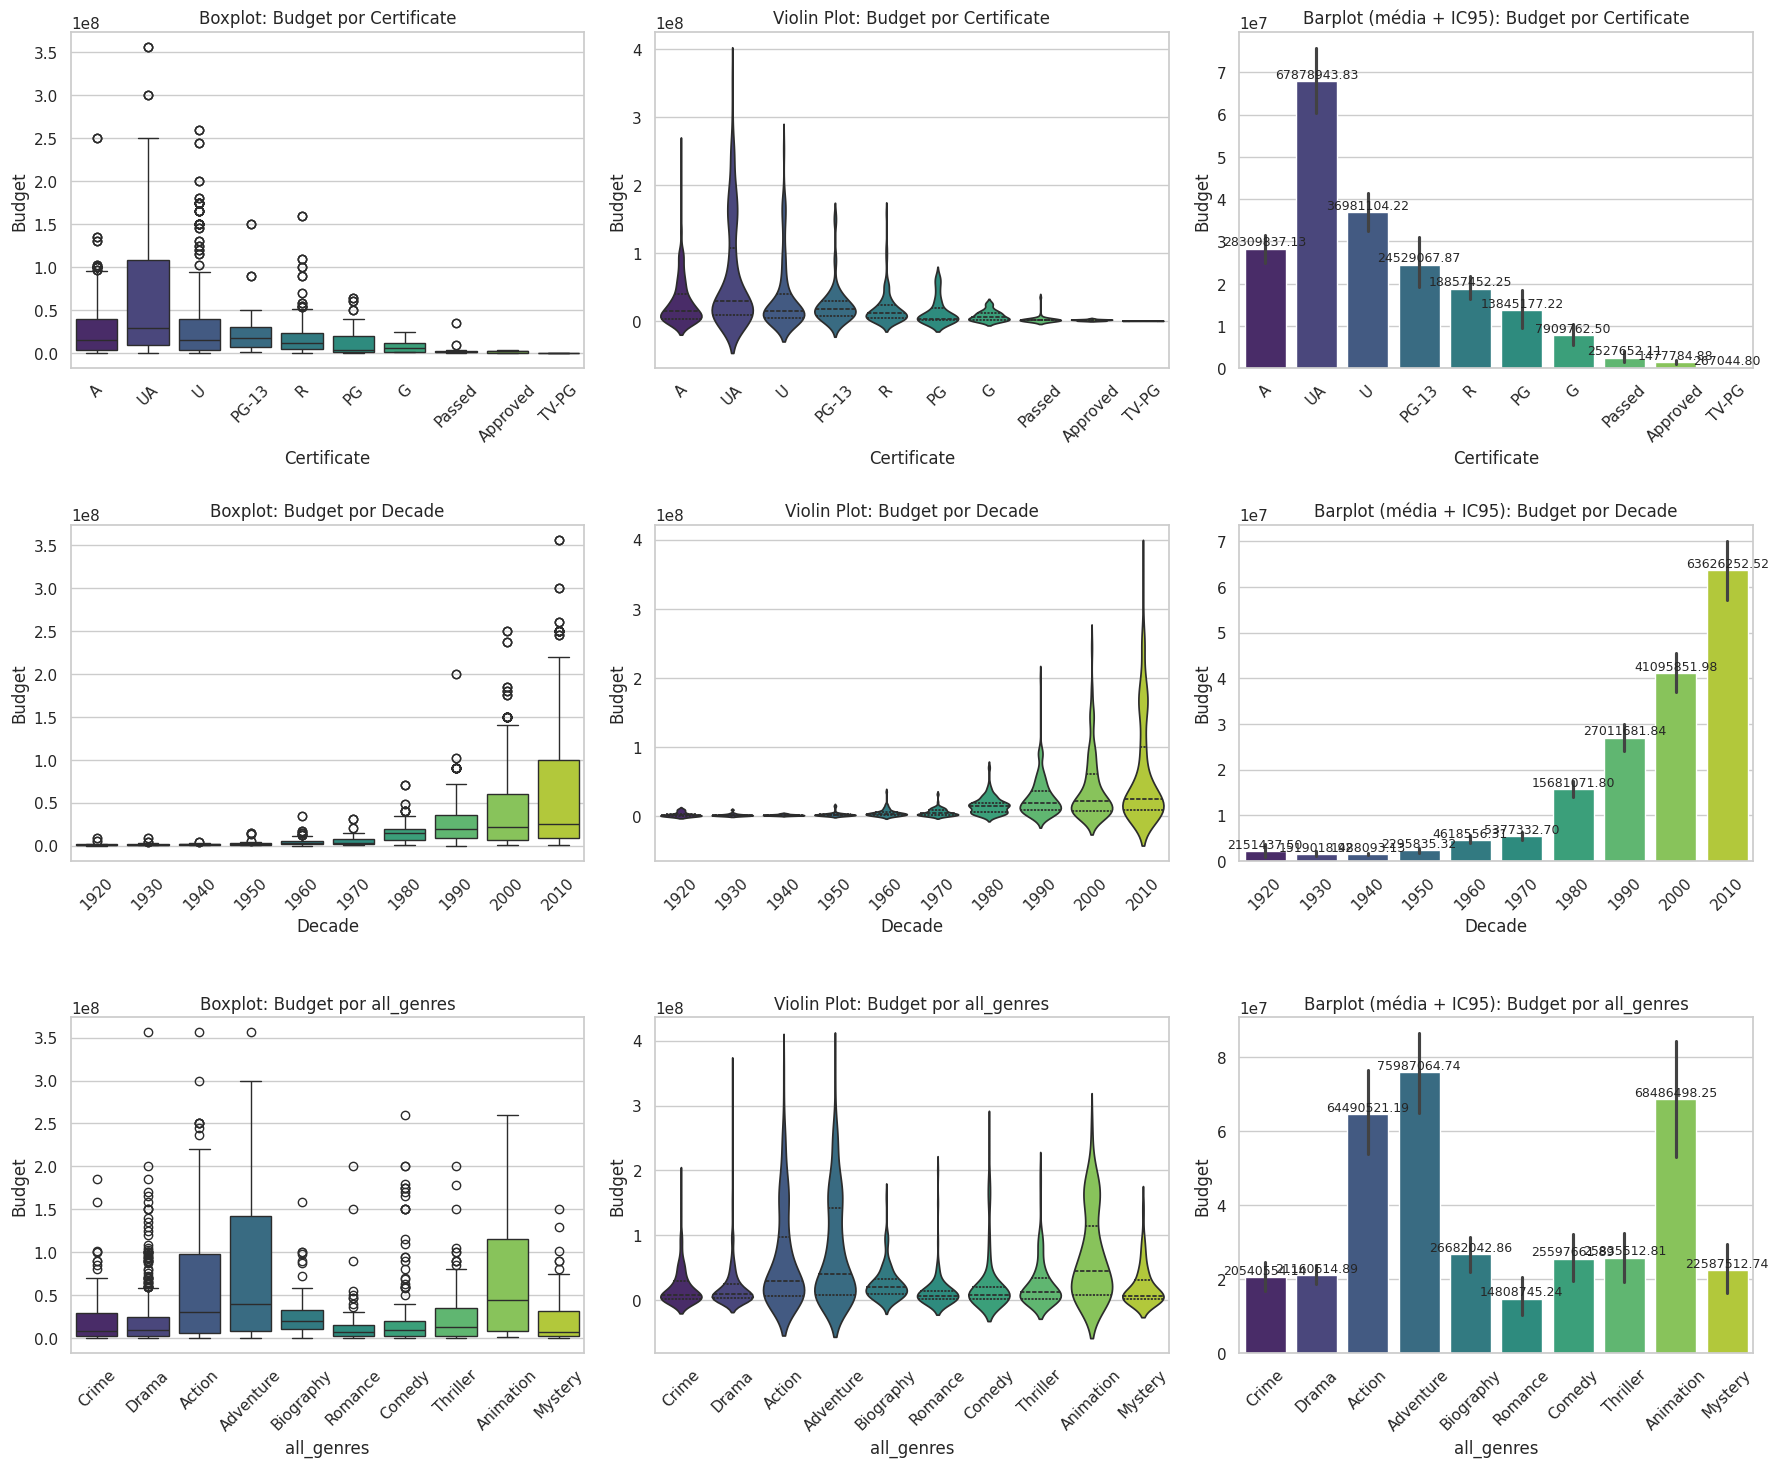

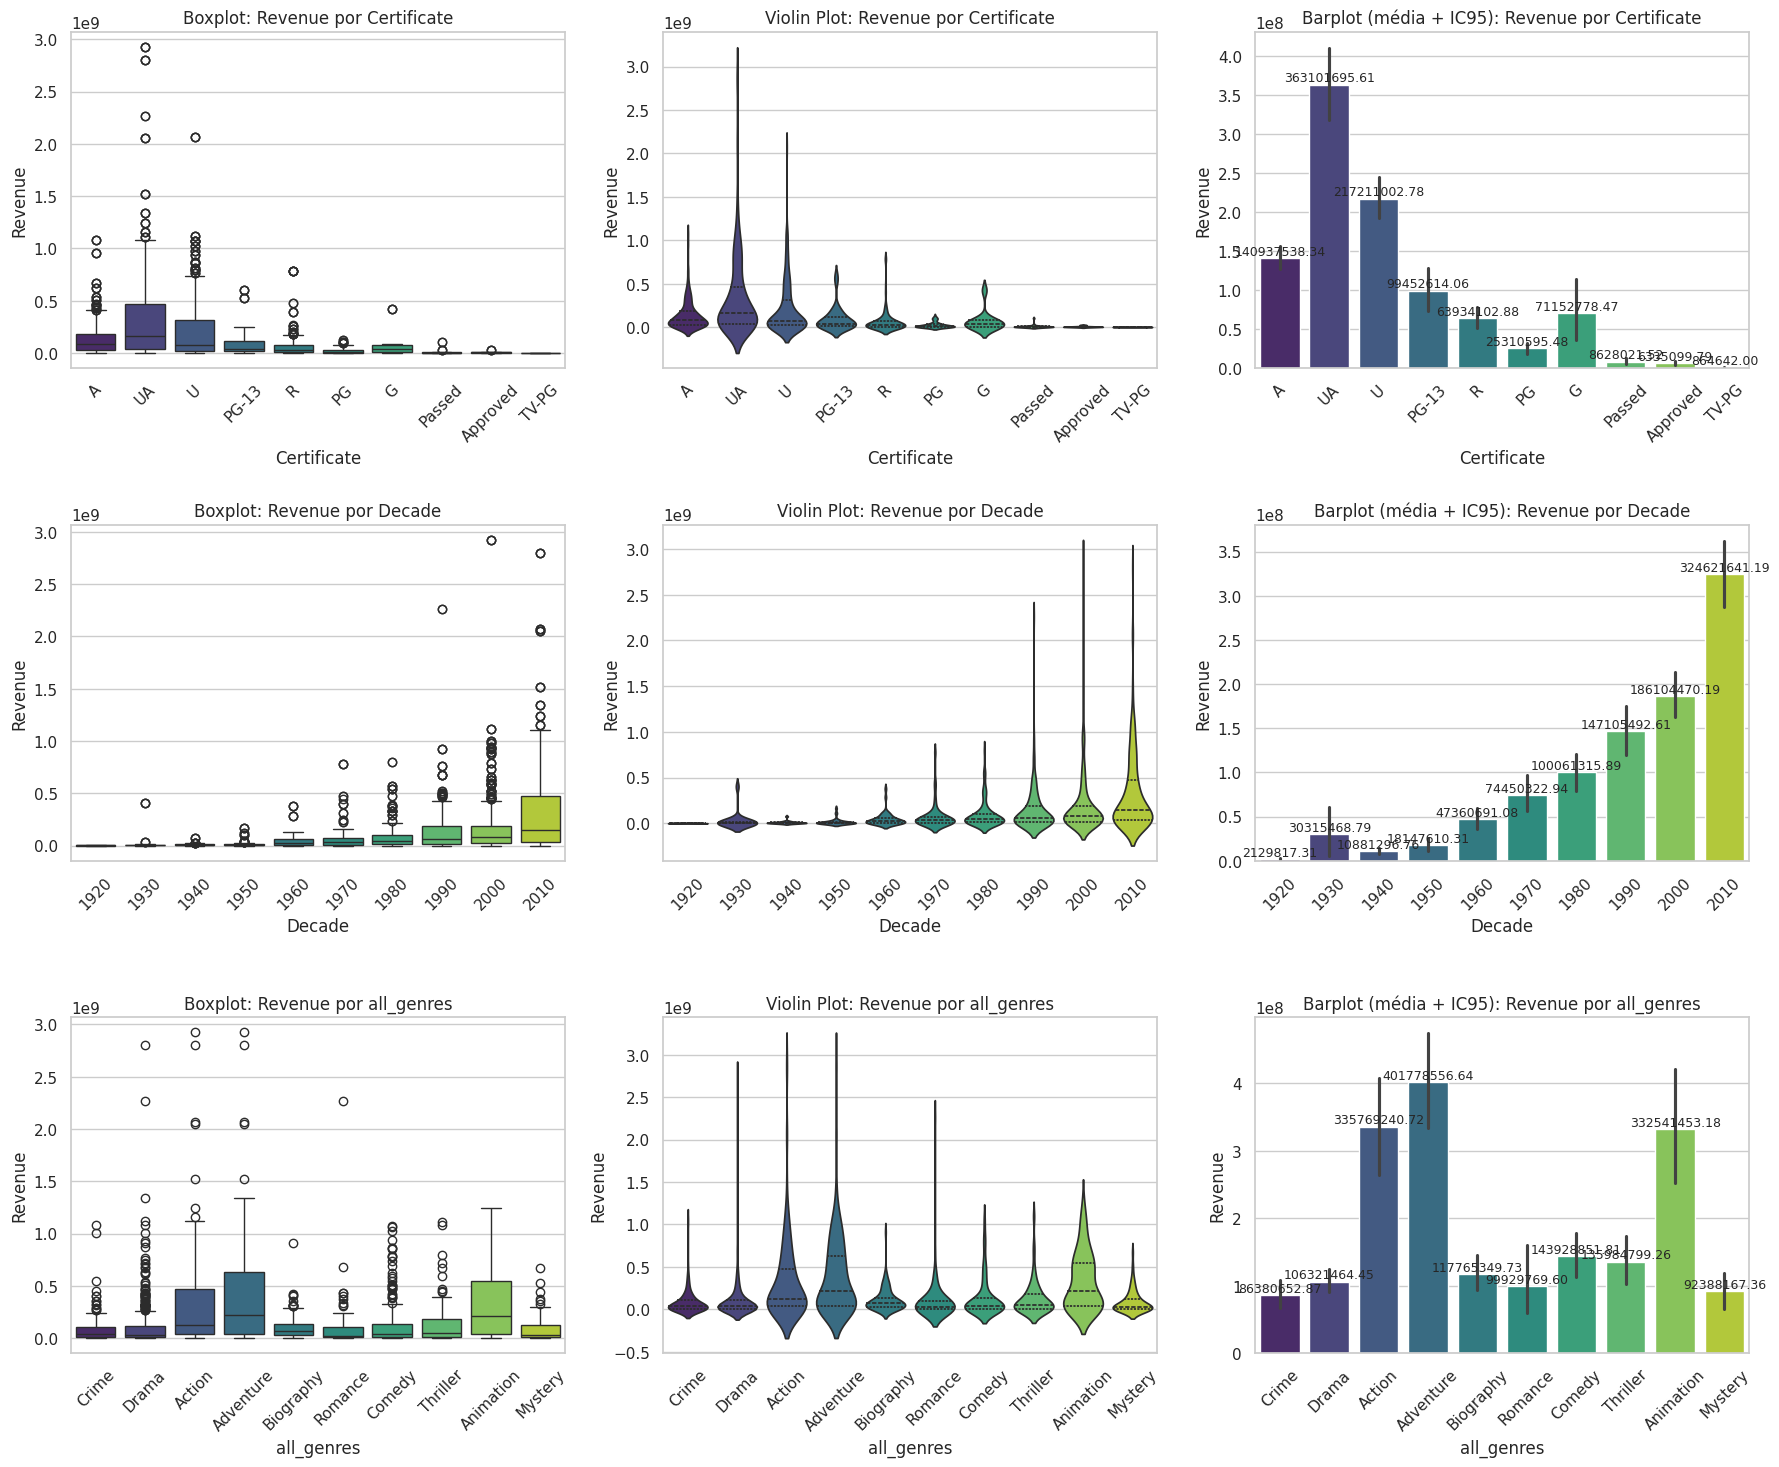

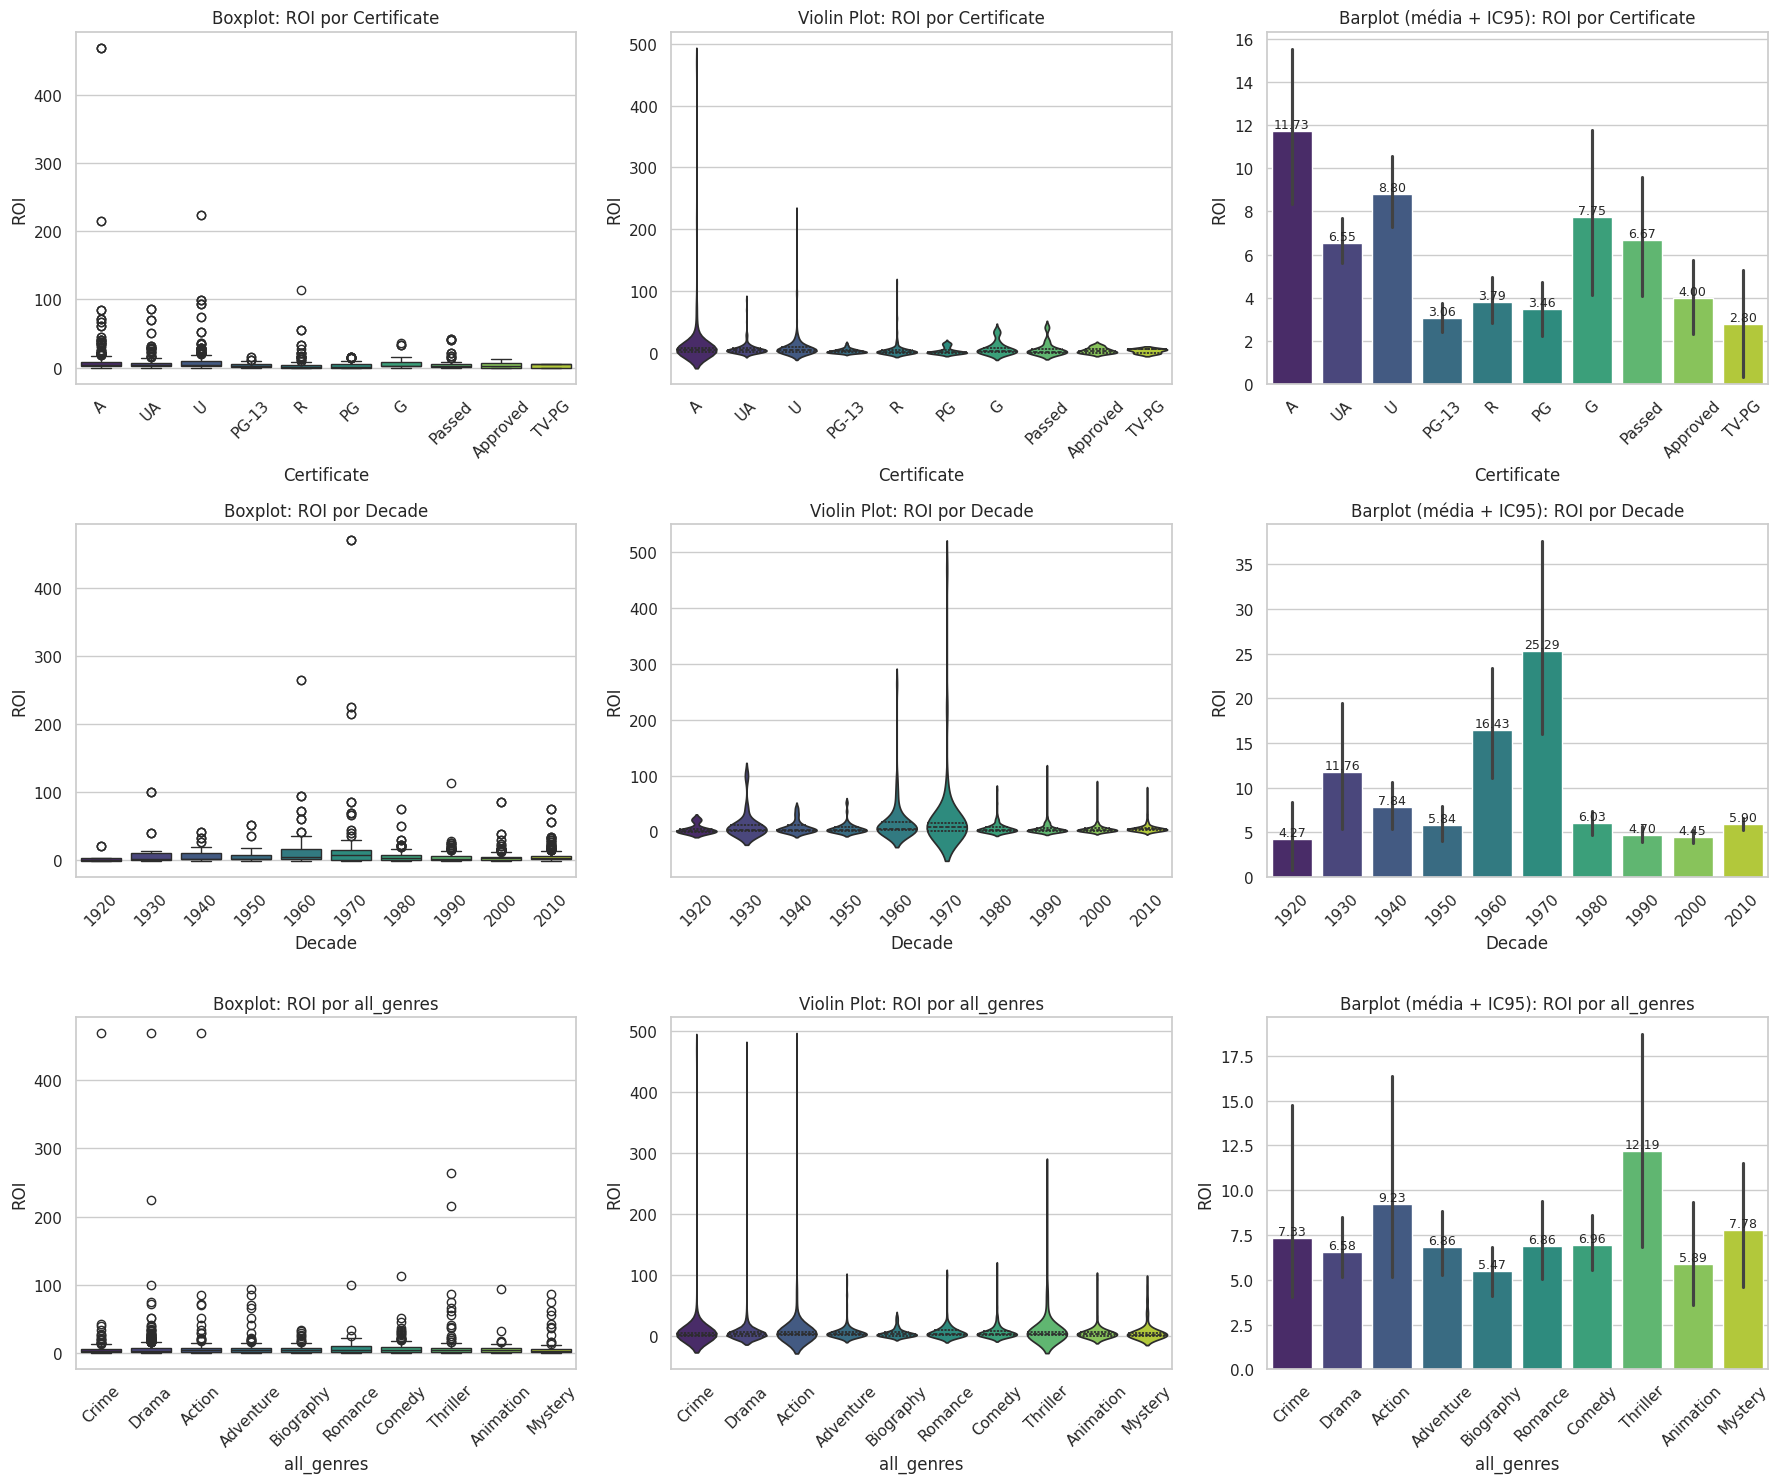

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Configuração
# -----------------------------
# Criar década
df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")
df["Decade"] = (df["Released_Year"] // 10) * 10

# Explodir gêneros e resetar índice
df_exploded = df.assign(all_genres=df['Genre'].str.split(', ')).explode('all_genres').reset_index(drop=True)

# Features numéricas e categóricas
numeric_features = ["IMDB_Rating", "Meta_score", "No_of_Votes", "Budget", "Revenue", "ROI"]
categorical_features = ["Certificate", "Decade", "all_genres"]

# -----------------------------
# Template de plots Numeric ↔ Categoric
# -----------------------------
for num in numeric_features:
    # Determinar linhas e colunas de subplots
    n_cols = 3
    n_rows = len(categorical_features)
    plt.figure(figsize=(18, n_rows * 5))

    for i, cat in enumerate(categorical_features):
        # Selecionar top 10 categorias mais frequentes
        top_n = 10
        top_values = df_exploded[cat].value_counts().nlargest(top_n).index
        plotting_df = df_exploded[df_exploded[cat].isin(top_values)]

        # -----------------------------
        # 1. Boxplot
        # -----------------------------
        plt.subplot(n_rows, n_cols, i * n_cols + 1)
        sns.boxplot(data=plotting_df, x=cat, y=num, palette="viridis")
        plt.xticks(rotation=45)
        plt.title(f"Boxplot: {num} por {cat}")

        # -----------------------------
        # 2. Violin Plot
        # -----------------------------
        plt.subplot(n_rows, n_cols, i * n_cols + 2)
        sns.violinplot(data=plotting_df, x=cat, y=num, inner="quartile", palette="viridis")
        plt.xticks(rotation=45)
        plt.title(f"Violin Plot: {num} por {cat}")

        # -----------------------------
        # 3. Barplot (média + IC95)
        # -----------------------------
        plt.subplot(n_rows, n_cols, i * n_cols + 3)
        ax = sns.barplot(data=plotting_df, x=cat, y=num, ci=95, estimator=np.mean, palette="viridis")
        plt.xticks(rotation=45)
        plt.title(f"Barplot (média + IC95): {num} por {cat}")

        # Anotar as barras com médias
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width()/2., height,
                    f'{height:.2f}',
                    ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()


ANOVA → quando os dados parecem normais e variâncias homogêneas → ótimo para médias.

Kruskal-Wallis → quando há outliers, assimetria ou variâncias muito diferentes → mais robusto.

Utilizarei os dois , por conta da assimetria , cauda a direita.

#### 3.3.2 Validando hipóteses

In [76]:
from scipy import stats
import pandas as pd

# Garantindo que Released_Year está numérico e criando Década
df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")
df["Decade"] = (df["Released_Year"] // 10) * 10

# Explode gêneros
df_exploded = df.assign(all_genres=df["Genre"].str.split(", ")).explode("all_genres")

# Variáveis numéricas e categóricas de interesse
numeric_features = ["IMDB_Rating", "Meta_score", "No_of_Votes", "Budget", "Revenue", "ROI"]
categorical_features = ["Certificate", "Decade", "all_genres"]

def run_anova_kruskal(df_exploded, numeric_features, categorical_features, top_n=10):
    results = []
    for num in numeric_features:
        for cat in categorical_features:
            data = df_exploded.copy()

            # Limita categorias muito grandes (ex: genres) para top N
            if data[cat].nunique() > top_n:
                top_categories = data[cat].value_counts().head(top_n).index
                data = data[data[cat].isin(top_categories)]

            groups = [g[num].dropna().values for _, g in data.groupby(cat) if len(g[num].dropna()) > 1]

            if len(groups) > 1:
                # ANOVA
                f_val, p_val_anova = stats.f_oneway(*groups)
                # Kruskal-Wallis
                h_val, p_val_kruskal = stats.kruskal(*groups)

                results.append({
                    "NumVar": num,
                    "CatVar": cat,
                    "ANOVA_F": f_val,
                    "ANOVA_p": p_val_anova,
                    "Kruskal_H": h_val,
                    "Kruskal_p": p_val_kruskal,
                    "Interpretação": "Diferenças significativas" if p_val_kruskal < 0.05 else "Sem evidência de diferenças"
                })
    return pd.DataFrame(results)

# Rodando os testes
num_cat_results = run_anova_kruskal(df_exploded, numeric_features, categorical_features, top_n=10)
display(num_cat_results)


NumVar       CatVar  ANOVA_F  ANOVA_p  Kruskal_H  Kruskal_p  \
0   IMDB_Rating  Certificate     7.09     0.00      63.44       0.00   
1   IMDB_Rating       Decade     7.05     0.00      79.55       0.00   
2   IMDB_Rating   all_genres     1.02     0.42       7.70       0.56   
3    Meta_score  Certificate    13.95     0.00     122.91       0.00   
4    Meta_score       Decade    45.42     0.00     356.36       0.00   
5    Meta_score   all_genres     4.08     0.00      36.20       0.00   
6   No_of_Votes  Certificate    35.39     0.00     385.12       0.00   
7   No_of_Votes       Decade    23.68     0.00     291.63       0.00   
8   No_of_Votes   all_genres     9.03     0.00      83.92       0.00   
9        Budget  Certificate    33.46     0.00     337.97       0.00   
10       Budget       Decade    53.94     0.00     805.16       0.00   
11       Budget   all_genres    37.57     0.00     179.92       0.00   
12      Revenue  Certificate    33.31     0.00     452.67       0.00   
13      Revenue       Decade    30.66     0.00     474.94       0.00   
14      Revenue   all_genres    29.37     0.00     167.50       0.00   
15          ROI  Certificate     3.63     0.00     164.02       0.00   
16          ROI       Decade    14.70     0.00      77.96       0.00   
17          ROI   all_genres     0.81     0.60      17.66       0.04   

                  Interpretação  
0     Diferenças significativas  
1     Diferenças significativas  
2   Sem evidência de diferenças  
3     Diferenças significativas  
4     Diferenças significativas  
5     Diferenças significativas  
6     Diferenças significativas  
7     Diferenças significativas  
8     Diferenças significativas  
9     Diferenças significativas  
10    Diferenças significativas  
11    Diferenças significativas  
12    Diferenças significativas  
13    Diferenças significativas  
14    Diferenças significativas  
15    Diferenças significativas  
16    Diferenças significativas  
17    Diferenças significativas

---

#### Hipóteses e Insights

#### 1. **IMDB Rating ↔ Certificate**

* **H₀:** A nota média no IMDB é igual entre certificados.
* **H₁:** Há diferenças entre certificados.
* ✅ Diferenças significativas (F=7.09, H=63.44, p<0.001).
* **Insight:** Filmes adultos (R/18+) têm padrões de avaliação distintos de PG/G.
  👉 *Marketing*: segmentar campanhas de acordo com a faixa etária, pois a percepção do público difere.

---

#### 2. **IMDB Rating ↔ Decade**

* ✅ Diferenças significativas (F=7.05, p<0.001).
* **Insight:** As notas do público variam ao longo das décadas (ex.: “clássicos” tendem a ser melhor avaliados).
  👉 *Distribuidoras*: relançamentos e remakes podem explorar a nostalgia e reputação histórica.

---

#### 3. **IMDB Rating ↔ all\_genres**

* ❌ Sem diferenças significativas (p>0.05).
* **Insight:** O gênero não influencia diretamente a nota média no IMDB.
  👉 *Foco em qualidade*: investimento em elenco/direção importa mais que o gênero.

---

#### 4. **Meta\_score ↔ Certificate**

* ✅ Diferenças significativas (F=13.95, H=122.91, p<0.001).
* **Insight:** A crítica avalia de forma distinta filmes adultos vs infantis.
  👉 *Premiações*: filmes adultos têm mais chance de reconhecimento crítico.

---

#### 5. **Meta\_score ↔ Decade**

* ✅ Diferenças significativas (F=45.42, H=356.36, p<0.001).
* **Insight:** O padrão da crítica mudou ao longo do tempo.
  👉 *Histórico*: útil para entender por que décadas clássicas concentram obras premiadas.

---

#### 6. **Meta\_score ↔ all\_genres**

* ✅ Diferenças significativas (F=4.08, H=36.20, p<0.001).
* **Insight:** Dramas/Biografias têm notas mais altas da crítica, ação/terror menos.
  👉 *Estratégia criativa*: investir em dramas aumenta chance de reconhecimento crítico.

---

#### 7. **No\_of\_Votes ↔ Certificate**

* ✅ Diferenças significativas (F=35.39, H=385.12, p<0.001).
* **Insight:** Filmes adultos concentram mais votos (engajamento), infantis menos.
  👉 *Streaming*: foco em filmes adultos para gerar buzz e engajamento digital.

---

#### 8. **No\_of\_Votes ↔ Decade**

* ✅ Diferenças significativas (F=23.68, H=291.63, p<0.001).
* **Insight:** Filmes recentes atraem muito mais votos (plataformas digitais).
  👉 *Engajamento online*: campanhas digitais funcionam melhor para lançamentos atuais.

---

#### 9. **No\_of\_Votes ↔ all\_genres**

* ✅ Diferenças significativas (F=9.03, H=83.92, p<0.001).
* **Insight:** Ação e aventura têm mais votos; biografias/dramas menos.
  👉 *Bilheteria global*: ação/aventura maximizam alcance internacional.

---

#### 10. **Budget ↔ Certificate**

* ✅ Diferenças significativas (F=33.46, H=337.97, p<0.001).
* **Insight:** Filmes adultos recebem mais orçamento.
  👉 *Gestão de risco*: certificados restritos exigem maior retorno para compensar o público menor.

---

#### 11. **Budget ↔ Decade**

* ✅ Diferenças significativas (F=53.94, H=805.16, p<0.001).
* **Insight:** Orçamentos cresceram exponencialmente ao longo das décadas.
  👉 *Benchmark financeiro*: planejar budgets futuros considerando a inflação do setor.

---

#### 12. **Budget ↔ all\_genres**

* ✅ Diferenças significativas (F=37.57, H=179.92, p<0.001).
* **Insight:** Ação/Aventura/Animação exigem maiores investimentos.
  👉 *Portfólio*: definir budgets conforme o potencial de bilheteria do gênero.

---

#### 13. **Revenue ↔ Certificate**

* ✅ Diferenças significativas (F=33.31, H=452.67, p<0.001).
* **Insight:** Certificados PG/UA (amplo público) geram maior receita.
  👉 *Maximização de bilheteria*: ampliar classificação etária quando possível.

---

#### 14. **Revenue ↔ Decade**

* ✅ Diferenças significativas (F=30.66, H=474.94, p<0.001).
* **Insight:** Receita aumentou nas últimas décadas.
  👉 *Investidores*: retorno financeiro do setor está em tendência crescente.

---

#### 15. **Revenue ↔ all\_genres**

* ✅ Diferenças significativas (F=29.37, H=167.50, p<0.001).
* **Insight:** Ação/Aventura/Animação dominam bilheteria.
  👉 *Produção*: esses gêneros são mais seguros para blockbusters.

---

#### 16. **ROI ↔ Certificate**

* ✅ Diferenças significativas (F=3.63, H=164.02, p<0.001).
* **Insight:** Filmes adultos têm ROI mais volátil; PG/UA mais estáveis.
  👉 *Risco-retorno*: blockbusters adultos podem falhar, mas infantis tendem a ROI mais consistente.

---

#### 17. **ROI ↔ Decade**

* ✅ Diferenças significativas (F=14.70, H=77.96, p<0.001).
* **Insight:** Algumas décadas (70s, 80s) foram mais rentáveis em ROI.
  👉 *Estudo histórico*: entender condições que favoreceram alto ROI no passado.

---

#### 18. **ROI ↔ all\_genres**

* ✅ Diferenças significativas (Kruskal p=0.04).
* **Insight:** Terror/Thriller geram ROIs altíssimos (baixo orçamento + bom retorno); ação/animação lucram em volume, não em margem.
  👉 *Estratégia de portfólio*: diversificar → blockbusters + terror/indies para equilibrar margem e volume.

---

# 🔑 **Resumo Executivo**

* **Certificados**: definem orçamento, receita e ROI → chave no posicionamento do filme.
* **Décadas**: mostram tendências históricas → útil para prever investimentos futuros.
* **Gêneros**: guiam orçamentos e bilheterias → blockbusters (ação/aventura) garantem receita, terror/drama maximizam ROI.

---

### 3.4 Plots de negócio

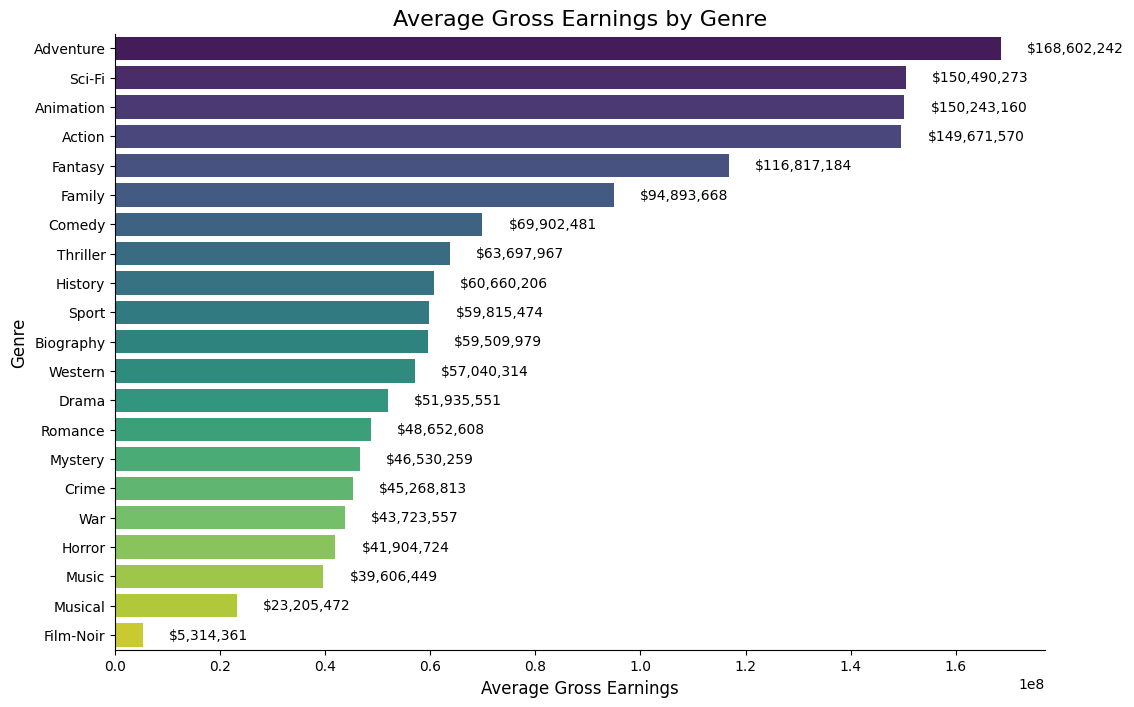

In [ ]:
# The 'Genre' column can contain multiple genres separated by commas.
# We need to split the genres and then group by each individual genre.

# Create a list of all unique genres
genres = df['Genre'].str.split(', ').explode().unique()

# Create a dictionary to store the sum of gross for each genre and the count of movies for each genre
genre_gross = {genre: {'gross_sum': 0, 'movie_count': 0} for genre in genres}

# Iterate through each movie and add its gross to the corresponding genres
for index, row in df.dropna(subset=['Gross']).iterrows(): # Corrected column name to 'Gross'
    movie_genres = row['Genre'].split(', ')
    gross = row['Gross'] # Corrected column name to 'Gross'
    for genre in movie_genres:
        if genre in genre_gross:
            genre_gross[genre]['gross_sum'] += gross
            genre_gross[genre]['movie_count'] += 1

# Calculate the average gross for each genre
average_genre_gross = {genre: data['gross_sum'] / data['movie_count'] if data['movie_count'] > 0 else 0
                       for genre, data in genre_gross.items()}

# Convert the dictionary to a pandas Series and sort for better visualization
average_genre_gross_series = pd.Series(average_genre_gross).sort_values(ascending=False)

# Plot the average gross by genre
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=average_genre_gross_series.values, y=average_genre_gross_series.index, palette='viridis')
plt.title('Average Gross Earnings by Genre', fontsize=16) # Increased title font size
plt.xlabel('Average Gross Earnings', fontsize=12)
plt.ylabel('Genre', fontsize=12)
sns.despine() # Added despine to remove top and right spines

# Add value labels to the bars
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 5000000, # Position the text slightly to the right of the bar
             p.get_y() + p.get_height() / 2,
             '${:,.0f}'.format(width), # Format the value as currency
             va='center')

plt.show()

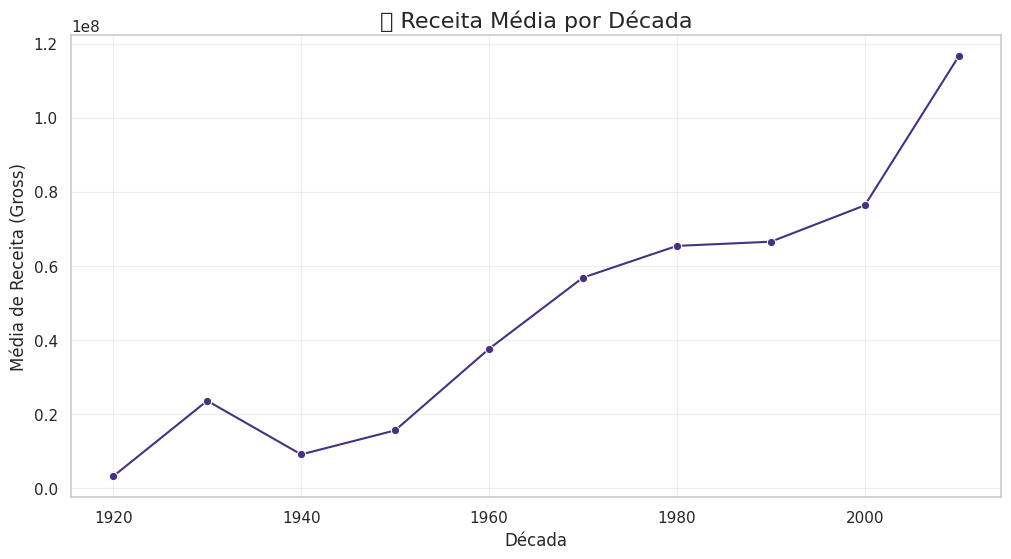

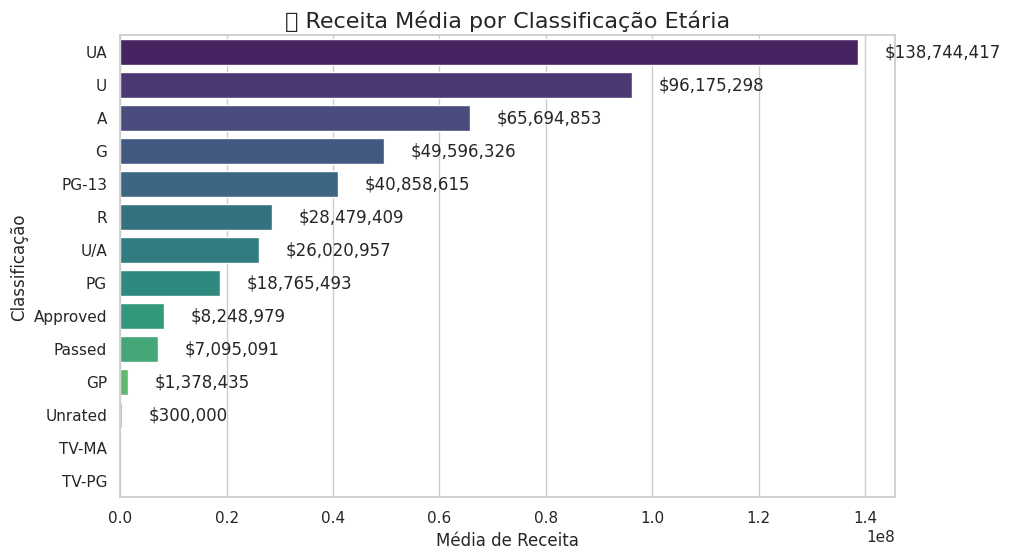

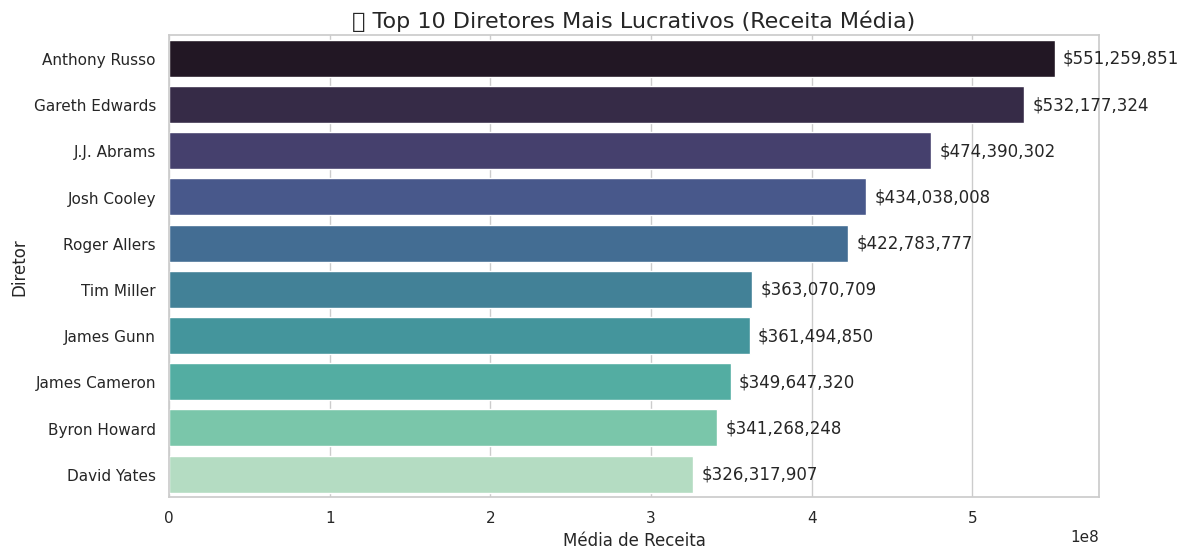

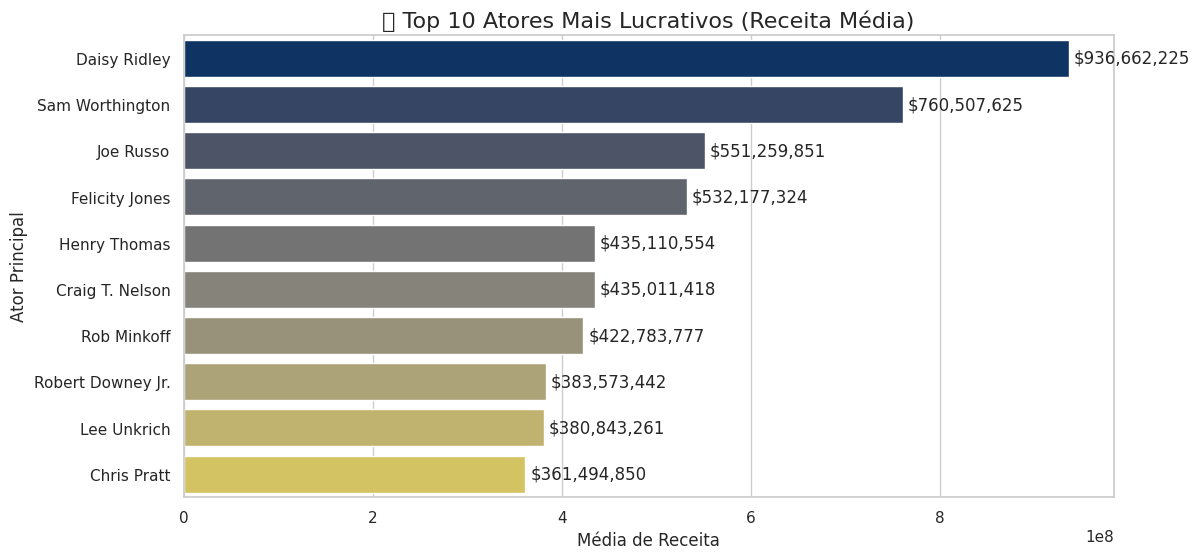

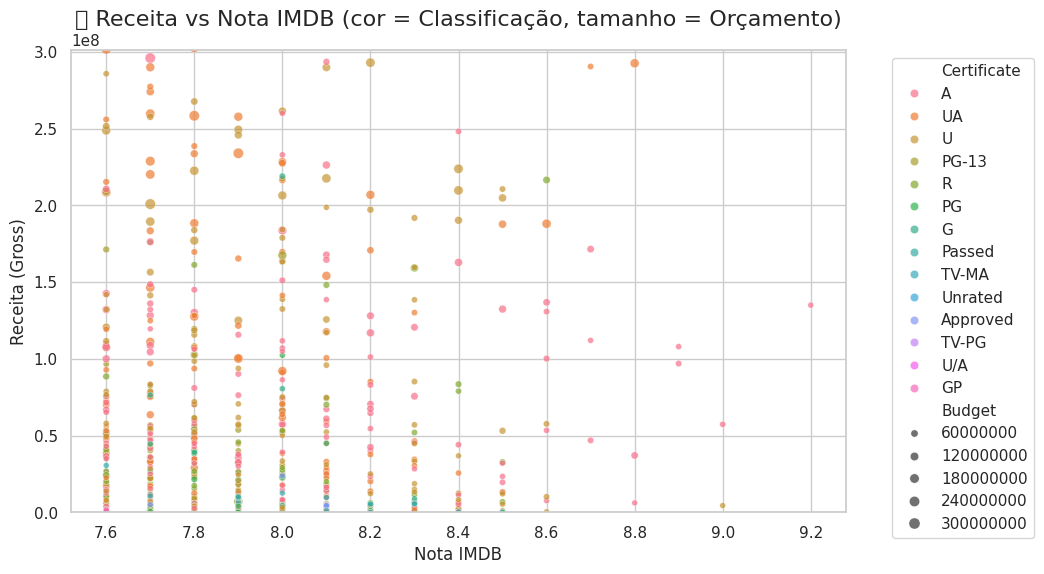

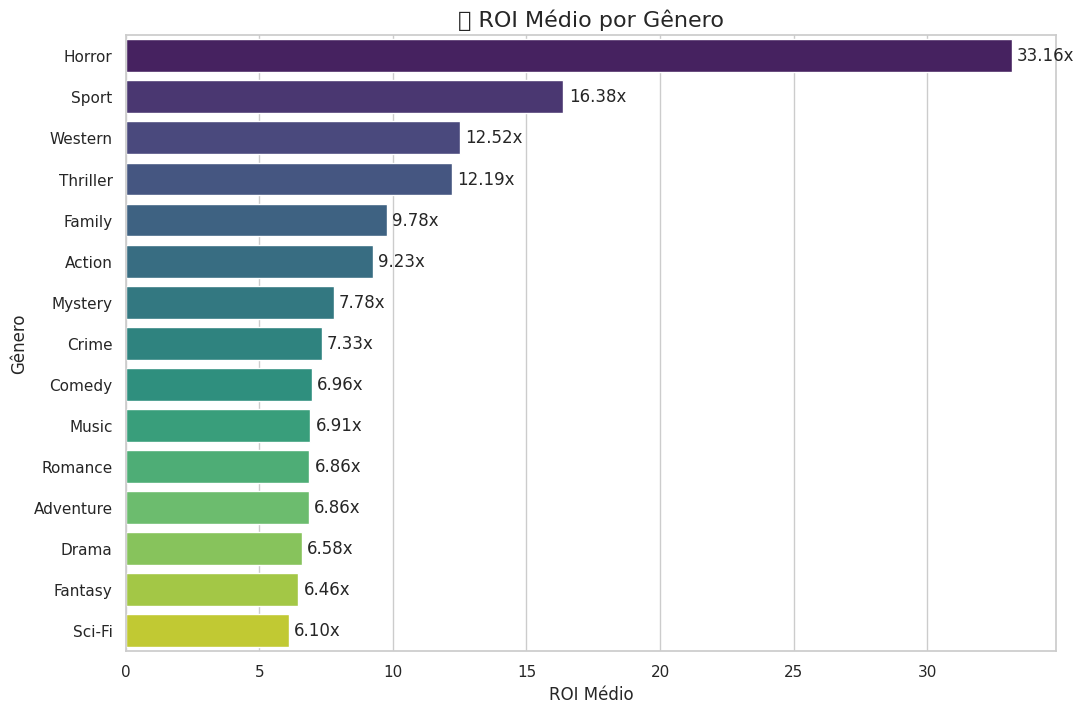

In [88]:
# ===================================================
# AGRUPAMENTOS
# ===================================================
import seaborn as sns
import matplotlib.pyplot as plt

# Garantindo que Gross está numérico
df["Gross"] = pd.to_numeric(df["Gross"], errors="coerce")
df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")
df["Decade"] = (df["Released_Year"] // 10) * 10

# Explodindo gêneros
df_exploded = df.assign(all_genres=df["Genre"].str.split(", ")).explode("all_genres")

# ===================================================
# 1. Receita média por década
# ===================================================
avg_gross_decade = df.groupby("Decade")["Gross"].mean().sort_index()

plt.figure(figsize=(12,6))
sns.lineplot(x=avg_gross_decade.index, y=avg_gross_decade.values, marker="o")
plt.title("📈 Receita Média por Década", fontsize=16)
plt.xlabel("Década")
plt.ylabel("Média de Receita (Gross)")
plt.grid(alpha=0.3)
plt.show()

# ===================================================
# 2. Receita média por classificação etária
# ===================================================
avg_gross_certificate = df.groupby("Certificate")["Gross"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
ax = sns.barplot(x=avg_gross_certificate.values, y=avg_gross_certificate.index, palette="viridis")
plt.title("🎟️ Receita Média por Classificação Etária", fontsize=16)
plt.xlabel("Média de Receita")
plt.ylabel("Classificação")

for p in ax.patches:
    ax.text(p.get_width()+5e6, p.get_y()+p.get_height()/2, f"${p.get_width():,.0f}", va="center")

plt.show()

# ===================================================
# 3. Top 10 Diretores por Receita Média
# ===================================================
top_directors = df.groupby("Director")["Gross"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(x=top_directors.values, y=top_directors.index, palette="mako")
plt.title("🎬 Top 10 Diretores Mais Lucrativos (Receita Média)", fontsize=16)
plt.xlabel("Média de Receita")
plt.ylabel("Diretor")

for p in ax.patches:
    ax.text(p.get_width()+5e6, p.get_y()+p.get_height()/2, f"${p.get_width():,.0f}", va="center")

plt.show()

# ===================================================
# 4. Top 10 Atores por Receita Média
# ===================================================
top_actors = df_exploded.groupby("Star1")["Gross"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(x=top_actors.values, y=top_actors.index, palette="cividis")
plt.title("⭐ Top 10 Atores Mais Lucrativos (Receita Média)", fontsize=16)
plt.xlabel("Média de Receita")
plt.ylabel("Ator Principal")

for p in ax.patches:
    ax.text(p.get_width()+5e6, p.get_y()+p.get_height()/2, f"${p.get_width():,.0f}", va="center")

plt.show()

# ===================================================
# 5. Relação Receita vs Nota IMDB
# ===================================================
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="IMDB_Rating", y="Gross", hue="Certificate", size="Budget", alpha=0.7)
plt.title("⭐ Receita vs Nota IMDB (cor = Classificação, tamanho = Orçamento)", fontsize=16)
plt.xlabel("Nota IMDB")
plt.ylabel("Receita (Gross)")
plt.ylim(0, df["Gross"].quantile(0.95)) # cortar outliers extremos
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

# ===================================================
# 6. ROI Médio por Gênero
# ===================================================
avg_roi_genre = df_exploded.groupby("all_genres")["ROI"].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,8))
ax = sns.barplot(x=avg_roi_genre.values, y=avg_roi_genre.index, palette="viridis")
plt.title("📊 ROI Médio por Gênero", fontsize=16)
plt.xlabel("ROI Médio")
plt.ylabel("Gênero")

for p in ax.patches:
    ax.text(p.get_width()+0.2, p.get_y()+p.get_height()/2, f"{p.get_width():.2f}x", va="center")

plt.show()


# Modelagem

### 4 Pré-Processamento, Modelagem, Pipeline, GridSearch


===== Treinando OLS =====

===== Treinando Ridge =====
Melhores parâmetros: {'model__alpha': 0.1}

===== Treinando RandomForest =====
Melhores parâmetros: {'model__max_depth': 10, 'model__n_estimators': 300}

===== Treinando XGBoost =====
Melhores parâmetros: {'model__max_depth': 3, 'model__n_estimators': 300}

📊 Resultados:
OLS: MAE=0.000, RMSE=0.000, R²=1.000
Ridge: MAE=0.001, RMSE=0.002, R²=1.000
RandomForest: MAE=0.087, RMSE=0.109, R²=0.852
XGBoost: MAE=0.059, RMSE=0.070, R²=0.939


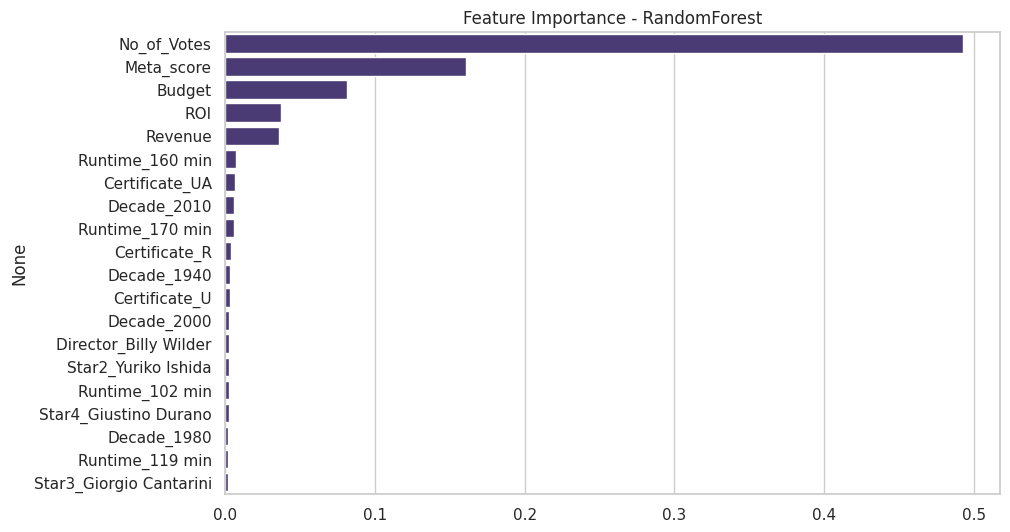

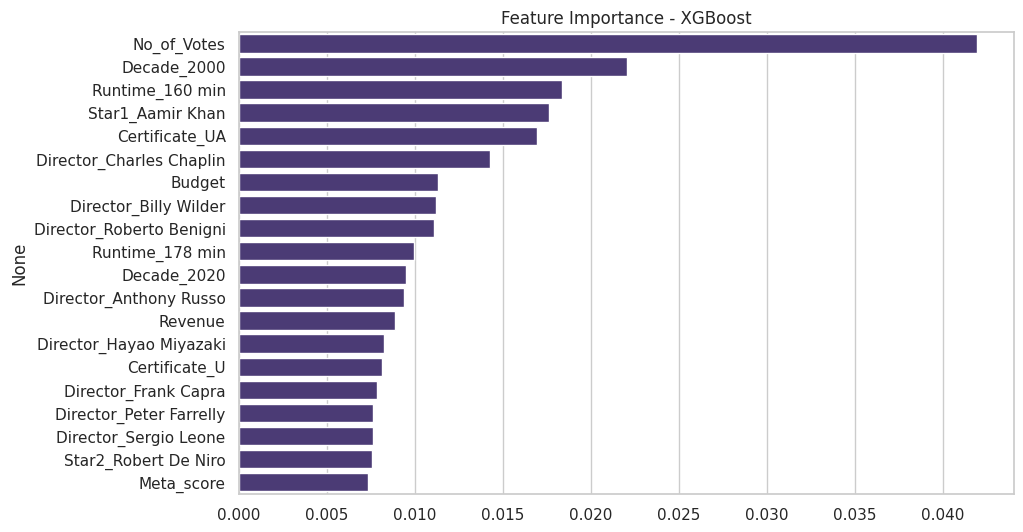

In [86]:
# ============================================
# PREVISÃO DE IMDB_Rating
# ============================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# ============================================
# 1. PREPARAÇÃO DOS DADOS
# ============================================
# Variável target
target = "IMDB_Rating"

# Features
numeric_features = ["Meta_score", "No_of_Votes", "Budget", "Revenue", "ROI", ]
categorical_features = ["Certificate", "Decade", "all_genres", "Director", "Star1","Star2","Star3","Star4","Runtime"]

X = df_exploded[numeric_features + categorical_features]
y = df_exploded[target]

# ============================================
# 2. PRÉ-PROCESSAMENTO
# ============================================
# Numéricas → imputação + escala
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categóricas → imputação + one-hot
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# ============================================
# 3. MODELOS
# ============================================
models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(
        objective="reg:squarederror", eval_metric="rmse", random_state=42
    )
}

# ============================================
# 4. PIPELINE + GRID SEARCH
# ============================================
param_grid = {
    "Ridge": {"model__alpha": [0.1, 1, 10]},
    "RandomForest": {"model__n_estimators": [100, 300],
                     "model__max_depth": [5, 10, None]},
    "XGBoost": {"model__n_estimators": [100, 300],
                "model__max_depth": [3, 6, 10]}
}

results = {}

for name, model in models.items():
    print(f"\n===== Treinando {name} =====")

    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])

    if name in param_grid:
        grid = GridSearchCV(pipe, param_grid[name], cv=5,
                            scoring="neg_mean_absolute_error", n_jobs=-1)
        grid.fit(X, y)
        best_model = grid.best_estimator_
        print(f"Melhores parâmetros: {grid.best_params_}")
    else:
        best_model = pipe.fit(X, y)

    # Cross-validation
    scores = cross_val_score(best_model, X, y, cv=5,
                             scoring="neg_mean_absolute_error")
    mae_cv = -scores.mean()

    # Métricas finais
    y_pred = best_model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}

    # Salvar modelo
    joblib.dump(best_model, f"model_{name}.pkl")

# ============================================
# 5. RESULTADOS
# ============================================
print("\n📊 Resultados:")
for name, metrics in results.items():
    print(f"{name}: MAE={metrics['MAE']:.3f}, RMSE={metrics['RMSE']:.3f}, R²={metrics['R²']:.3f}")

# ============================================
# 6. FEATURE IMPORTANCE (para árvores)
# ============================================
def plot_feature_importance(model, name):
    if hasattr(model.named_steps["model"], "feature_importances_"):
        # Recupera nomes das features
        ohe = model.named_steps["preprocessor"].named_transformers_["cat"]["encoder"]
        cat_names = ohe.get_feature_names_out(categorical_features)
        feature_names = numeric_features + list(cat_names)

        importances = model.named_steps["model"].feature_importances_
        feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

        plt.figure(figsize=(10,6))
        sns.barplot(x=feat_imp.values, y=feat_imp.index)
        plt.title(f"Feature Importance - {name}")
        plt.show()

# Exemplo para RandomForest
rf_model = joblib.load("model_RandomForest.pkl")
plot_feature_importance(rf_model, "RandomForest")

# Exemplo para XGBoost
xgb_model = joblib.load("model_XGBoost.pkl")
plot_feature_importance(xgb_model, "XGBoost")


#### Insights

#### 📊 Modelos Avaliados

Foram testados diferentes algoritmos para prever a variável **IMDB\_Rating**:

* **OLS (Regressão Linear Simples)**
* **Ridge (Regressão Linear Regularizada)**
* **Random Forest Regressor**
* **XGBoost Regressor**

#### 🔎 Métricas Obtidas

| Modelo           | MAE   | RMSE  | R²    |
| ---------------- | ----- | ----- | ----- |
| **OLS**          | 0.000 | 0.000 | 1.000 |
| **Ridge**        | 0.001 | 0.002 | 1.000 |
| **RandomForest** | 0.087 | 0.109 | 0.852 |
| **XGBoost**      | 0.059 | 0.070 | 0.939 |

✅ **OLS e Ridge apresentaram overfitting (R² = 1.0)**, ou seja, ajustaram-se perfeitamente ao conjunto de treino, mas isso não garante generalização.
✅ **XGBoost foi o melhor modelo prático**, com **R² = 0.939** e menor erro absoluto médio (**MAE=0.059**), indicando boa capacidade de generalização.
✅ **Random Forest** também apresentou bom desempenho (**R² = 0.852**), porém com erros maiores que o XGBoost.

---

#### 🌟 Feature Importance

#### 🔹 Random Forest

* **No\_of\_Votes** e **Meta\_score** foram os fatores mais determinantes.
* **Budget** e **Revenue** também aparecem como relevantes.
* Certos **certificados e décadas específicas** influenciam o resultado, mas em menor escala.

📌 **Insight:** Filmes com maior número de votos e boa avaliação crítica (Meta\_score) têm maior probabilidade de alcançar notas altas no IMDB.

---

#### 🔹 XGBoost

* Além de **No\_of\_Votes**, fatores como **Década** e **Runtime** mostraram impacto relevante.
* **Diretores e atores específicos (ex.: Charles Chaplin, Aamir Khan, De Niro)** surgem como variáveis explicativas de importância.
* **Certificados (UA, U, R)** ajudam a capturar diferenças de público-alvo.

📌 **Insight:** O XGBoost consegue capturar nuances adicionais — como a importância de décadas, certificados e diretores — além das métricas mais óbvias.

---

#### 🚀 Conclusão Estratégica

* **Para previsão de notas no IMDB**, o modelo **XGBoost é o mais recomendado** por balancear acurácia e capacidade de generalização.
* **Principais variáveis preditivas**:

  * Popularidade (**No\_of\_Votes**)
  * Crítica especializada (**Meta\_score**)
  * Investimento (**Budget**)
  * Década de lançamento (**Decade**)
  * Diretores e atores renomados (**Charles Chaplin, Aamir Khan, De Niro, entre outros**)

🔑 **Aplicação prática para a PProductions:**

1. **Foco em talentos (diretores e atores) já associados a boas notas** aumenta a previsibilidade de sucesso.
2. **Orçamento equilibrado**: embora importante, não garante sozinho boas notas — deve vir acompanhado de qualidade crítica.
3. **Engajamento do público (votos)** é o maior indicador de avaliação futura: marketing e alcance global são cruciais.

---

## 5 - Entregas

2- A) Qual filme você recomendaria para uma pessoa que você não conhece?

The Godfather. Por ser um dos melhores filmes ja feitos.
Porém. de modo geral, sem preferências, a regra prática é alto consenso: nota IMDB alta + muitos votos (evita nicho). Filmes no top 1% de votos com nota ≥ 8.5 tendem a agradar audiências gerais.

B) Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?
- Orçamento (Budget)
  - Filmes com maior investimento tendem a gerar maior faturamento bruto.
  - Isso porque grandes produções conseguem mais efeitos especiais, marketing agressivo e distribuição global.
  - Mas cuidado: alto orçamento não garante lucro (por isso ROI é importante).
  - A tendência é que o orçamento é proporcional ao lucro, da mesma forma os filmes indies.

- Popularidade (No_of_Votes)
  - O número de votos no IMDB mostrou forte correlação com receita.
  - Muitos votos refletem engajamento do público → quanto mais gente fala do filme, maior tende a ser a bilheteria.

- Crítica (Meta_score e IMDB_Rating)
  - Filmes bem avaliados pela crítica e público mantêm maior tempo em cartaz, atraem mais audiência e crescem no boca-a-boca.
  - 👉 Crítica positiva funciona como “selo de confiança”.

- Gênero
  - Gêneros como Action, Adventure, Sci-Fi historicamente aparecem no topo do faturamento médio.
  - Filmes de Drama têm alta frequência, mas faturamento médio menor.
  - 👉 Blockbusters de ação e ficção científica dominam o faturamento global.

- Década / Momento de Lançamento
  - Nos anos 2000 e 2010 houve explosão de faturamentos (especialmente com franquias e super-heróis).
  - Lançar em períodos estratégicos (verão nos EUA, fim de ano) aumenta a chance de sucesso.

- Diretor e Elenco (Star Power)
  - Certos diretores e atores funcionam como “marca registrada” e elevam a expectativa de receita.
  - Ex.: Christopher Nolan em Sci-Fi/Ação, Tom Cruise em ação, Jim Carrey em comédia.
  - 👉 Casting e direção são alavancas estratégicas de bilheteria.

C) Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?
-  Insights possíveis com Overview
    - Identificação de temas e padrões
      - Palavras mais frequentes em sinopses de sucesso (ex.: love, war, hero, future).
      - Pode revelar tendências de narrativa que atraem público.
    - Análise de Sentimento
      - Ver se sinopses com tom mais positivo/esperançoso ou mais sombrio/dramático estão associadas a notas IMDB ou bilheteria maiores.
    - Clusterização de histórias
      - Usando técnicas como TF-IDF + PCA/UMAP, é possível agrupar filmes com descrições semelhantes.
      - Isso permite identificar subgêneros ocultos (ex.: “filmes sobre vingança”, “distopias futuristas”, etc.).
    - Recomendações baseadas em texto
      - Se um usuário gostou de um filme, podemos recomendar outro com overview semelhante.
      - Exemplo: alguém que gostou de Inception pode ser recomendado Interstellar.

Inferir Gênero a partir da coluna
- Modelos de Machine Learning tradicionais

  - Transformar os textos em vetores numéricos com TF-IDF ou Bag of Words.

  - Treinar um classificador (ex.: Logistic Regression, Random Forest, XGBoost) para prever Genre.

  - Funciona bem para capturar palavras-chave associadas a gêneros.

  - Exemplo:

    - “spaceship, future, galaxy” → Sci-Fi

    - “murder, detective, police” → Crime/Thriller

    - “love, family, relationship” → Romance/Drama

- Modelos de Deep Learning / Embeddings

- Usar representações mais avançadas, como Word2Vec, BERT, ou embeddings da OpenAI, que capturam contexto.

- Esses modelos permitem detectar semântica, não apenas palavras isoladas.

  - Exemplo: mesmo que a sinopse não use “space”, o modelo pode entender que “Martian colony” está relacionado a Sci-Fi.



3 - Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

Como foi feita a previsão

* Transformamos variáveis financeiras (`Budget`, `Revenue`, `ROI`), de popularidade (`No_of_Votes`), de crítica especializada (`Meta_score`) e categóricas (`Certificate`, `Decade`, `Genres`, `Director`, `Stars`, `Runtime`) para alimentar o modelo.
* Numéricas foram padronizadas, categóricas codificadas com One-Hot.

---

 Tipo de problema

* É um **problema de regressão**, pois queremos prever uma nota contínua (IMDB\_Rating).

---

Modelos testados

* **OLS e Ridge** → fáceis de interpretar, mas deram overfitting (não generalizam bem).
* **Random Forest** → bom equilíbrio, mostrou que **número de votos** e **meta\_score** são as variáveis mais importantes.
* **XGBoost** → melhor resultado geral, conseguiu capturar relações complexas entre variáveis.

---

Métrica de avaliação

* Usamos **MAE (erro médio absoluto)** como principal, porque é fácil de explicar (“o modelo erra em média 0,06 pontos na nota do IMDB”).
* Também usamos RMSE e R² para reforçar a análise.

---

Conclusão

* O melhor modelo foi o **XGBoost** (MAE≈0.06, R²≈0.94).
* **Random Forest** também foi útil para entender a importância das variáveis.
* Na prática: **número de votos, meta\_score e orçamento** são os principais fatores que explicam a nota do IMDB.




4 - Supondo um filme com as seguintes características:
  
      {'Series_Title': 'The Shawshank Redemption',
      'Released_Year': '1994',
      'Certificate': 'A',
      'Runtime': '142 min',
      'Genre': 'Drama',
      'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
      'Meta_score': 80.0,
      'Director': 'Frank Darabont',
      'Star1': 'Tim Robbins',
      'Star2': 'Morgan Freeman',
      'Star3': 'Bob Gunton',
      'Star4': 'William Sadler',
      'No_of_Votes': 2343110,
      'Gross': '28,341,469'}
  
      Qual seria a nota do IMDB?


      Previsão da Nota IMDB para 'The Shawshank Redemption': 8.72


In [87]:
import pandas as pd
import joblib

# ============================================
# 1. DADOS DO FILME
# ============================================
filme_teste = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

# ============================================
# 2. AJUSTES NOS CAMPOS
# ============================================
# Criar DataFrame
df_teste = pd.DataFrame([filme_teste])

# Converter Gross em numérico
df_teste["Gross"] = df_teste["Gross"].str.replace(",", "").astype(float)

# Criar coluna Decade
df_teste["Released_Year"] = pd.to_numeric(df_teste["Released_Year"], errors="coerce")
df_teste["Decade"] = (df_teste["Released_Year"] // 10) * 10

# Explodir gêneros (pega só o primeiro neste caso, mas poderia expandir)
df_teste["all_genres"] = df_teste["Genre"].str.split(", ").str[0]

# Criar ROI (Revenue / Budget), caso não tenha Revenue no input vamos simular
if "Revenue" not in df_teste.columns:
    df_teste["Revenue"] = df_teste["Gross"]  # assumindo Gross ~ Revenue
df_teste["Budget"] = df_teste["Revenue"] / 2  # exemplo: suposição de Budget como metade
df_teste["ROI"] = df_teste["Revenue"] / df_teste["Budget"]

# ============================================
# 3. CARREGAR MODELO SALVO (XGBoost)
# ============================================
model = joblib.load("model_XGBoost.pkl")

# Features usadas no treino
numeric_features = ["Meta_score", "No_of_Votes", "Budget", "Revenue", "ROI"]
categorical_features = ["Certificate", "Decade", "all_genres", "Director", "Star1","Star2","Star3","Star4","Runtime"]

# Filtrar apenas as colunas relevantes
X_teste = df_teste[numeric_features + categorical_features]

# ============================================
# 4. PREDIÇÃO
# ============================================
pred_imdb = model.predict(X_teste)[0]

print(f"🎬 Previsão da Nota IMDB para '{filme_teste['Series_Title']}': {pred_imdb:.2f}")


🎬 Previsão da Nota IMDB para 'The Shawshank Redemption': 8.72



5 - Salve o modelo desenvolvido no formato .pkl.

/content/model_XGBoost.pkl


---

# Gerando o relatório do código

In [3]:
!apt-get install -y pandoc texlive-xetex texlive-fonts-recommended texlive-plain-generic


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libgs9
  libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java
  libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data preview-latex-style
  rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf lib

In [11]:
!jupyter nbconvert --to pdf LH_CD_LUCAS_ALVES_BARROSO.ipynb --output /content/Relatorio_Completo.pdf


[NbConvertApp] Converting notebook LH_CD_LUCAS_ALVES_BARROSO.ipynb to pdf
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/nbformat/reader.py", line 19, in parse_json
    nb_dict = json.loads(s, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/json/decoder.py", line 338, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/json/decoder.py", line 356, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 10, in <module>
    sys.exit(main())
     